In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ast import literal_eval
import plotly.graph_objects as go
import os
import sys  
import scipy.stats
import itertools
from collections import OrderedDict
import matplotlib
import string

sys.path.insert(0, '../')

pd.set_option('display.max_columns', None)

from soundings.preprocessing import dataloader as dl
from soundings.deep_learning import mlutilities as ml
from soundings.experiments import results as results_calc
from soundings.plotting import results as results_plot
from soundings.deep_learning import tf_neuralnetwork as nn
from soundings.plotting import radiosonde_plotting
from soundings.utils import radiosonde_utils

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
VOL = '/mnt/data1/stock/mlsoundings/results'

## Baseline Metrics

In [5]:
f = '/mnt/data1/stock/mlsoundings/preprocessed_alley.npz'
container = np.load(f)
raob = container['raob']
rap  = container['rap']
goes = container['goes']
rtma = container['rtma']
sonde_files = container['sonde_files'] # is this needed now?
container.close()

train_i, val_i, test_i = ml.standard_partition_indicies(sonde_files, percentages=(0.75,0.10,0.15),
                                                        shuffle=True, seed=1234)

RAPtrain,  RAPval,  RAPtest  = rap[train_i], rap[val_i], rap[test_i]
RTMAtrain, RTMAval, RTMAtest = rtma[train_i], rtma[val_i], rtma[test_i]
GOEStrain, GOESval, GOEStest = goes[train_i], goes[val_i], goes[test_i]
RAOBtrain, RAOBval, RAOBtest = raob[train_i], raob[val_i], raob[test_i]
FILEtrain, FILEval, FILEtest = sonde_files[train_i], sonde_files[val_i], sonde_files[test_i]

In [6]:
(t_rmse, t_mean_rmse, # temperature
 _, _) = results_calc.compute_profile_rmses(rap[:,:,1], raob[:, :, 1])

(td_rmse, td_mean_rmse, #dewpoint
 _, _) = results_calc.compute_profile_rmses(rap[:,:,2], raob[:, :, 2])

# change results plot to T and Td with black and green lines, respectively
# results_plot.plot_altitude_rmse_verticle_2(t_rmse, t_mean_rmse, td_rmse, td_mean_rmse,
#                                            file_name='/home/stock/research/media/baseline_rap_error.pdf')

In [5]:
RAPtrain.shape, RAPval.shape

((28782, 256, 4), (3840, 256, 4))

## One-Sample t-Test

In [6]:
def summarise(d):
    print(f'n   : {len(d)}')
    print(f'mean: {np.mean(d):.3f}')
    print(f'sd  : {np.std(d):.3f}')
    print(f'se  : {np.std(d)/np.sqrt(len(d)):.3f}')
    print('--------------')

In [8]:
# t_diff = np.sqrt((np.mean((rap[:,:,1] - raob[:,:,1])**2, axis=1)))
# td_diff = np.sqrt((np.mean((rap[:,:,2] - raob[:,:,2])**2, axis=1)))

t_diff = (rap[:,:,1] - raob[:,:,1]).flatten()
td_diff = (rap[:,:,2] - raob[:,:,2]).flatten()

# t_diff = (np.mean((rap[:,:,1] - raob[:,:,1]), axis=1))
# td_diff = (np.mean((rap[:,:,2] - raob[:,:,2]), axis=1))

print('Temperature')
summarise(t_diff)
print('Dewpoint')
summarise(td_diff)

print(scipy.stats.ttest_1samp(t_diff, 0))
print(scipy.stats.ttest_1samp(td_diff, 0))

Temperature
n   : 9823488
mean: 0.122
sd  : 1.057
se  : 0.000
--------------
Dewpoint
n   : 9823488
mean: 2.765
sd  : 5.583
se  : 0.002
--------------
Ttest_1sampResult(statistic=362.8537594104133, pvalue=0.0)
Ttest_1sampResult(statistic=1552.005870397391, pvalue=0.0)


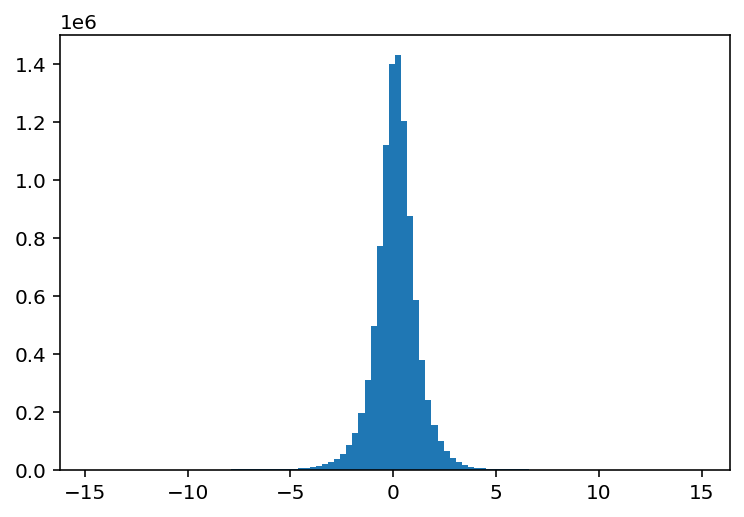

In [9]:
plt.hist(t_diff, bins=100);

In [ ]:
scipy.stats.probplot(t_diff, plot=plt);

In [ ]:
print(RAPtrain.shape,  RAPval.shape,  RAPtest.shape)

In [ ]:
locations = {'bis', 'abr', 'unr', 'lbf', 'oax', 'top',
             'ddc', 'oun', 'ama', 'fwd', 'maf', 'drt',
             'lzk', 'sgf', 'shv', 'dvn', 'ilx', 'mpx'} # 'sgp'
l_ind = np.arange(len(locations))
months = np.arange(1, 13)

width = 0.27 # the width of the bars

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

FILEtrain_content = np.array([f.split('_') for f in FILEtrain])
FILEval_content   = np.array([f.split('_') for f in FILEval])
FILEtest_content  = np.array([f.split('_') for f in FILEtest])

_, counts = np.unique(FILEtrain_content[:,0], return_counts=True)
rects1 = axs[0].bar(l_ind, counts, width, alpha=0.5)
_, counts = np.unique(FILEval_content[:,0], return_counts=True)
rects2 = axs[0].bar(l_ind+width, counts, width, alpha=0.5)
_, counts = np.unique(FILEtest_content[:,0], return_counts=True)
rects3 = axs[0].bar(l_ind+width*2, counts, width, alpha=0.5)

axs[0].set_ylabel('counts')
axs[0].set_xticks(l_ind+width)
axs[0].set_xticklabels(locations, rotation=45)
axs[0].legend((rects1[0], rects2[0], rects3[0]), ('train', 'val', 'test'));

_, counts = np.unique(pd.to_datetime(FILEtrain_content[:,1], format='%Y-%m-%dT%H:%M:%S.%f').month.values,
                      return_counts=True)
rects1 = axs[1].bar(months, counts, width, alpha=0.5)
_, counts = np.unique(pd.to_datetime(FILEval_content[:,1], format='%Y-%m-%dT%H:%M:%S.%f').month.values,
                      return_counts=True)
rects2 = axs[1].bar(months+width, counts, width, alpha=0.5)
_, counts = np.unique(pd.to_datetime(FILEtest_content[:,1], format='%Y-%m-%dT%H:%M:%S.%f').month.values,
                      return_counts=True)
rects3 = axs[1].bar(months+width*2, counts, width, alpha=0.5)

axs[1].set_ylabel('counts')
axs[1].set_xticks(months+width)
axs[1].set_xticklabels(months, rotation=45)
axs[1].legend((rects1[0], rects2[0], rects3[0]), ('train', 'val', 'test'));

fig.tight_layout()

In [7]:
baseline = dict()

sets = ['train', 'val', 'test']

for i, (RAP, RAOB) in enumerate([(RAPtrain, RAOBtrain),
                                 (RAPval  , RAOBval),
                                 (RAPtest , RAOBtest)]):
    (rmse, mean_rmse, # temperature
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(RAP[:,:,1], RAOB[:, :, 1])
    baseline[f'rap_temperature_{sets[i]}_rmse'] = rmse.tolist()
    baseline[f'rap_temperature_{sets[i]}_mean_rmse'] = mean_rmse
    baseline[f'rap_temperature_{sets[i]}_rmse_sfc'] = rmse_sfc.tolist()
    baseline[f'rap_temperature_{sets[i]}_mean_rmse_sfc'] = mean_rmse_sfc
    
    (rmse, mean_rmse, #dewpoint
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(RAP[:,:,2], RAOB[:, :, 2])
    baseline[f'rap_dewpoint_{sets[i]}_rmse'] = rmse.tolist()
    baseline[f'rap_dewpoint_{sets[i]}_mean_rmse'] = mean_rmse
    baseline[f'rap_dewpoint_{sets[i]}_rmse_sfc'] = rmse_sfc.tolist()
    baseline[f'rap_dewpoint_{sets[i]}_mean_rmse_sfc'] = mean_rmse_sfc

In [8]:
s = 'test'
print(baseline[f'rap_temperature_{s}_mean_rmse'])
print(baseline[f'rap_temperature_{s}_mean_rmse_sfc'])
print(baseline[f'rap_dewpoint_{s}_mean_rmse'])
print(baseline[f'rap_dewpoint_{s}_mean_rmse_sfc'])

1.0514866227677415
1.0619079297332366
6.178266681033925
3.2435491271550396


In [9]:
def min_max(df):
    min_i = np.inf
    min_v = np.inf
    max_i = 0
    max_v = 0
    for i, row in df.iterrows():
        train_rmse = np.asarray(literal_eval(row[f'root_mean_squared_error']))
        if train_rmse.min() < min_v:
            min_v = train_rmse.min()
            min_i = i
        if train_rmse.max() > max_v:
            max_v = train_rmse.max()
            max_i = i  

        plt.plot(train_rmse)
        plt.plot(np.asarray(literal_eval(row[f'val_root_mean_squared_error'])),'--')

    return min_i, min_v, max_i, max_v

# Fully Connected

In [93]:
df = pd.read_csv(os.path.join(VOL, 'alley_fully_connected_model_temperature_dewpoint.csv'))

In [75]:
df[['hiddens', 'loss_f', 'ml_total_test_rmse_sfc', 'ml_total_test_rmse', 
    'ml_temperature_test_mean_rmse', 'ml_temperature_test_mean_rmse_sfc',
    'ml_dewpoint_test_mean_rmse', 'ml_dewpoint_test_mean_rmse_sfc']].sort_values('ml_total_test_rmse_sfc');

In [94]:
for r in ['[]', '[0, 1, 2]']:
    for g in ['[]', '[0, 1, 2, 3, 4, 5, 6, 7]']:
        print(r, g)
        trial = df.loc[(df['rtma_input_channels'] == r) & 
                       (df['goes_input_channels'] == g) &
                       (df['hiddens'] == '[0]')].sort_values('ml_total_test_rmse').head(1)

        print(f"{trial['ml_temperature_test_mean_rmse'].values[0]:.3f} & \
{trial['ml_temperature_test_mean_rmse_sfc'].values[0]:.3f} & \
{trial['ml_dewpoint_test_mean_rmse'].values[0]:.3f} & \
{trial['ml_dewpoint_test_mean_rmse_sfc'].values[0]:.3f} && ")
        
        print(f"{trial['ml_total_test_rmse'].values[0]:.3f} & \
{trial['ml_total_test_rmse_sfc'].values[0]:.3f} && ")

[] []
1.010 & 1.029 & 5.006 & 2.990 && 
3.611 & 1.000 && 
[] [0, 1, 2, 3, 4, 5, 6, 7]
1.003 & 1.021 & 4.878 & 2.988 && 
3.521 & 0.993 && 
[0, 1, 2] []
1.007 & 1.026 & 4.997 & 2.976 && 
3.604 & 1.002 && 
[0, 1, 2] [0, 1, 2, 3, 4, 5, 6, 7]
1.008 & 1.033 & 4.874 & 2.987 && 
3.520 & 1.005 && 


In [95]:
for r in ['[]', '[0, 1, 2]']:
    for g in ['[]', '[0, 1, 2, 3, 4, 5, 6, 7]']:
        print(r, g)
        trial = df.loc[(df['rtma_input_channels'] == r) & 
                       (df['goes_input_channels'] == g) &
                       (df['hiddens'] == '[1024, 1024]')].sort_values('ml_total_test_rmse').head(1)

        print(f"{trial['ml_temperature_test_mean_rmse'].values[0]:.3f} & \
{trial['ml_temperature_test_mean_rmse_sfc'].values[0]:.3f} & \
{trial['ml_dewpoint_test_mean_rmse'].values[0]:.3f} & \
{trial['ml_dewpoint_test_mean_rmse_sfc'].values[0]:.3f} && ")
        
        print(f"{trial['ml_total_test_rmse'].values[0]:.3f} & \
{trial['ml_total_test_rmse_sfc'].values[0]:.3f} && ")

[] []
1.030 & 1.051 & 4.760 & 2.917 && 
3.444 & 1.008 && 
[] [0, 1, 2, 3, 4, 5, 6, 7]
1.027 & 1.052 & 4.568 & 2.943 && 
3.310 & 1.076 && 
[0, 1, 2] []
1.022 & 1.050 & 4.737 & 2.924 && 
3.427 & 1.018 && 
[0, 1, 2] [0, 1, 2, 3, 4, 5, 6, 7]
1.032 & 1.073 & 4.571 & 2.902 && 
3.314 & 1.000 && 


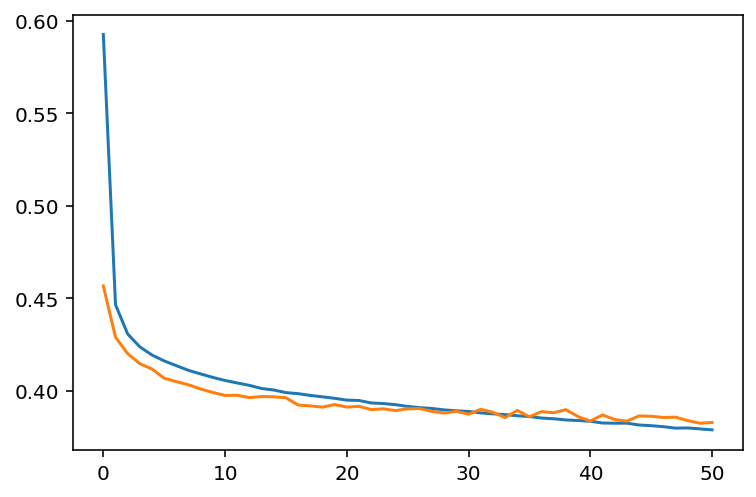

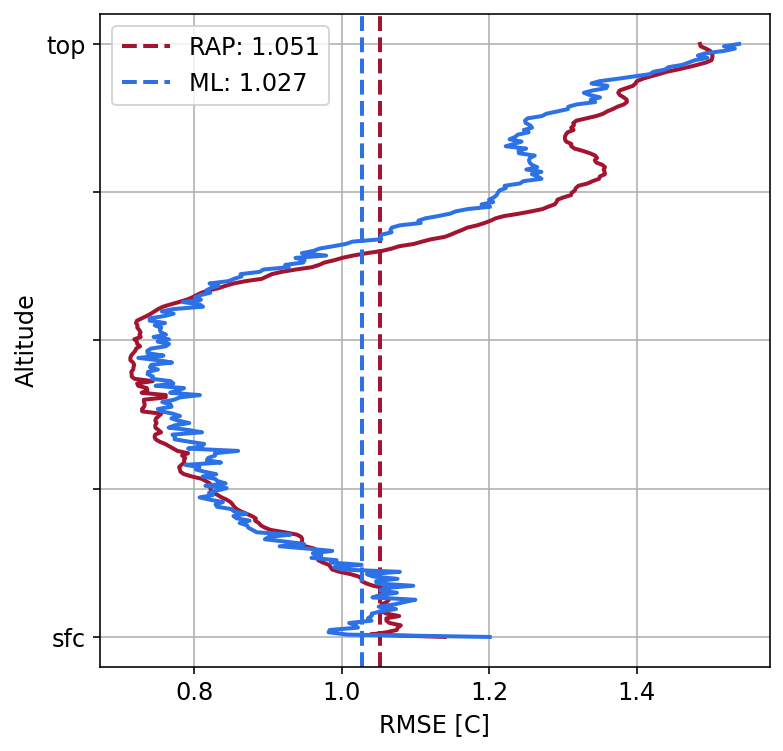

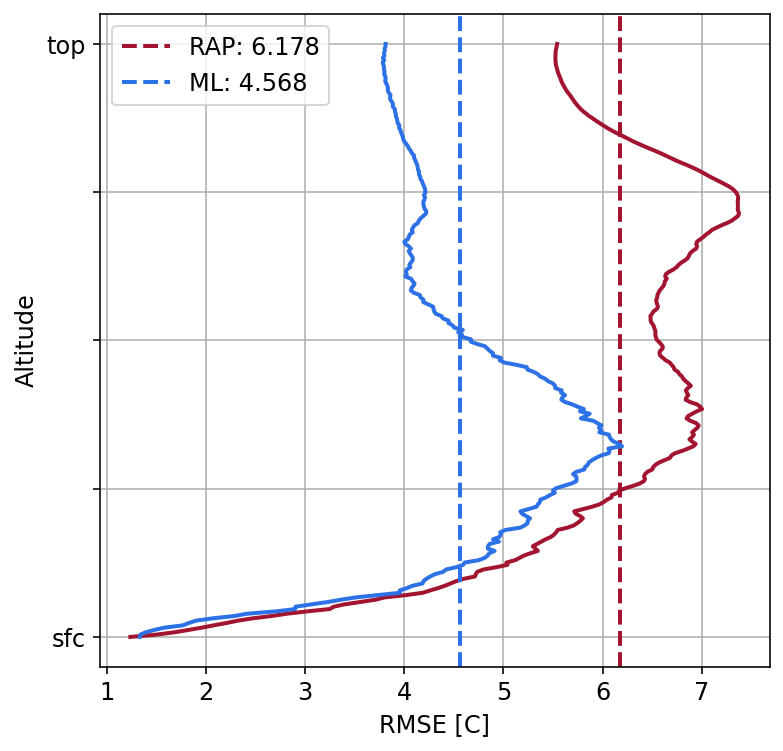

In [9]:
# i = df.sort_values(['ml_temperature_test_mean_rmse_sfc']).index[0]
i = df.sort_values(['ml_total_test_rmse']).index[0]
fig, ax = plt.subplots()
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_test_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_test_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_test_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_test_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)

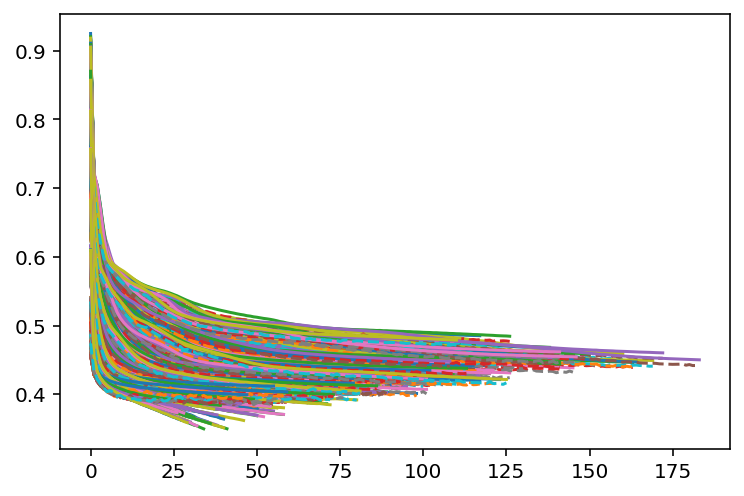

In [28]:
min_i, min_v, max_i, max_v = min_max(df)

In [29]:
field = ['ml_total_test_rmse']
trial = df.loc[(df['rtma_input_channels'] == '[0, 1, 2]') & 
               (df['goes_input_channels'] == '[0, 1, 2, 3, 4, 5, 6, 7]') &
               (df['dropout'] == False) &
               (df['hiddens'] == '[512]')]

trial[field].sem(), trial[field].mean()

(ml_total_test_rmse    0.007616
 dtype: float64,
 ml_total_test_rmse    3.419973
 dtype: float64)

In [50]:
results

OrderedDict([('[0]', (2.956081132688729, 0.0029772519626231125)),
             ('[32]', (3.2792281731590682, 0.015562831091092277)),
             ('[32, 32]', (3.588243354319961, 0.011097411130260967)),
             ('[32, 32, 32]', (3.7736110747740086, 0.0566365679058891)),
             ('[32, 32, 32, 32]', (4.043695076178031, 0.03397667748340271)),
             ('[32, 32, 32, 32, 32]', (4.05642838445956, 0.03193246162573134)),
             ('[64]', (3.1326598967464063, 0.011022011888595702)),
             ('[64, 64]', (3.238043935676693, 0.008767874212915396)),
             ('[64, 64, 64]', (3.3555189707327484, 0.014964853611752583)),
             ('[64, 64, 64, 64]', (3.524176144350811, 0.0271917382049131)),
             ('[64, 64, 64, 64, 64]',
              (3.6142138375277746, 0.028956556457537252)),
             ('[128]', (3.051252663181983, 0.007343803268134897)),
             ('[128, 128]', (3.1273246406430837, 0.009265962223911612)),
             ('[128, 128, 128]', (3.181861

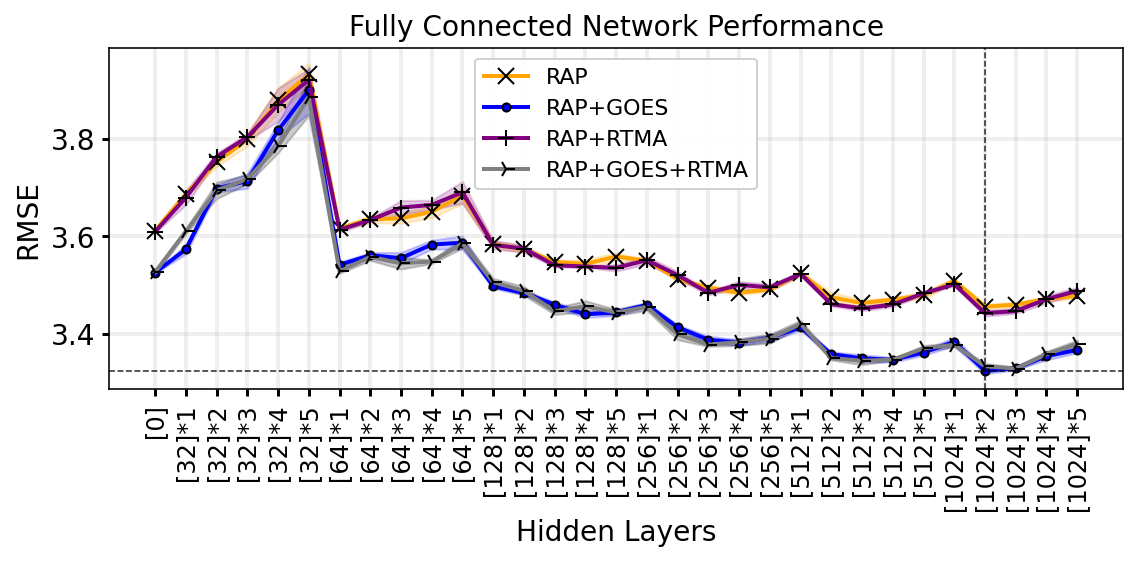

In [66]:
def trial_results(rtma_input_channels, goes_input_channels, dropout):
    results = dict()
    field = ['ml_total_test_rmse'] # ['ml_total_test_rmse']
    for h in df['hiddens'].unique():
        # skip units
        if literal_eval(h)[0] not in [4, 8, 16]:
            trial = df.loc[(df['rtma_input_channels'] == rtma_input_channels) & 
                           (df['goes_input_channels'] == goes_input_channels) &
                           (df['dropout'] == dropout) &
                           (df['hiddens'] == h)]

            trial_t_mean = trial[field].mean().values[0]
            trial_t_sem = trial[field].sem().values[0]
            results[h] = (trial_t_mean, trial_t_sem)
            
    return OrderedDict(sorted(results.items(), key=lambda t: literal_eval(list(t)[0])[0]))

fig, ax = plt.subplots(figsize=(8,4))

linewidth = 2

results = trial_results('[]', '[]', False)
mean_sem = np.array(list(results.values()))
min_err = min(mean_sem[:,0])
min_err_i = np.argmin(mean_sem[:,0])

ax.plot(range(len(results)), mean_sem[:,0], '-x', markersize=8, color='orange', 
        markeredgecolor='k', linewidth=linewidth, label='RAP')
ax.fill_between(range(len(results)), mean_sem[:,0] - mean_sem[:,1], 
                mean_sem[:,0] + mean_sem[:,1],
                color='orange', alpha=0.2)

results = trial_results('[]', '[0, 1, 2, 3, 4, 5, 6, 7]', False)
mean_sem = np.array(list(results.values()))
if min(mean_sem[:,0]) < min_err:
    min_err = min(mean_sem[:,0])
    min_err_i = np.argmin(mean_sem[:,0])

ax.plot(range(len(results)), mean_sem[:,0], '-', marker='.', markersize=8, color='blue', 
        markeredgecolor='k', linewidth=linewidth, label='RAP+GOES')
ax.fill_between(range(len(results)), mean_sem[:,0] - mean_sem[:,1], 
                mean_sem[:,0] + mean_sem[:,1],
                color='blue', alpha=0.2)

results = trial_results('[0, 1, 2]', '[]', False)
mean_sem = np.array(list(results.values()))
if min(mean_sem[:,0]) < min_err:
    min_err = min(mean_sem[:,0])
    min_err_i = np.argmin(mean_sem[:,0])
    
ax.plot(range(len(results)), mean_sem[:,0], '-+', markersize=8, color='purple',
        markeredgecolor='k', linewidth=linewidth, label='RAP+RTMA')
ax.fill_between(range(len(results)), mean_sem[:,0] - mean_sem[:,1], 
                mean_sem[:,0] + mean_sem[:,1],
                color='purple', alpha=0.2)

results = trial_results('[0, 1, 2]', '[0, 1, 2, 3, 4, 5, 6, 7]', False)
mean_sem = np.array(list(results.values()))
if min(mean_sem[:,0]) < min_err:
    min_err = min(mean_sem[:,0])
    min_err_i = np.argmin(mean_sem[:,0])

ax.plot(range(len(results)), mean_sem[:,0], '-4', markersize=9, color='gray', 
        markeredgecolor='k', linewidth=linewidth, label='RAP+GOES+RTMA')
ax.fill_between(range(len(results)), mean_sem[:,0] - mean_sem[:,1], 
                mean_sem[:,0] + mean_sem[:,1],
                color='black', alpha=0.2)

# minimum 
plt.axhline(y=min_err, color='k', linestyle='--', alpha=0.8, linewidth=0.8)
plt.axvline(x=min_err_i, color='k', linestyle='--', alpha=0.8, linewidth=0.8)

ax.set_xticks(range(len(results)))

labels = list(results.keys())
labels = []

for l in list(results.keys()):
    a = literal_eval(l)
    labels.append(f'[{str(a[0])}]*{len(a)}' if a[0] not in [0] else l)

default_font = 14
ax.set_xticklabels(labels);
ax.tick_params(axis='x', width=1.5, labelsize=12, rotation=90)
ax.tick_params(axis='y', width=1.5, labelsize=default_font)
ax.set_ylabel('RMSE', fontsize=default_font); ax.set_xlabel('Hidden Layers', fontsize=default_font)
ax.set_title('Fully Connected Network Performance', fontsize=default_font)
ax.grid(True, alpha=0.2, linewidth=linewidth)
plt.tight_layout()

legend1 = plt.legend(ncol=1, fontsize=11)
ax.add_artist(legend1)
plt.setp(legend1.get_title(),fontsize=default_font)

plt.savefig('/home/stock/research/media/fully_connected_rmse_results_wmae.pdf', dpi=300)

<ipython-input-35-2a66c6fd5ea8>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(9,4))


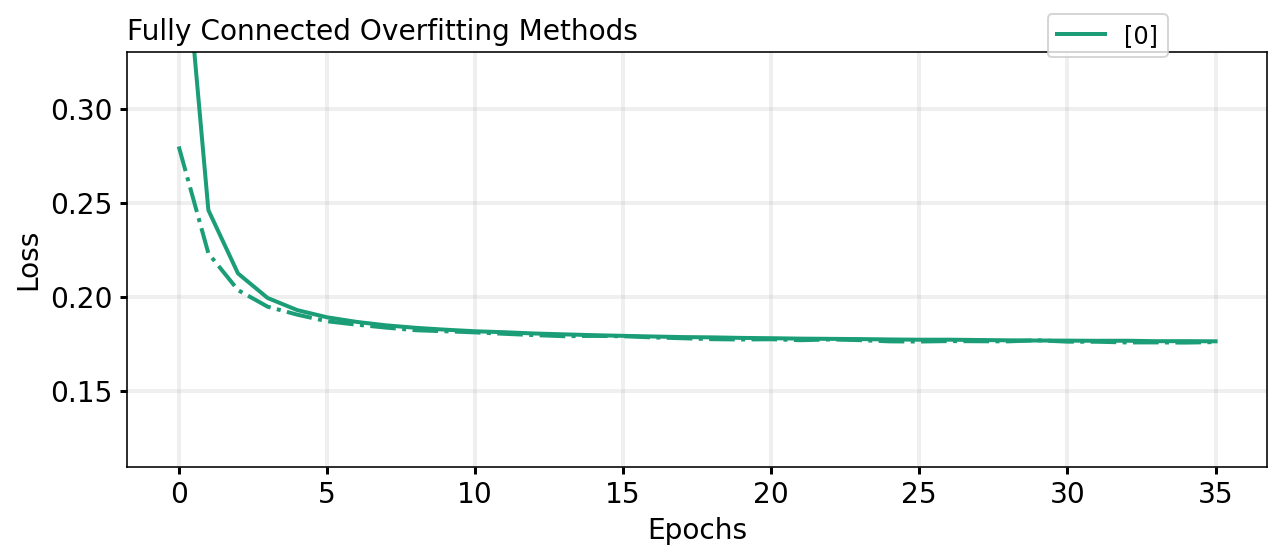

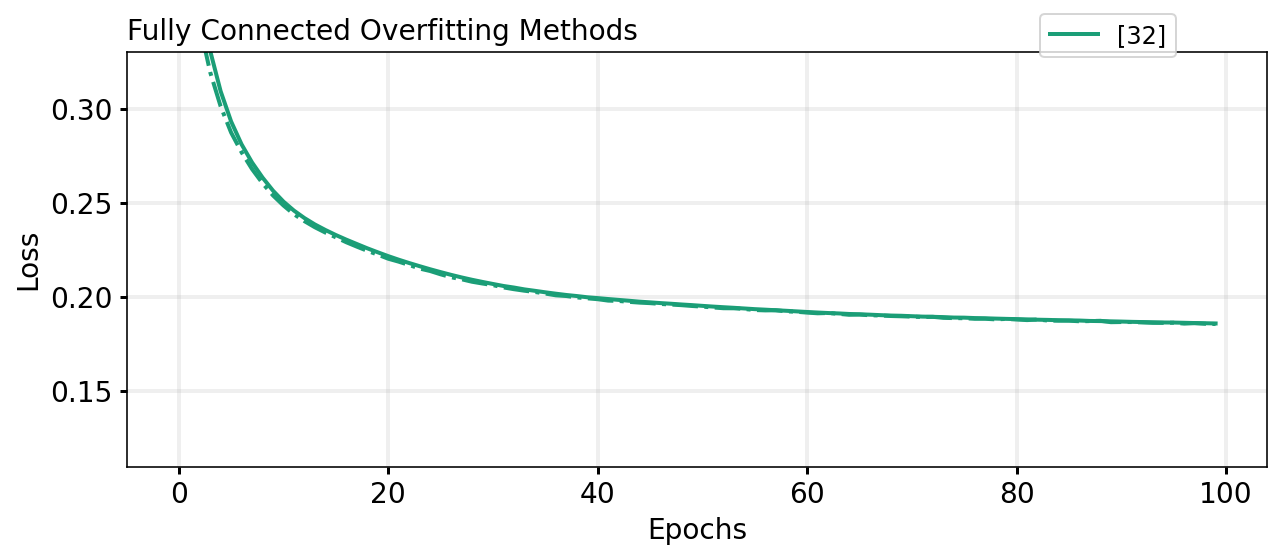

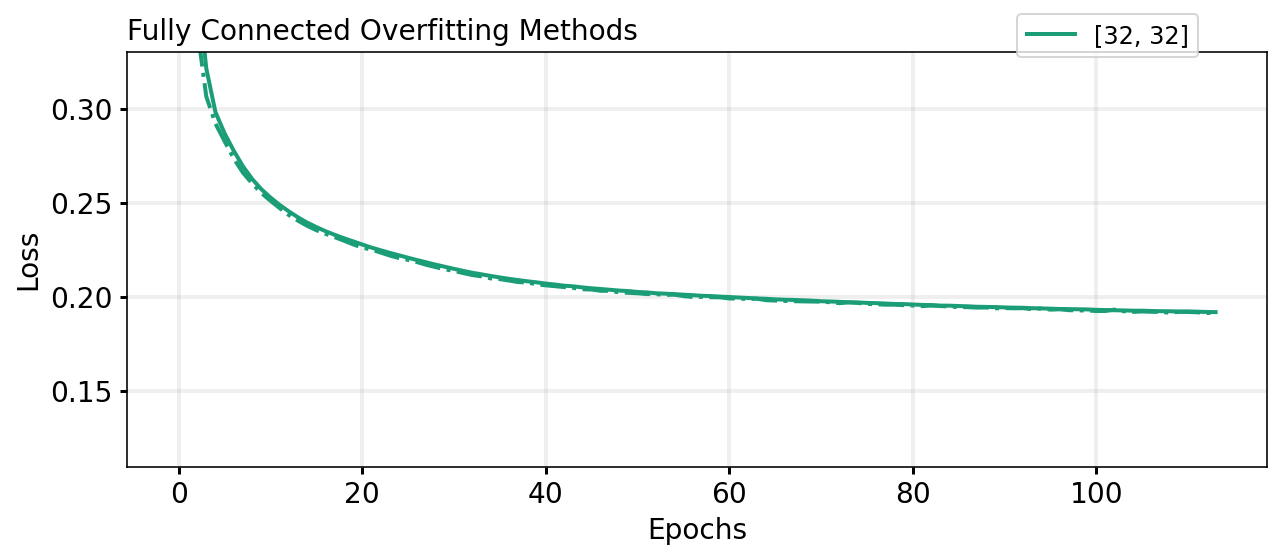

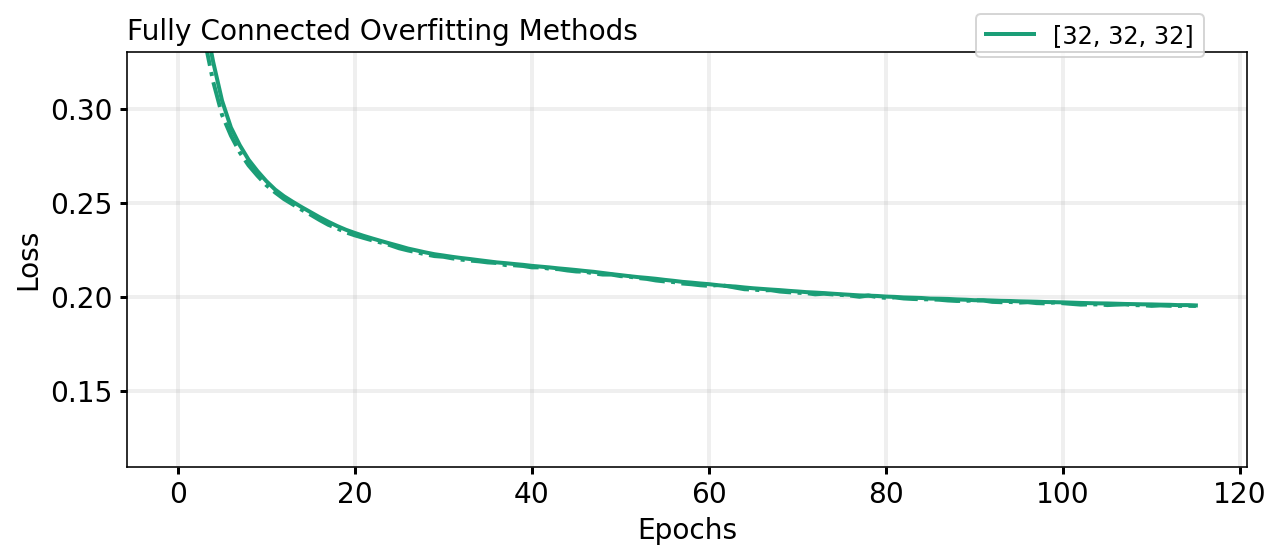

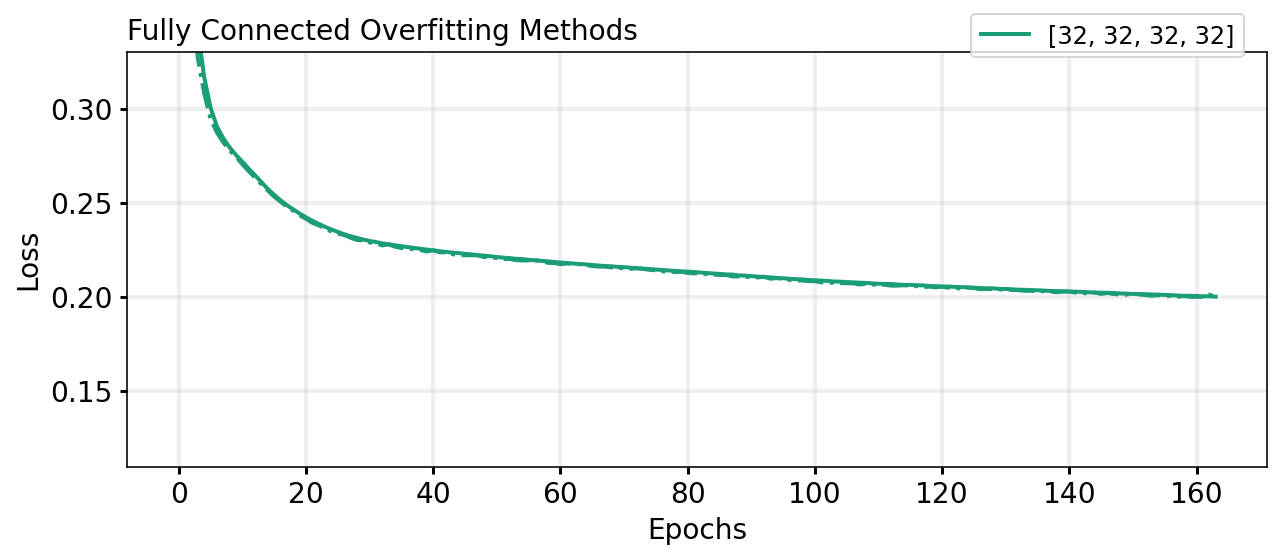

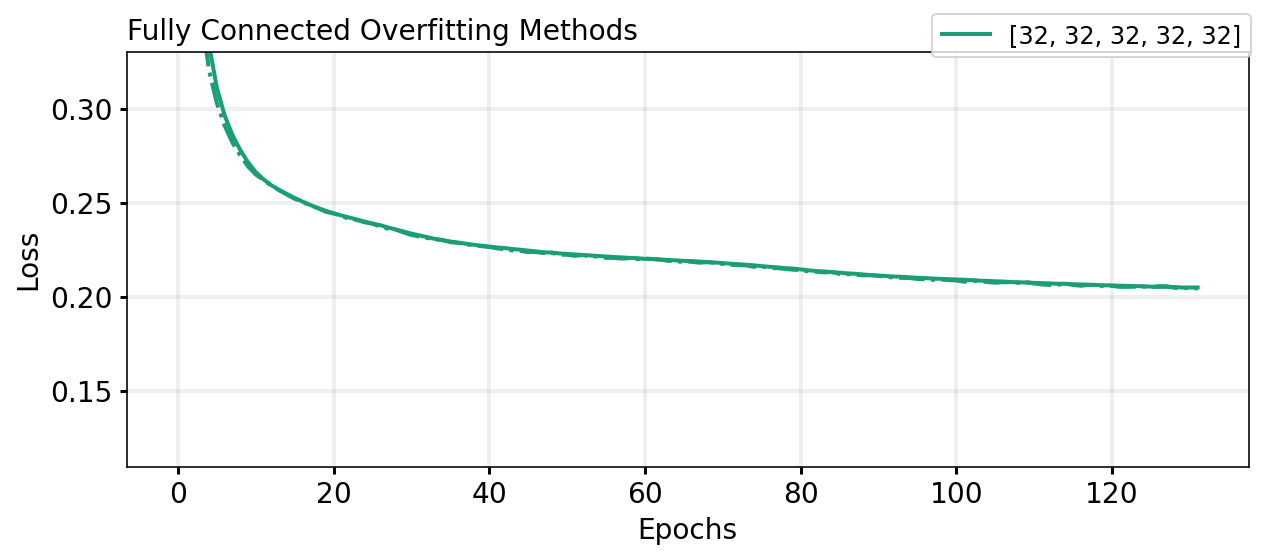

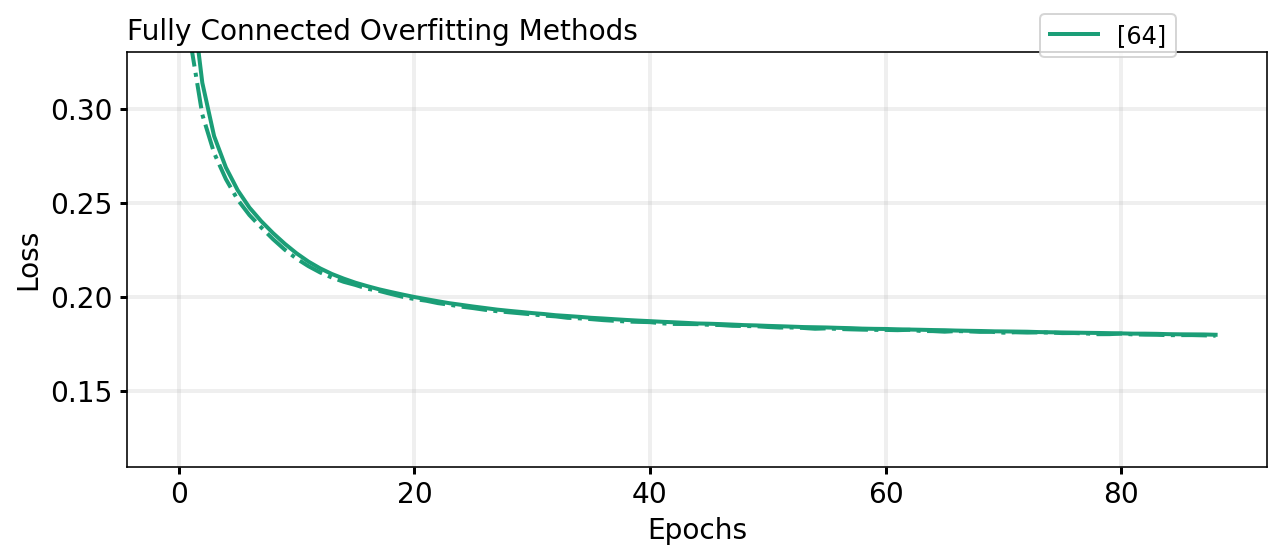

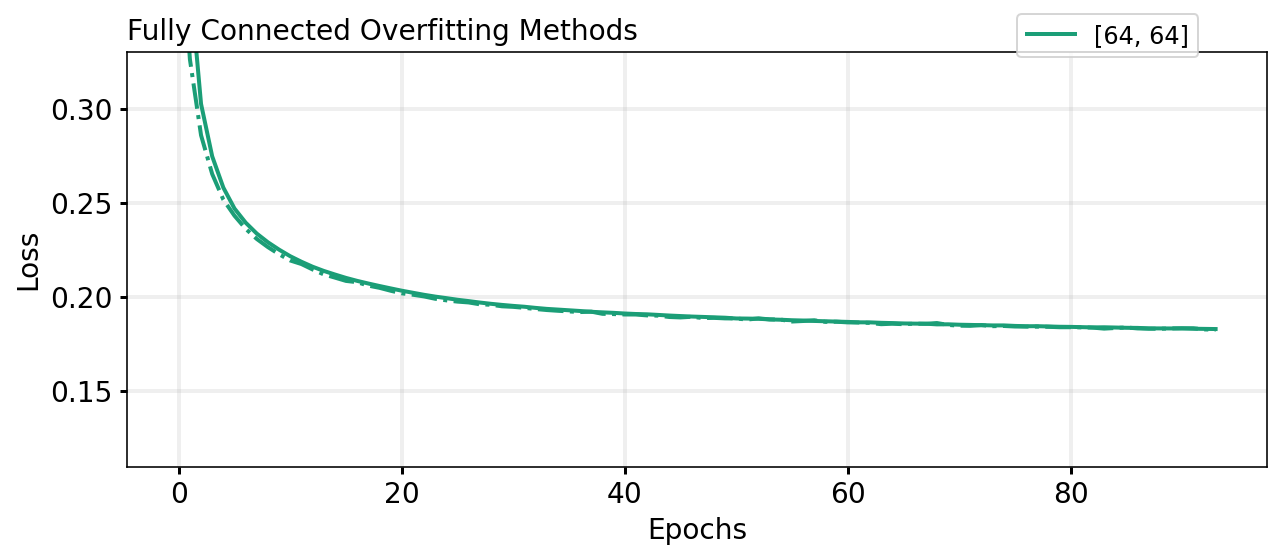

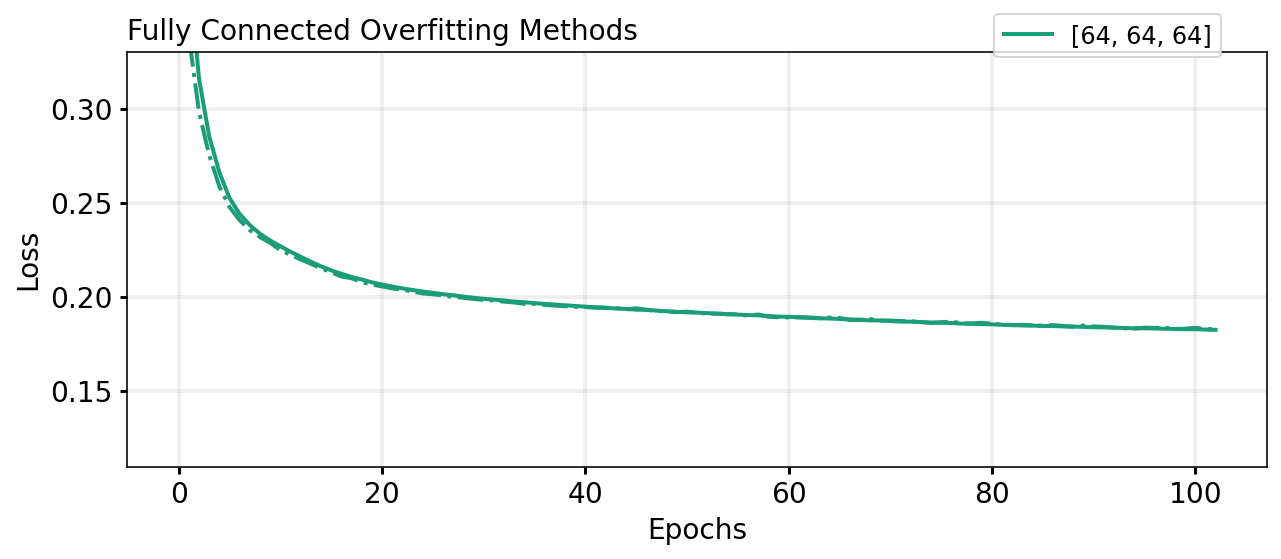

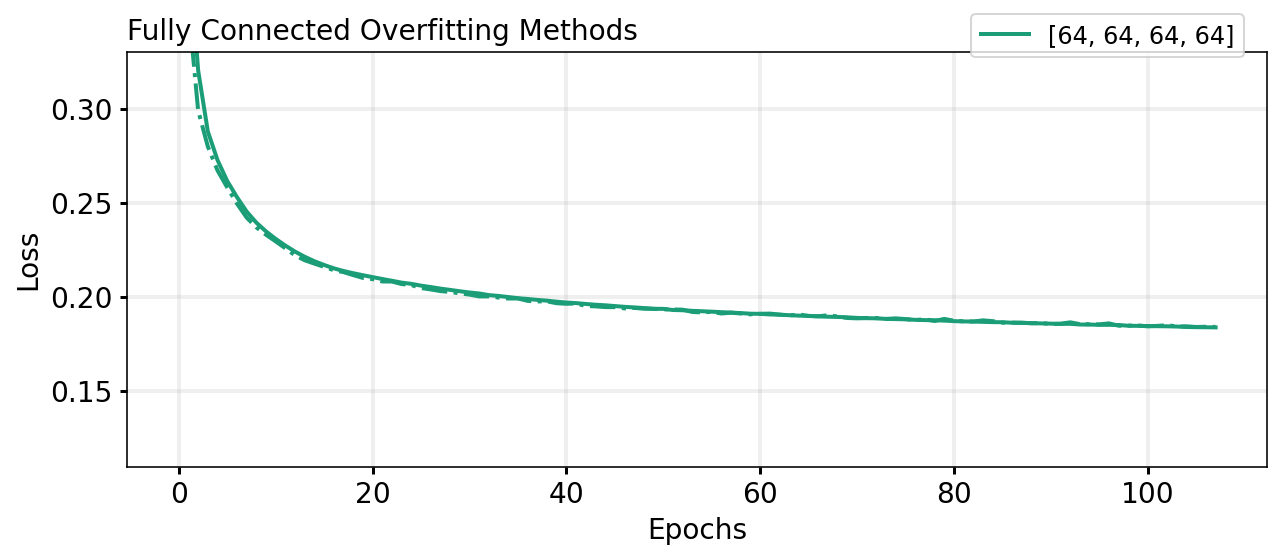

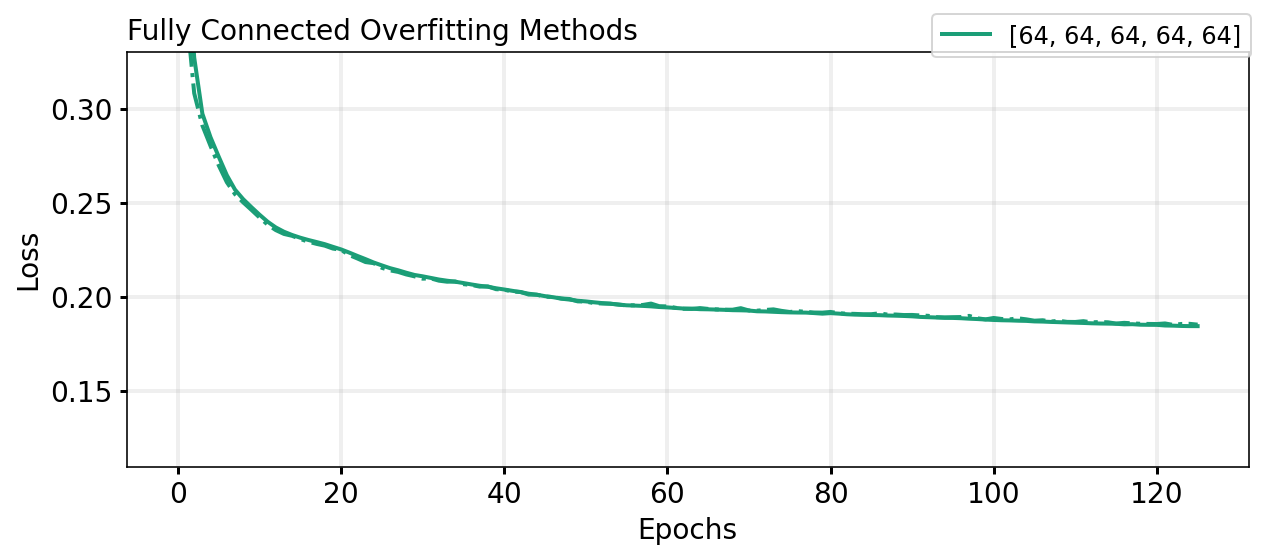

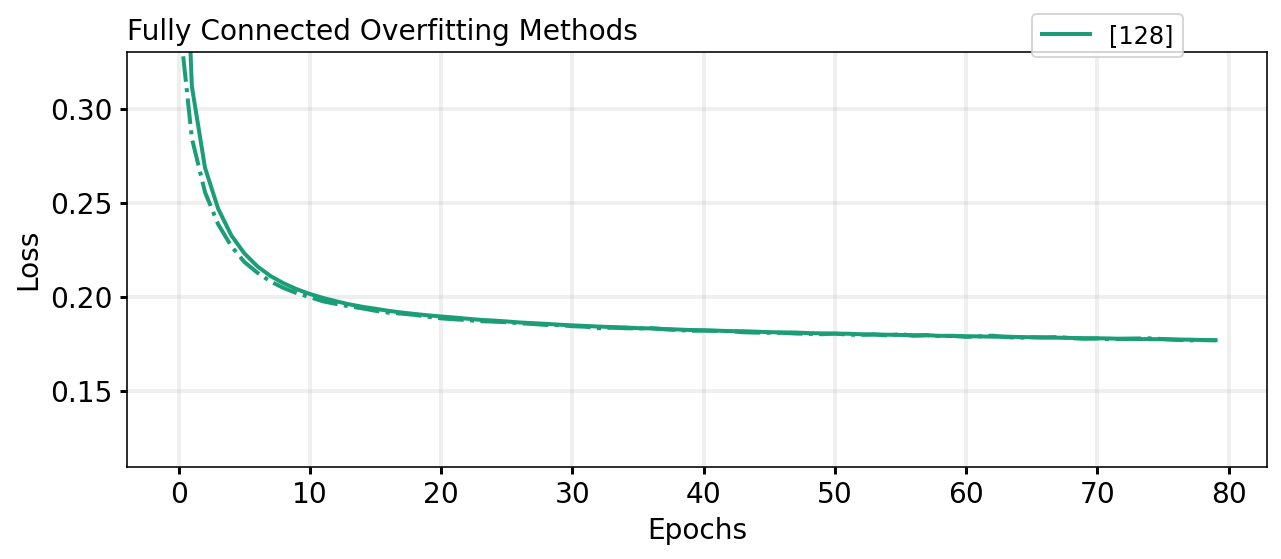

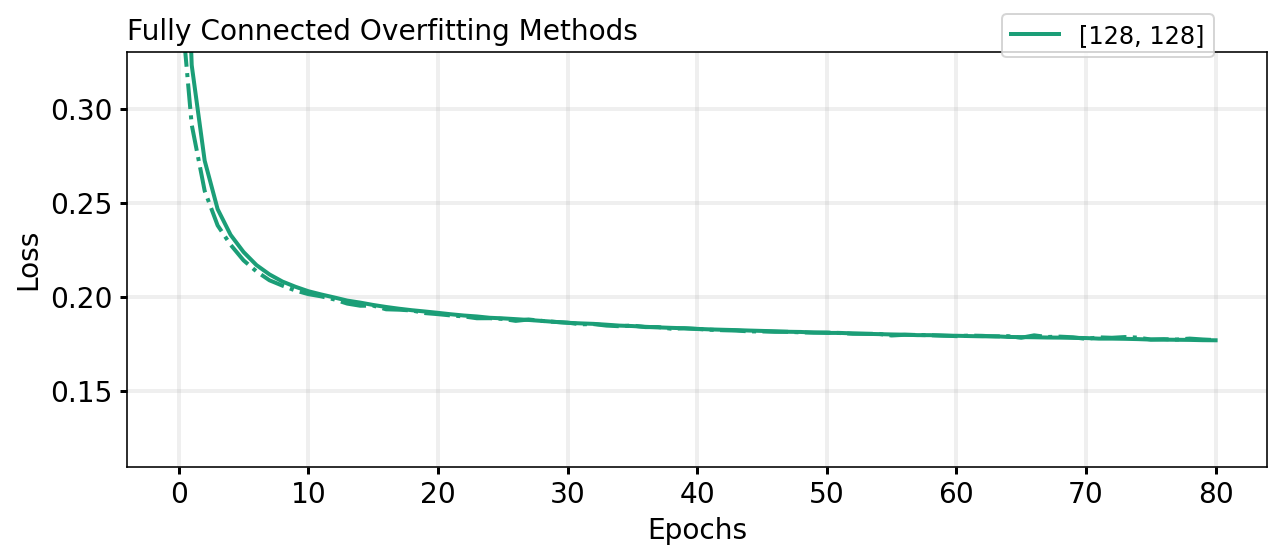

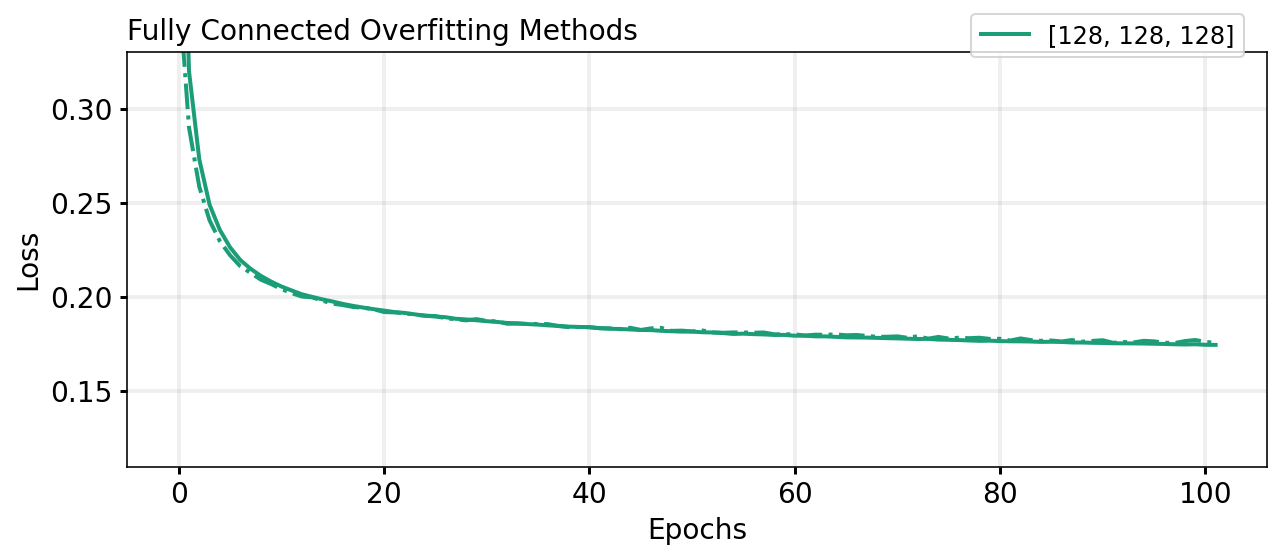

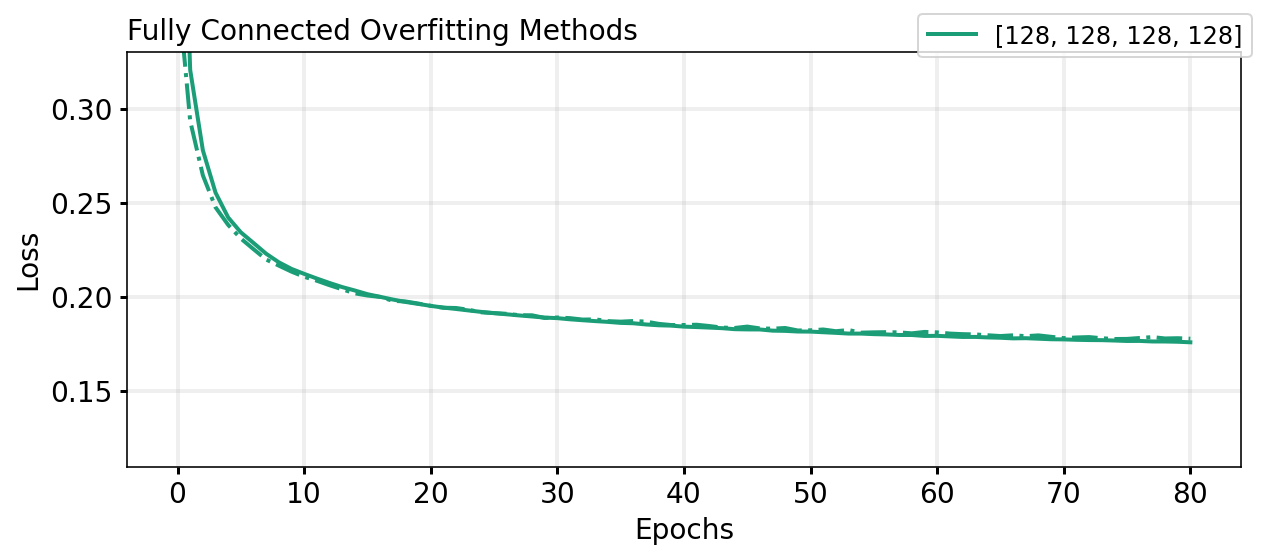

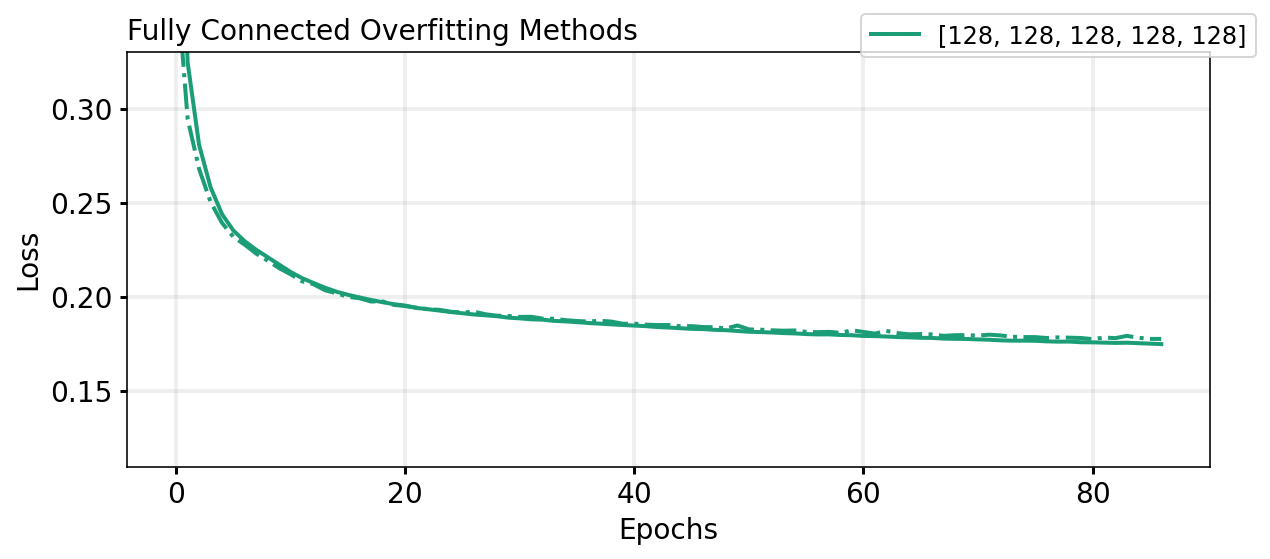

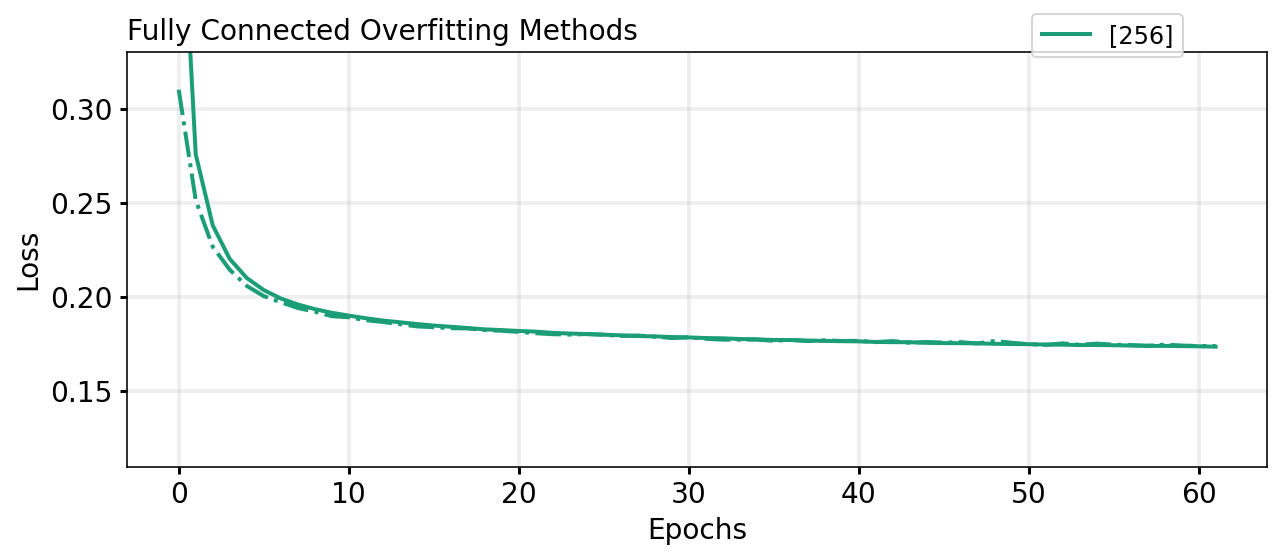

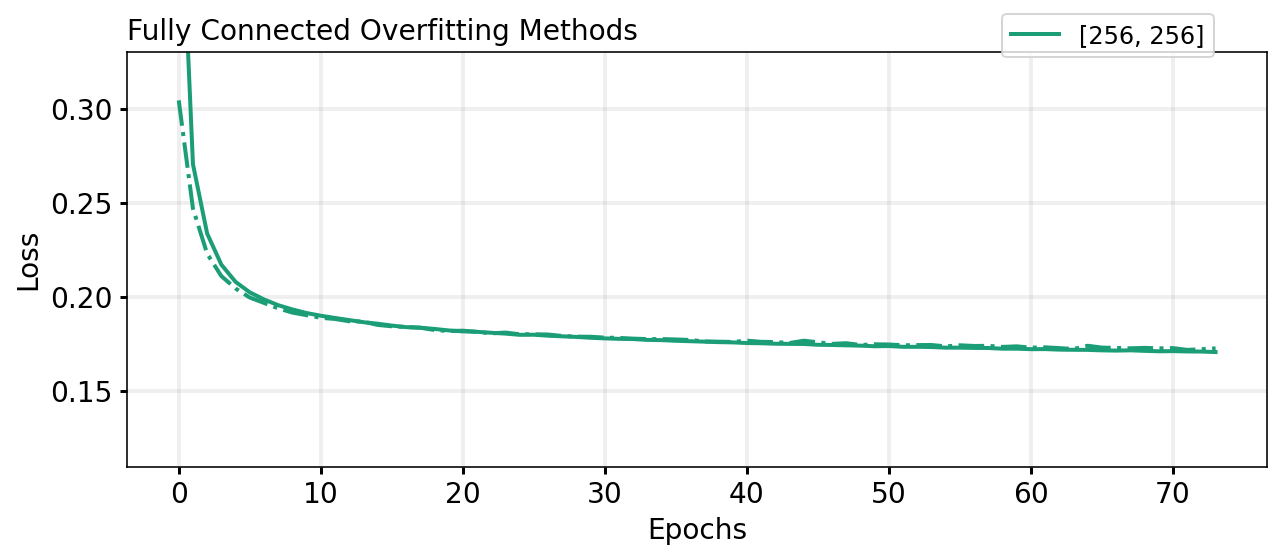

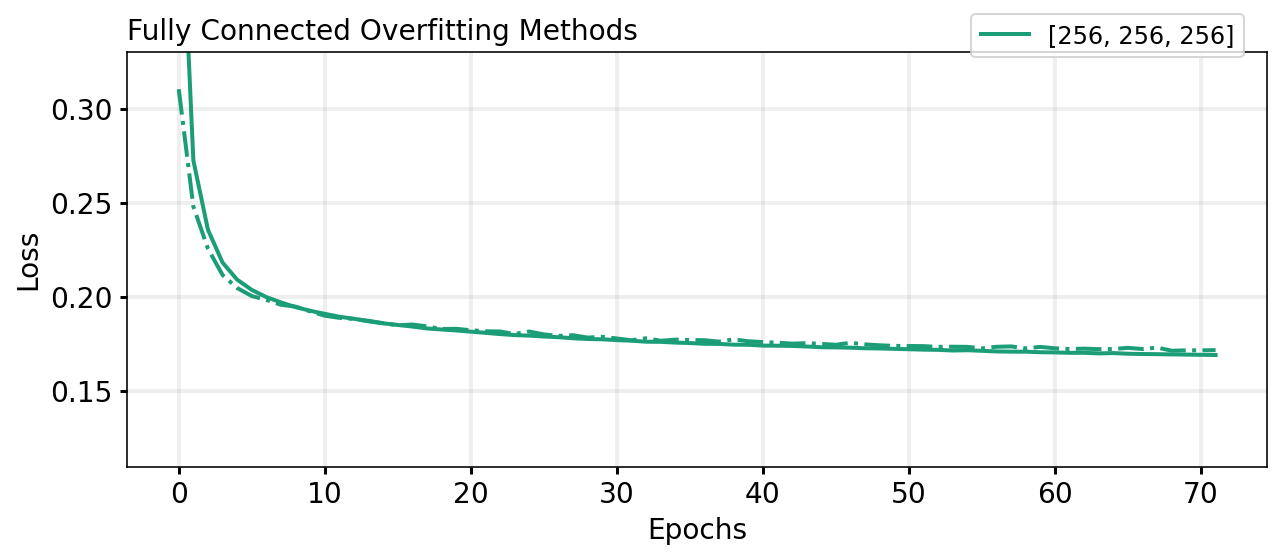

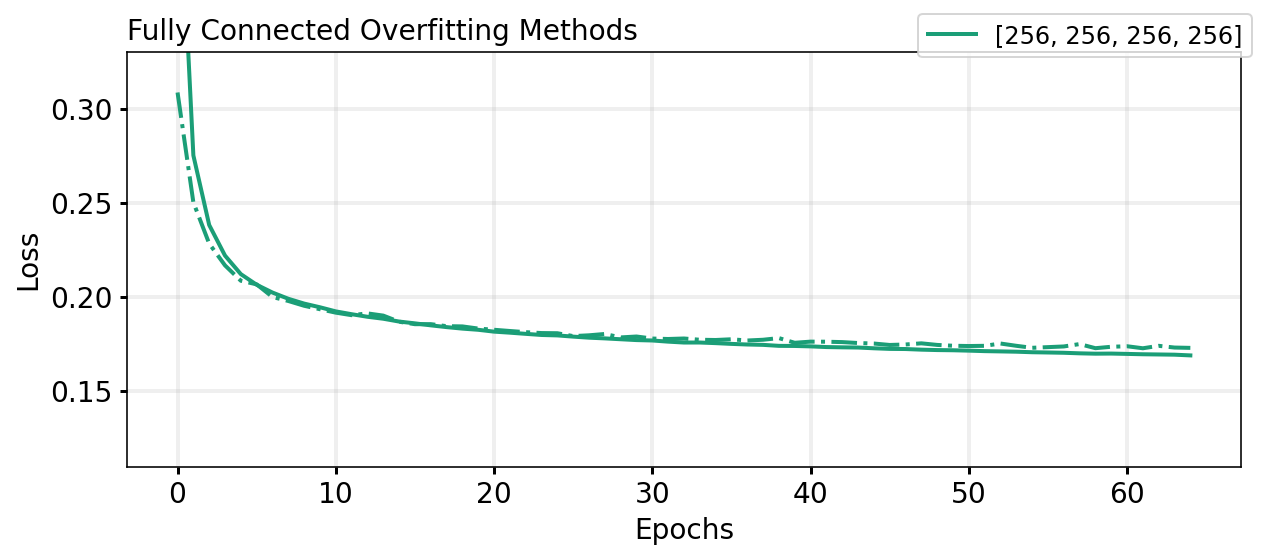

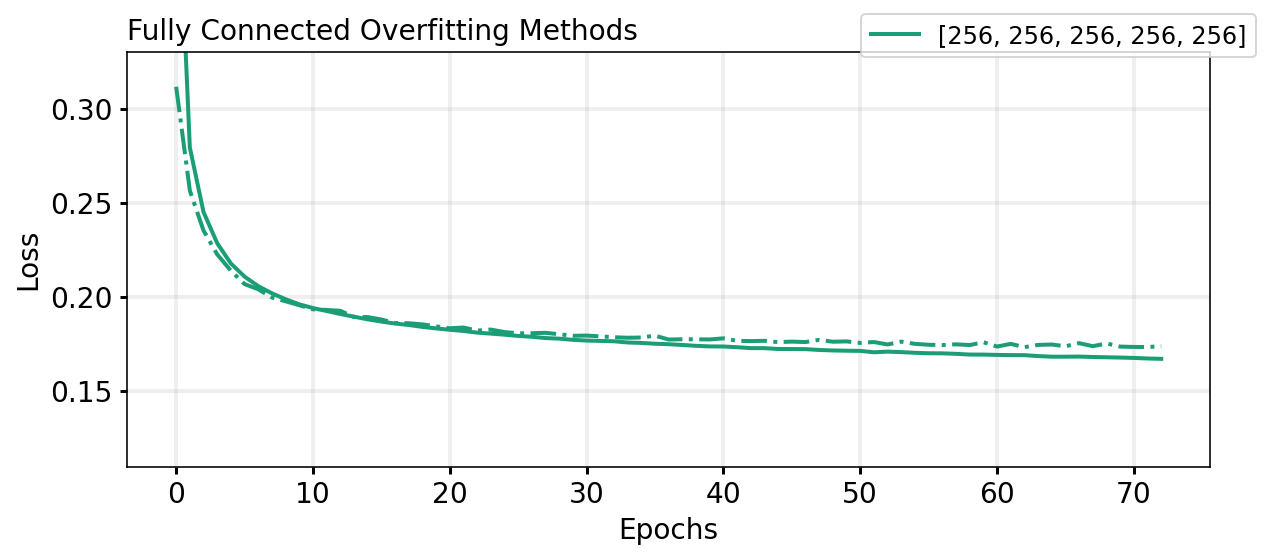

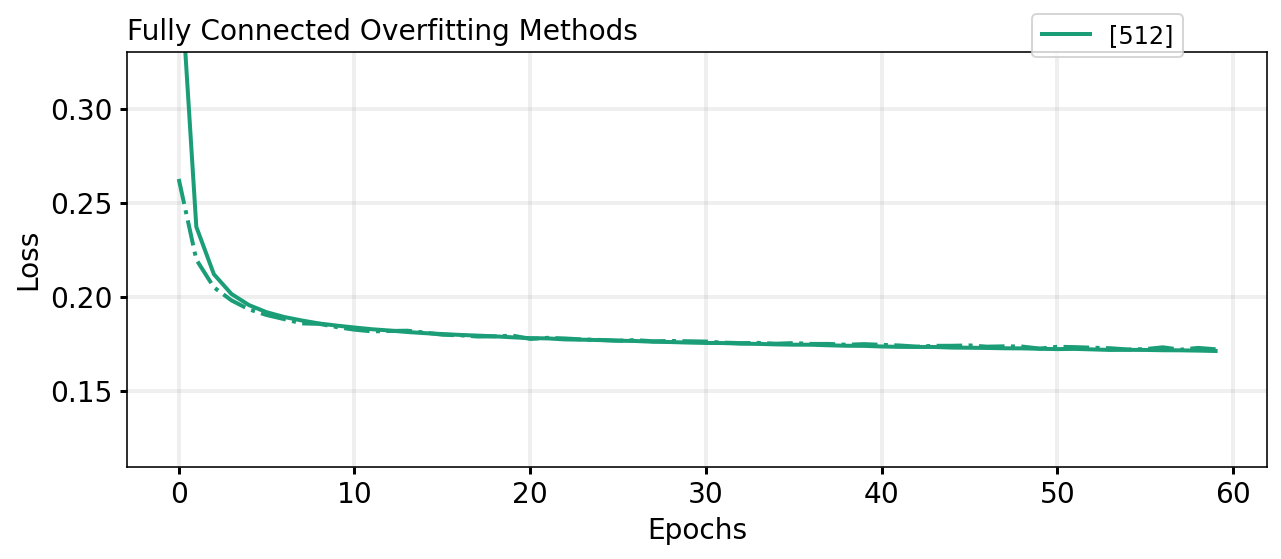

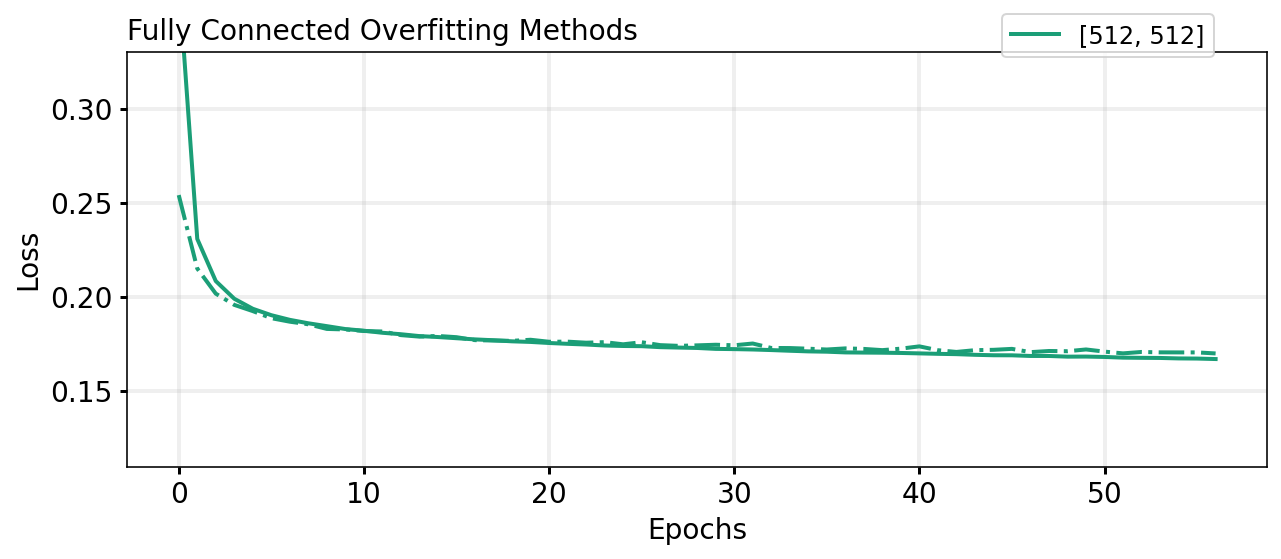

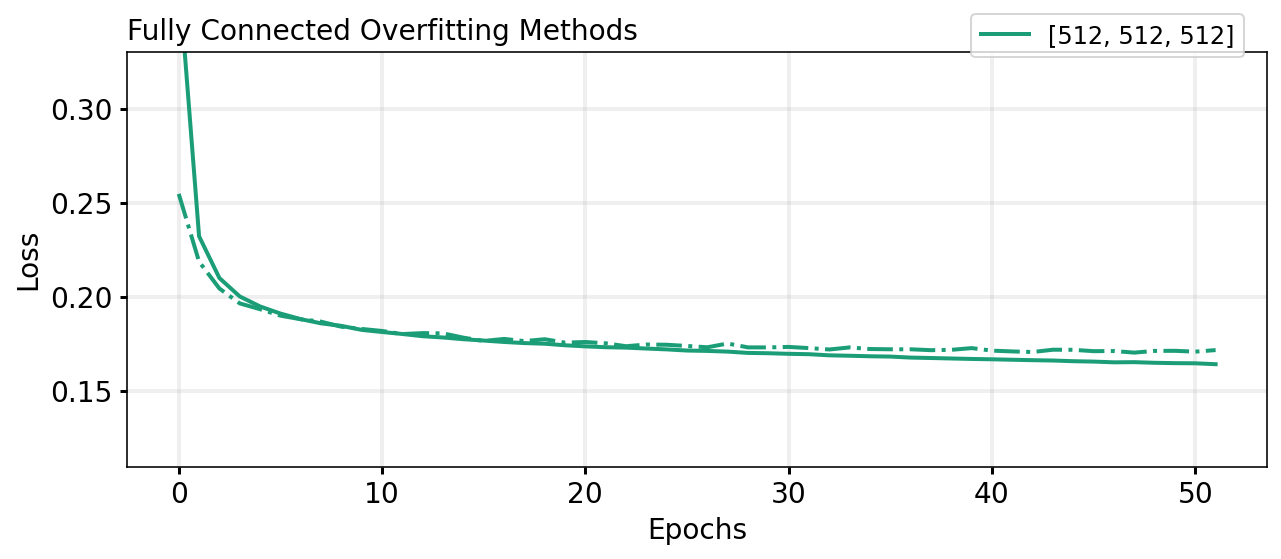

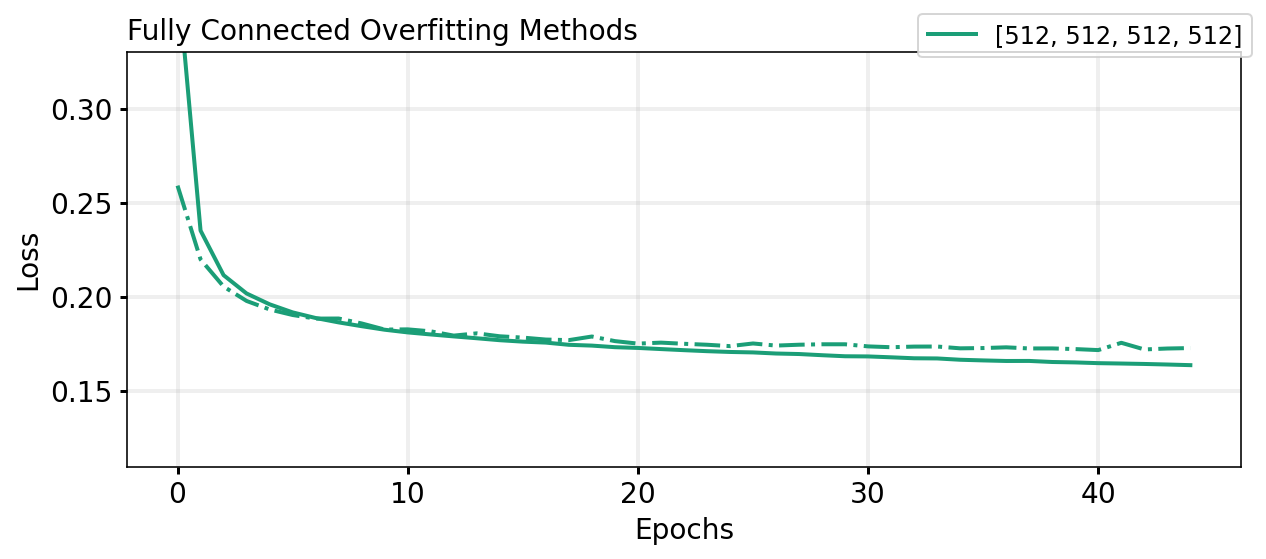

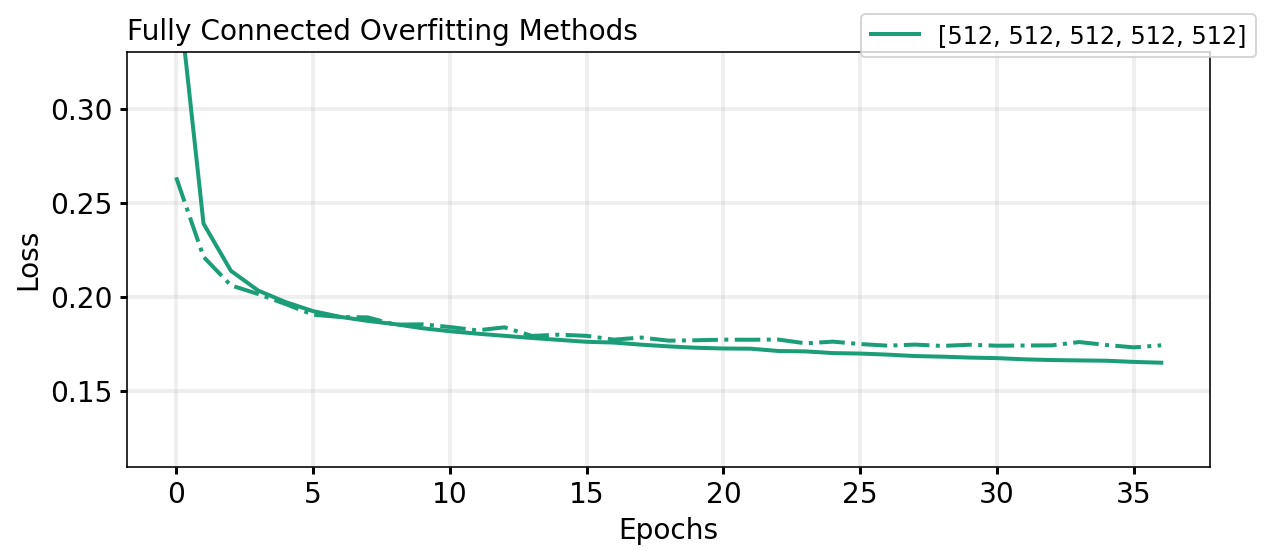

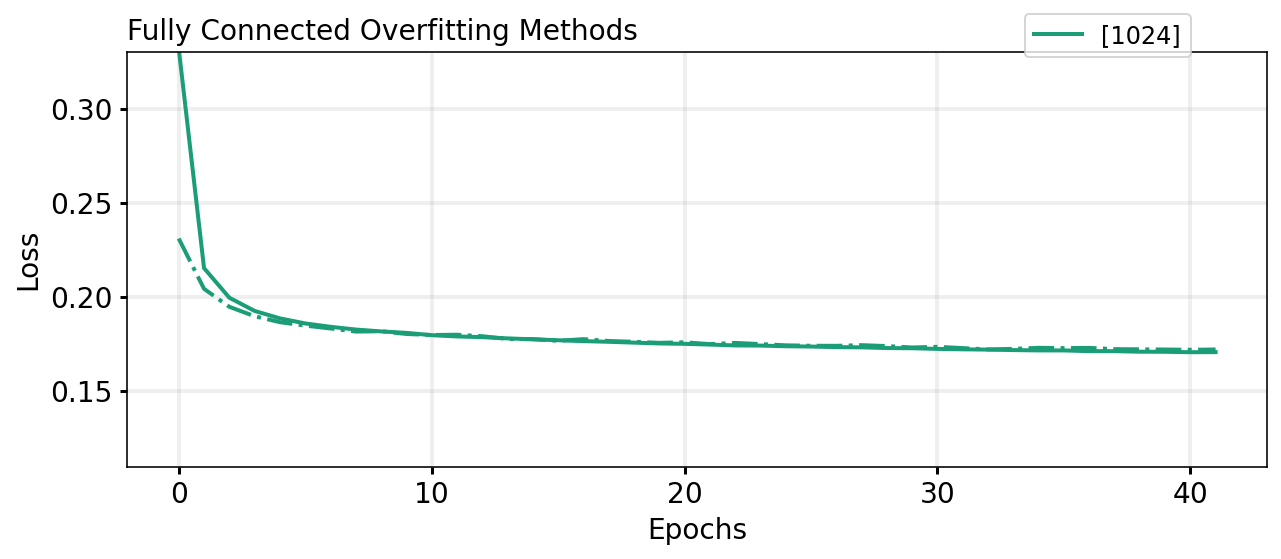

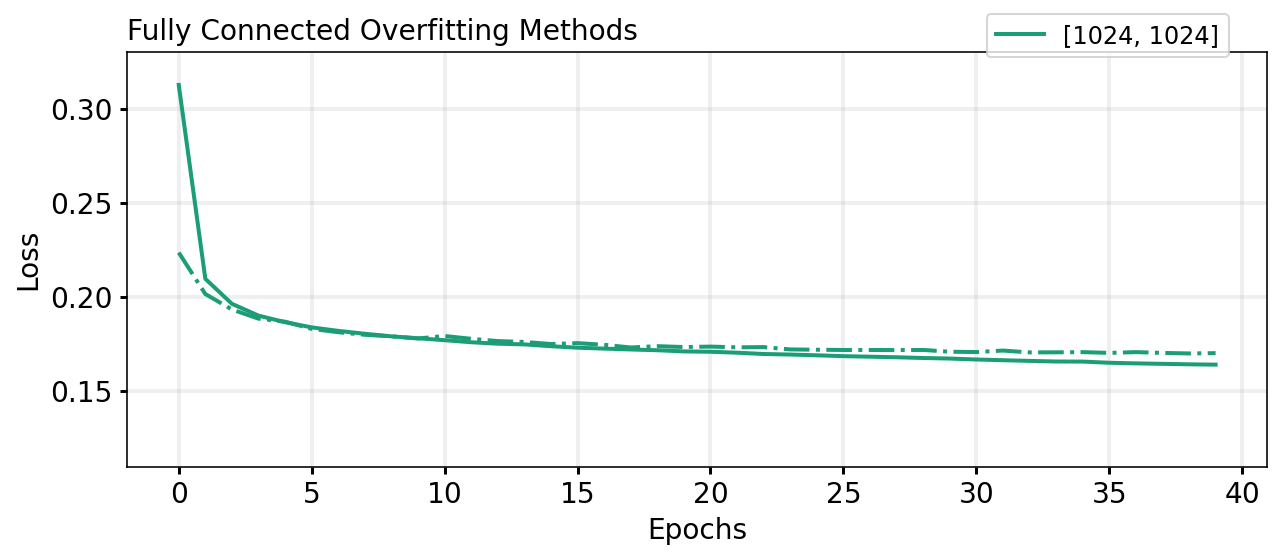

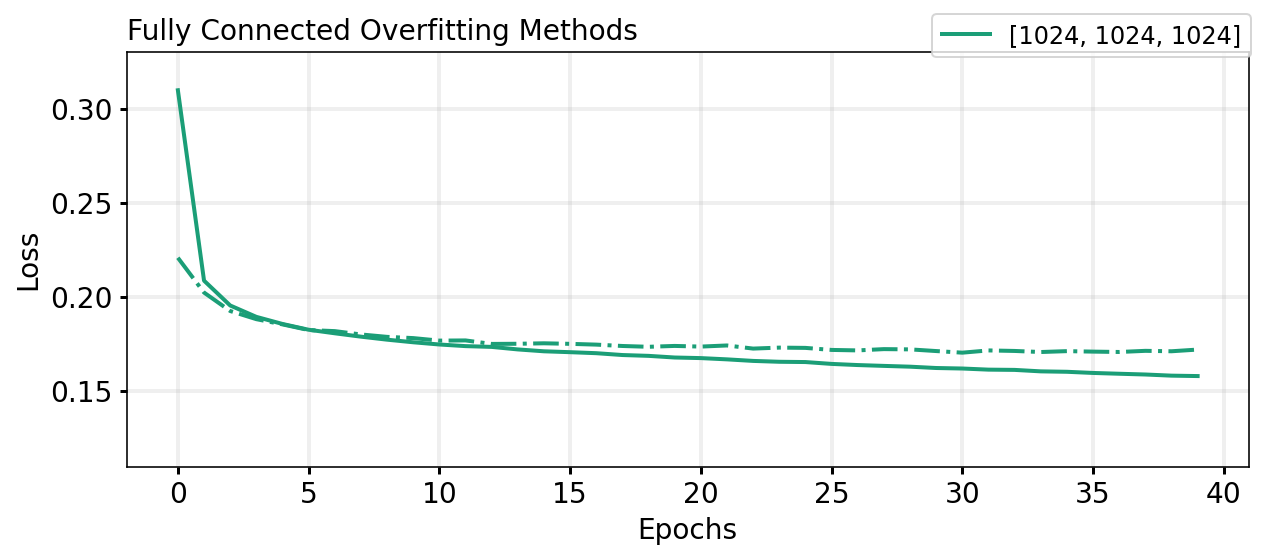

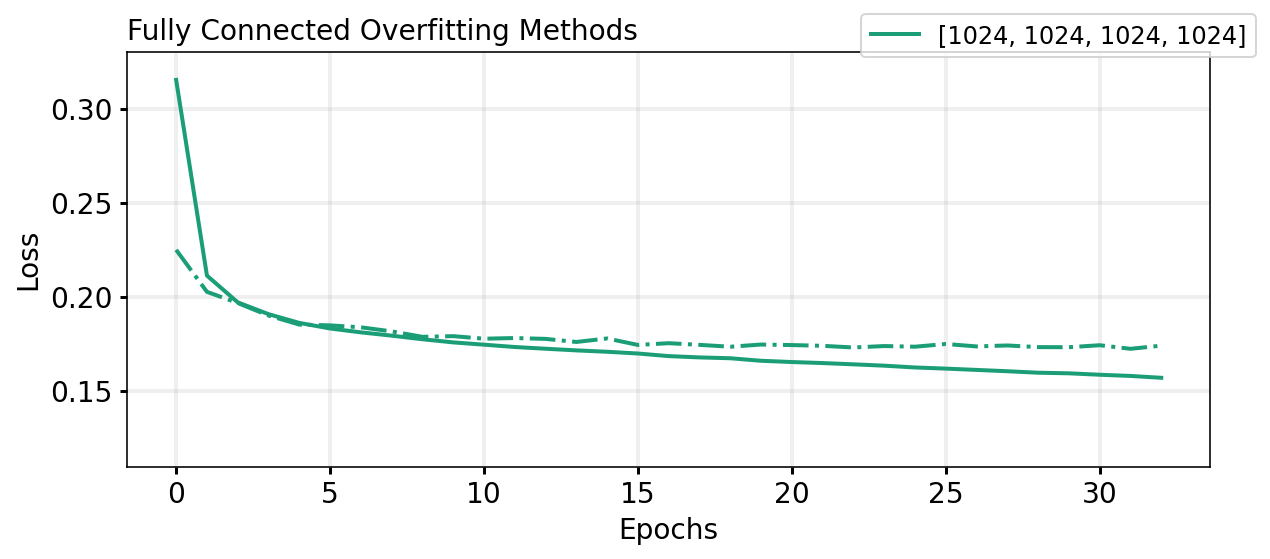

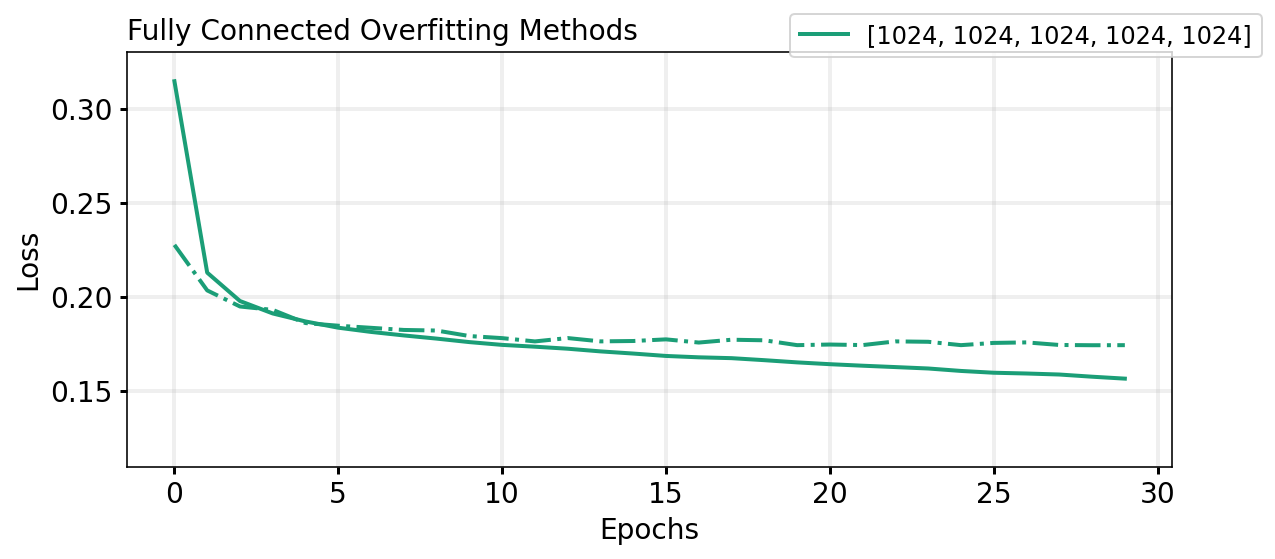

In [35]:
for h in df['hiddens'].unique():
    fig, ax = plt.subplots(figsize=(9,4))
    colors = plt.cm.Dark2(np.linspace(0,1,8)) # tab10
    linewidth = 2
    default_font = 14
    i = 0
    field = ['ml_total_test_rmse']

    trial = df.loc[(df['rtma_input_channels'] == '[0, 1, 2]') & 
                   (df['goes_input_channels'] == '[0, 1, 2, 3, 4, 5, 6, 7]') &
                   (df['hiddens'] == h)].reset_index(drop=True)

    t = trial.sort_values(field).index[0]
    ax.plot(np.asarray(literal_eval(trial.iloc[t][f'loss'])), color=colors[i], label=h, linewidth=linewidth)
    ax.plot(np.asarray(literal_eval(trial.iloc[t][f'val_loss'])), '-.', color=colors[i], linewidth=linewidth)
    i += 1
    ax.set_ylim((0.11, .33))
    ax.grid(True, alpha=0.2, linewidth=linewidth)
    ax.legend(loc='upper center', bbox_to_anchor=(0.86, 1.12), ncol=1, fontsize=12) # (0.5, 1.25)
    ax.set_ylabel('Loss', fontsize=default_font)
    ax.set_xlabel('Epochs', fontsize=default_font)
    ax.tick_params('both', width=1.5, labelsize=default_font)
    ax.set_title('Fully Connected Overfitting Methods', loc='left', fontsize=default_font)
    plt.tight_layout()
# plt.savefig(f'/home/stock/research/media/512_{len(layer)}_overfitting_results.pdf', dpi=300)

In [73]:
df = pd.read_csv(os.path.join(VOL, 'overfit_alley_fully_connected_model_temperature_dewpoint.csv'))

df[['hiddens', 'dropout', 
    'batchnorm', 'regularization', 'ml_total_test_rmse', 
    'ml_total_test_rmse_sfc']].sort_values(['ml_total_test_rmse']).head(5)

hiddens  dropout  batchnorm  regularization  \
8                  [512, 512]    False      False           False   
16            [512, 512, 512]    False      False           False   
24       [512, 512, 512, 512]    False      False           False   
18            [512, 512, 512]    False       True           False   
32  [512, 512, 512, 512, 512]    False      False           False   

    ml_total_test_rmse  ml_total_test_rmse_sfc  
8             3.346471                1.007025  
16            3.349131                0.999460  
24            3.358128                1.036796  
18            3.361639                1.185167  
32            3.381110                1.089334

[512, 512, 512, 512, 512]


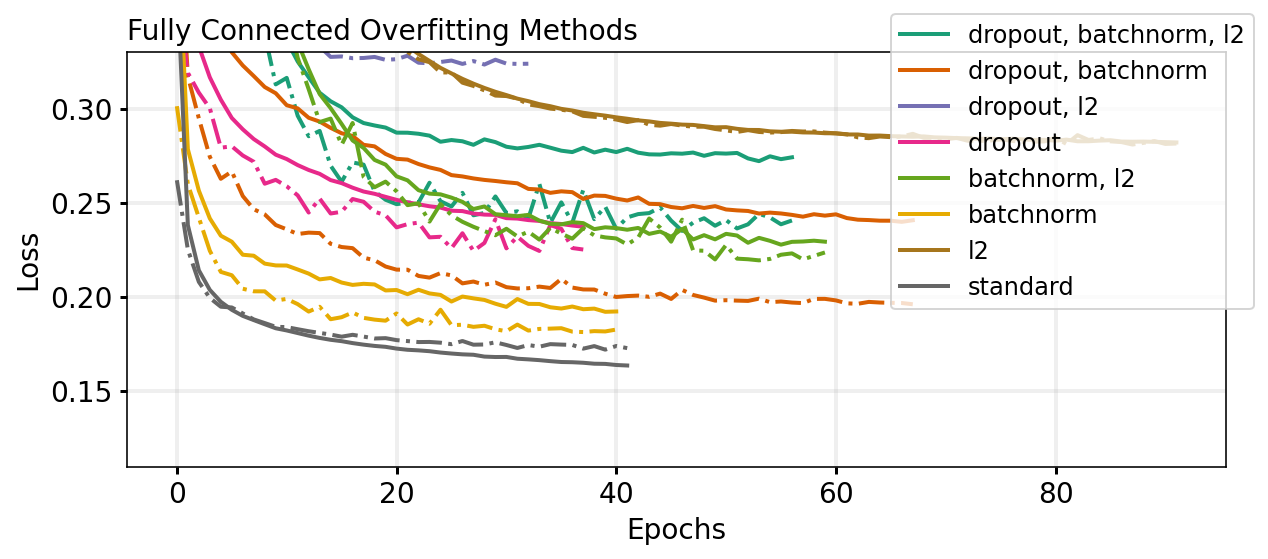

In [68]:
fig, ax = plt.subplots(figsize=(9,4))

units = 512
colors = plt.cm.Dark2(np.linspace(0,1,8)) # tab10
linewidth = 2
default_font = 14
i = 0
layer = [units]*5
field = ['ml_total_test_rmse']
for dropout, batchnorm, regularization in list(itertools.product([True, False], 
                                                                 [True, False], 
                                                                 [True, False])):
    trial = df.loc[(df['dropout'] == dropout) &
                   (df['batchnorm'] == batchnorm) &
                   (df['regularization'] == regularization) &
                   (df['hiddens'] == str(layer))].reset_index(drop=True)
    t = trial.sort_values(field).index[0]
    temp = list(itertools.compress(['dropout', 'batchnorm', 'l2'],
                                   [dropout, batchnorm, regularization]))
    label = ', '.join(temp) if len(temp) else 'standard'
    ax.plot(np.asarray(literal_eval(trial.iloc[t][f'loss'])), color=colors[i], label=label, linewidth=linewidth)
    ax.plot(np.asarray(literal_eval(trial.iloc[t][f'val_loss'])), '-.', color=colors[i], linewidth=linewidth)
    
    i += 1
    
print(layer)

ax.set_ylim((0.11, .33))
ax.grid(True, alpha=0.2, linewidth=linewidth)
ax.legend(loc='upper center', bbox_to_anchor=(0.86, 1.12), ncol=1, fontsize=12) # (0.5, 1.25)
ax.set_ylabel('Loss', fontsize=default_font)
ax.set_xlabel('Epochs', fontsize=default_font)
ax.tick_params('both', width=1.5, labelsize=default_font)
ax.set_title('Fully Connected Overfitting Methods', loc='left', fontsize=default_font)
plt.tight_layout()
# plt.savefig(f'/home/stock/research/media/512_{len(layer)}_overfitting_results.pdf', dpi=300)

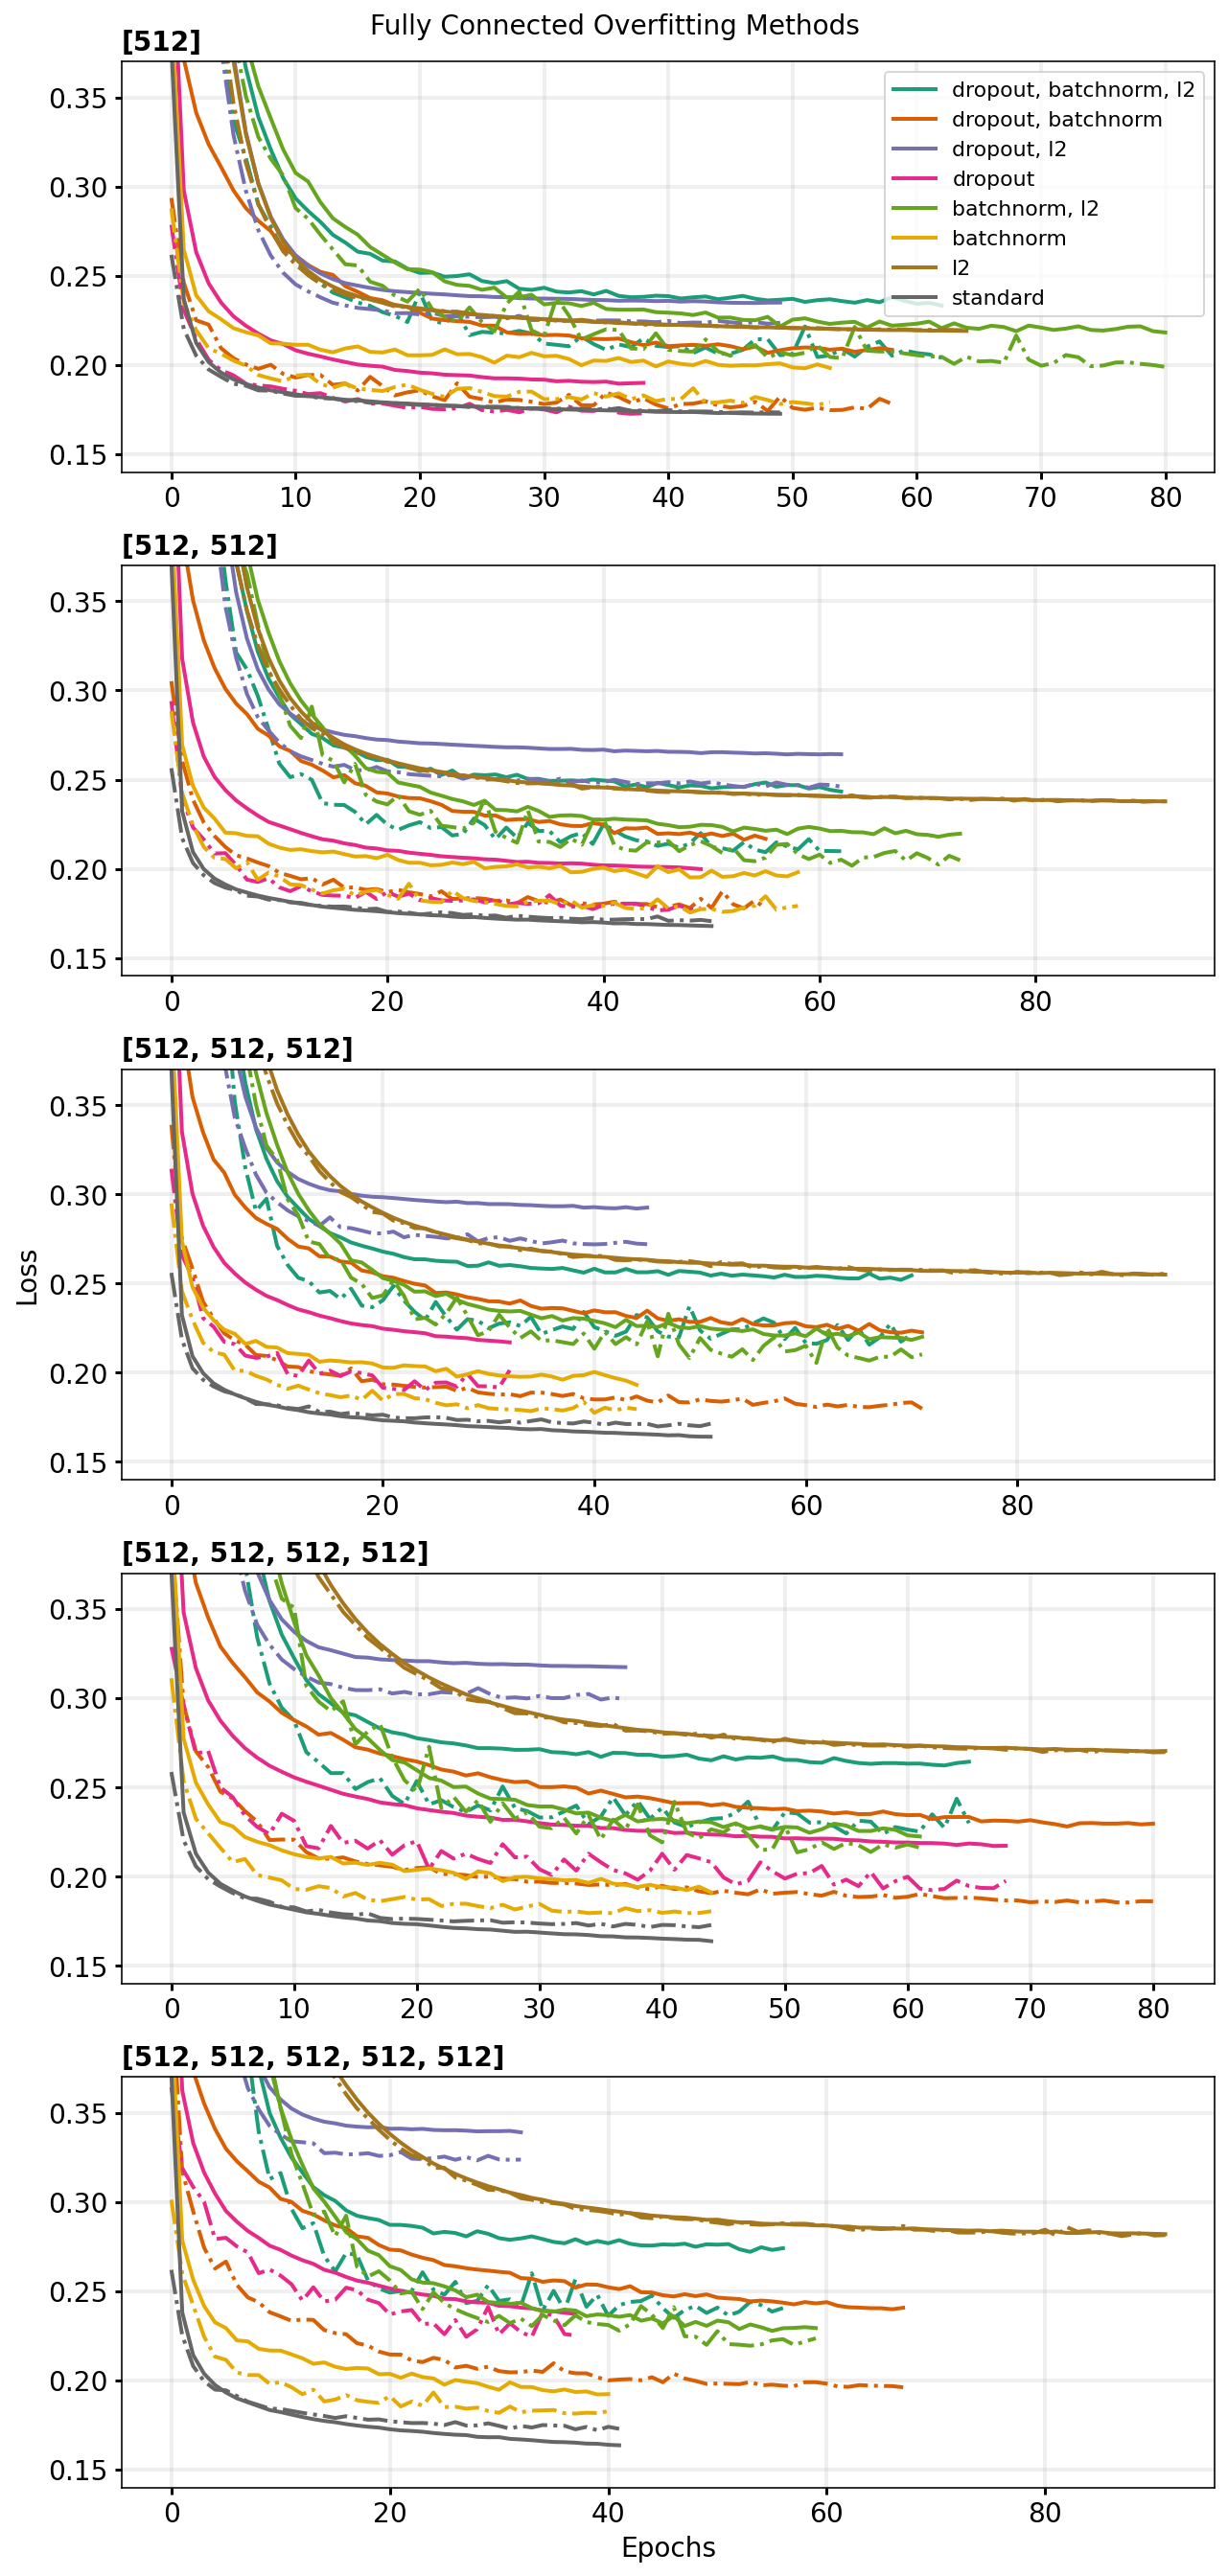

In [84]:
fig, axs = plt.subplots(5, 1, figsize=(9,19))
axs = np.ravel(axs)

units = 512
colors = plt.cm.Dark2(np.linspace(0,1,8)) # tab10
linewidth = 2
default_font = 14
i = 0
field = ['ml_total_test_rmse']
for i in range(5):
    layer = [units]*(i+1)
    j = 0
    for dropout, batchnorm, regularization in list(itertools.product([True, False], 
                                                                     [True, False], 
                                                                     [True, False])):
        trial = df.loc[(df['dropout'] == dropout) &
                       (df['batchnorm'] == batchnorm) &
                       (df['regularization'] == regularization) &
                       (df['hiddens'] == str(layer))].reset_index(drop=True)
        t = trial.sort_values(field).index[0]
        temp = list(itertools.compress(['dropout', 'batchnorm', 'l2'],
                                       [dropout, batchnorm, regularization]))
        if i == 0:
            label = ', '.join(temp) if len(temp) else 'standard'
        else:
            label = None
        axs[i].plot(np.asarray(literal_eval(trial.iloc[t][f'loss'])), color=colors[j], label=label, linewidth=linewidth)
        axs[i].plot(np.asarray(literal_eval(trial.iloc[t][f'val_loss'])), '-.', color=colors[j], linewidth=linewidth)
        j += 1
    
    axs[i].set_ylim((0.14, .37))
    axs[i].grid(True, alpha=0.2, linewidth=linewidth)
    axs[i].tick_params('both', width=1.5, labelsize=default_font)
    axs[i].set_title(str(layer), weight='bold', loc='left', fontsize=default_font)

axs[2].set_ylabel('Loss', fontsize=default_font)   
axs[0].legend(loc='upper right', ncol=1, fontsize=11) # (0.5, 1.25)
axs[4].set_xlabel('Epochs', fontsize=default_font)

fig.suptitle('Fully Connected Overfitting Methods', fontsize=default_font)
fig.tight_layout()
plt.savefig(f'/home/stock/research/media/{str(units)}_overfitting_results.pdf', dpi=300)

In [46]:
RAPtest.shape

(5733, 256, 4)

In [ ]:

ml.rmse(Y[:, :surface_error], T[:, :surface_error])

# Convolutional

In [19]:
df[['hiddens', 'n_units_in_conv_layers', 'loss_f', 'ml_total_test_rmse', 'ml_total_test_rmse_sfc', 
    'ml_temperature_test_mean_rmse', 'ml_temperature_test_mean_rmse_sfc',
    'ml_dewpoint_test_mean_rmse', 'ml_dewpoint_test_mean_rmse_sfc']]

hiddens n_units_in_conv_layers loss_f  ml_total_test_rmse  \
0  [512, 256]          [32, 64, 128]  wloss            3.336962   
1  [512, 256]          [32, 64, 128]    MSE            3.284841   
2  [512, 256]          [32, 64, 128]    MAE            3.292365   
3         [0]          [32, 64, 128]  wloss            3.385186   
4         [0]          [32, 64, 128]    MSE            3.320750   
5         [0]          [32, 64, 128]    MAE            3.377446   

   ml_total_test_rmse_sfc  ml_temperature_test_mean_rmse  \
0                0.996011                       1.014845   
1                1.089410                       1.046953   
2                1.018432                       1.004662   
3                0.985867                       0.987808   
4                1.001234                       0.998592   
5                0.986508                       0.987977   

   ml_temperature_test_mean_rmse_sfc  ml_dewpoint_test_mean_rmse  \
0                           1.027271                    4.608766   
1                           1.194086                    4.525953   
2                           1.076873                    4.546426   
3                           1.005981                    4.684357   
4                           1.055500                    4.588854   
5                           1.022007                    4.673134   

   ml_dewpoint_test_mean_rmse_sfc  
0                        2.864812  
1                        2.943321  
2                        2.929182  
3                        2.894105  
4                        2.909799  
5                        2.919047

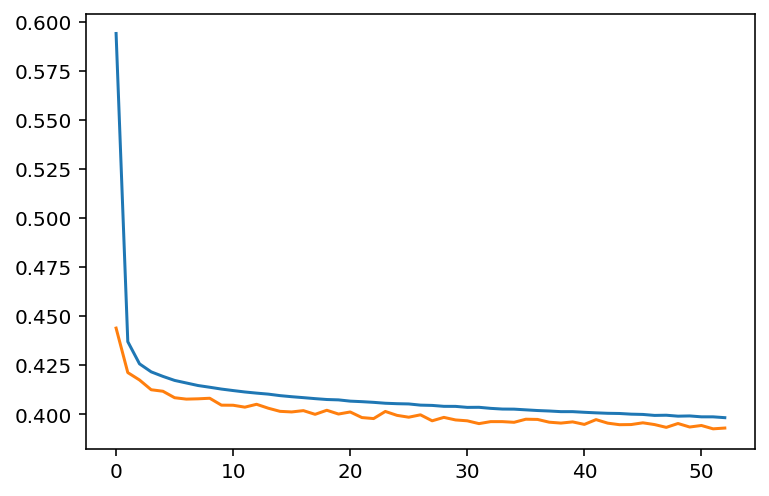

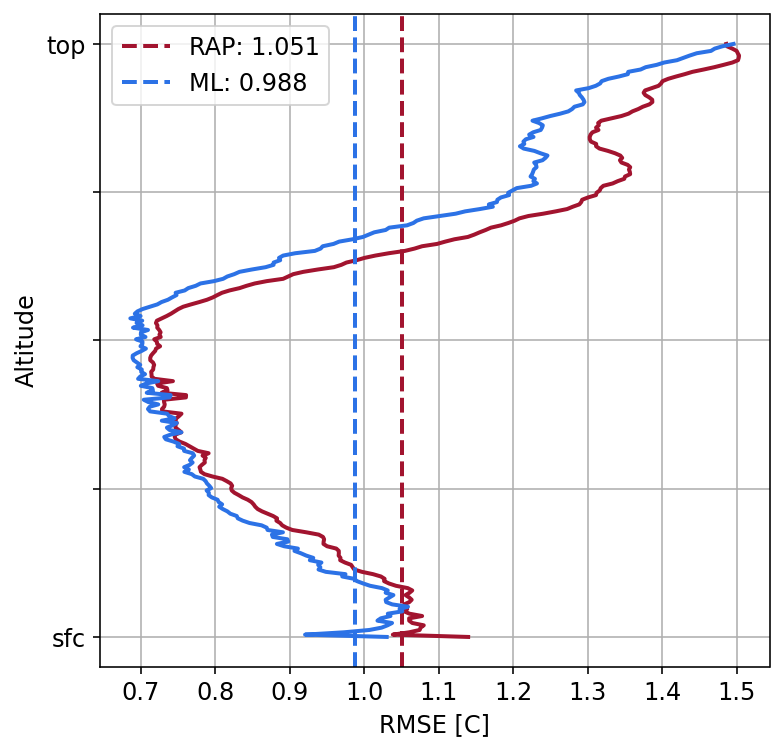

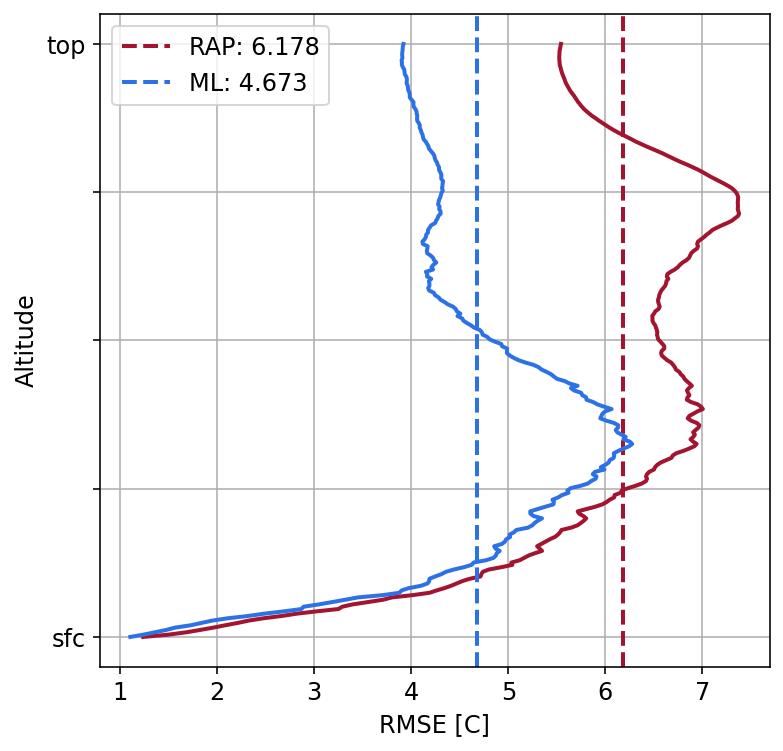

In [21]:
df = pd.read_csv(os.path.join(VOL, 'test_alley_multi_cnn_model_temperature_dewpoint.csv'))
# replace [] with [0]
# df.loc[(df['hiddens'] == '[]'), 'hiddens'] = '[0]'

i = 5 # df.sort_values(['ml_temperature_test_mean_rmse']).index[0]
fig, ax = plt.subplots()
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_test_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_test_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_test_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_test_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)

In [91]:
df = pd.read_csv(os.path.join(VOL, 'alley_multi_cnn_model_temperature_dewpoint.csv'))

In [92]:
for r in ['[]', '[0, 1, 2]']:
    for g in ['[]', '[0, 1, 2, 3, 4, 5, 6, 7]']:
        print(r, g)
        trial = df.loc[(df['rtma_input_channels'] == r) & 
                       (df['goes_input_channels'] == g) &
                       (df['hiddens'] == '[512, 256]') &
                       (df['n_units_in_conv_layers'] == '[32, 64, 128, 256, 512]')].sort_values('ml_total_test_rmse').head(1)

        print(f"{trial['ml_temperature_test_mean_rmse'].values[0]:.3f} & \
{trial['ml_temperature_test_mean_rmse_sfc'].values[0]:.3f} & \
{trial['ml_dewpoint_test_mean_rmse'].values[0]:.3f} & \
{trial['ml_dewpoint_test_mean_rmse_sfc'].values[0]:.3f} && ")
        
        print(f"{trial['ml_total_test_rmse'].values[0]:.3f} & \
{trial['ml_total_test_rmse_sfc'].values[0]:.3f} && ")

[] []
1.013 & 1.031 & 4.687 & 2.858 && 
3.391 & 0.994 && 
[] [0, 1, 2, 3, 4, 5, 6, 7]
1.015 & 1.037 & 4.534 & 2.862 && 
3.286 & 0.991 && 
[0, 1, 2] []
1.017 & 1.018 & 4.704 & 2.876 && 
3.403 & 0.995 && 
[0, 1, 2] [0, 1, 2, 3, 4, 5, 6, 7]
1.007 & 1.014 & 4.557 & 2.878 && 
3.300 & 0.991 && 


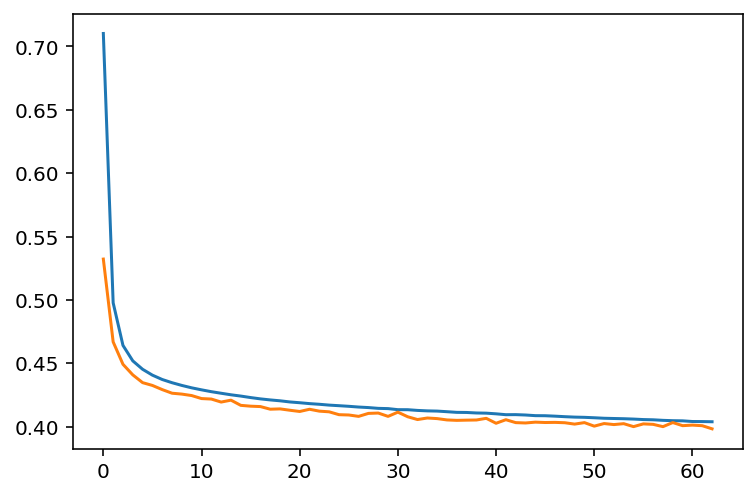

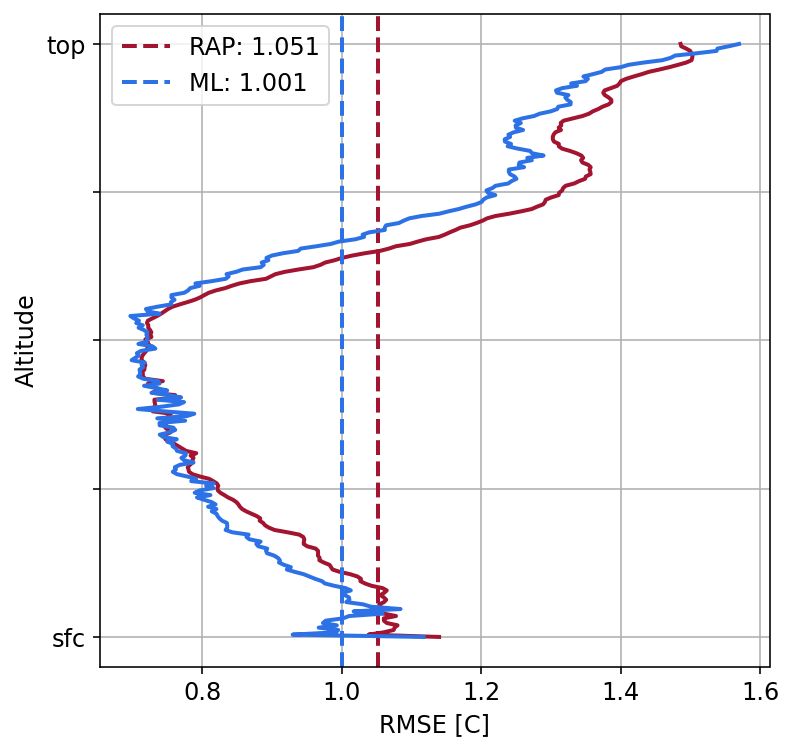

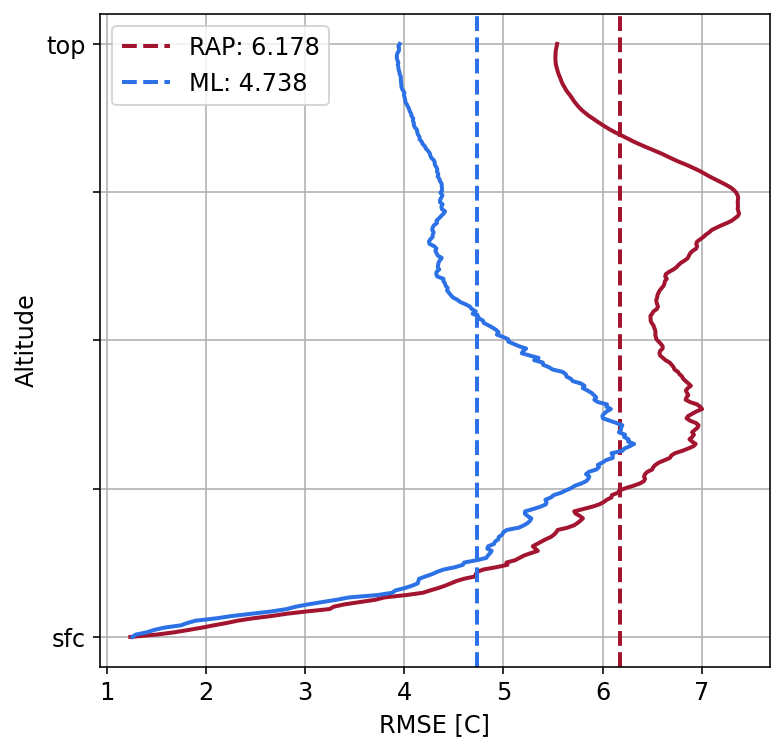

In [60]:
# df.sort_values(['ml_temperature_test_mean_rmse']).index[0]
i = df.sort_values(['ml_total_test_rmse_sfc']).index[0]
fig, ax = plt.subplots()
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_test_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_test_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_test_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_test_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)

In [66]:
results

OrderedDict([('[0]|[16, 32, 64]', (1.079075645820976, 0.0030529124983916097)),
             ('[0]|[32, 64, 128]', (1.0561517904181292, 0.002144675889749697)),
             ('[0]|[64, 128, 256]',
              (1.0417666932799348, 0.003343220795632971)),
             ('[0]|[8, 16, 32, 64, 128]',
              (1.2047126239947057, 0.014799990901830574)),
             ('[0]|[16, 32, 64, 128, 256]',
              (1.1811865393768868, 0.010279868896567975)),
             ('[0]|[32, 64, 128, 256, 512]',
              (1.1363127330798815, 0.009502202875601403)),
             ('[0]|[32, 32, 32, 64, 64, 64]',
              (1.3339213531182348, 0.019384521901913834)),
             ('[0]|[32, 32, 64, 64, 128, 128]',
              (1.2713467462445582, 0.012679989162173975)),
             ('[0]|[64, 64, 64, 128, 128, 128]',
              (1.2694325033134513, 0.011635158741118657)),
             ('[256]|[16, 32, 64]',
              (1.1831377300874242, 0.009488390732814959)),
             ('[256]|[3

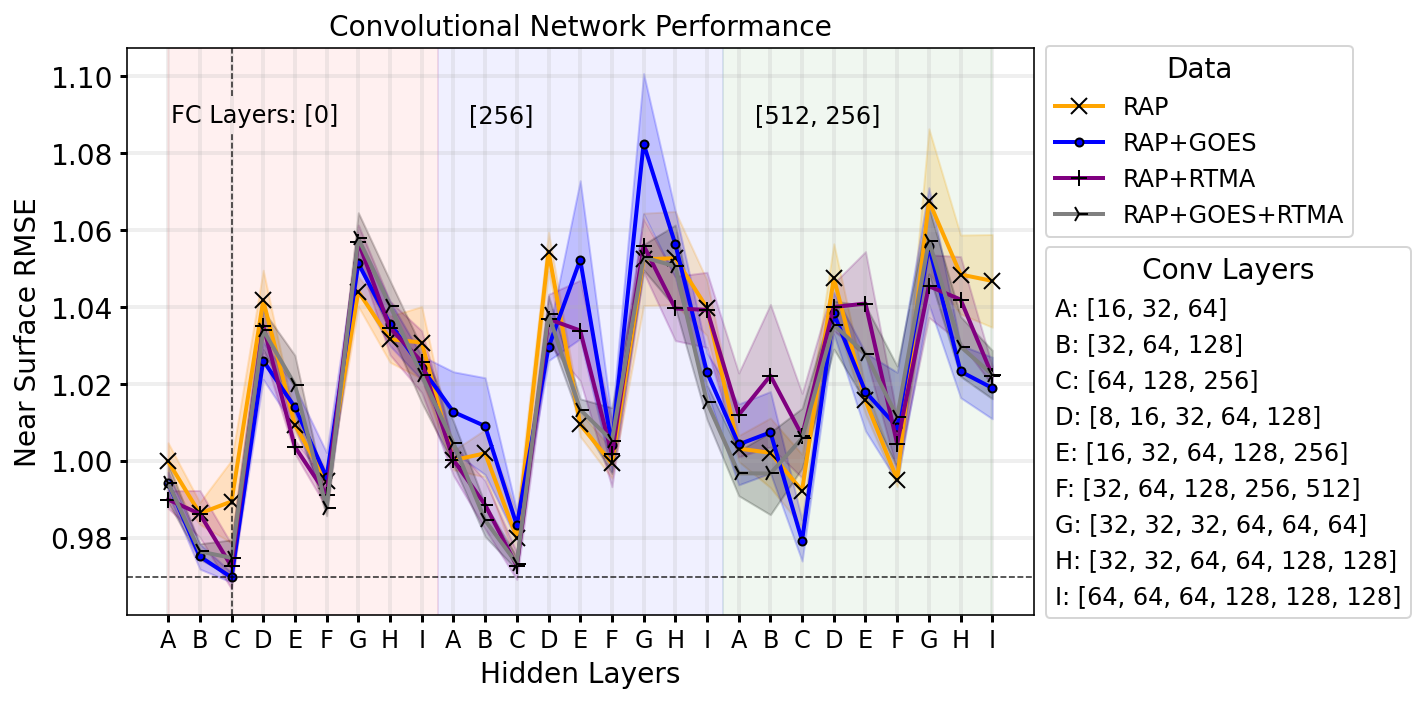

In [61]:
def trial_results(rtma_input_channels, goes_input_channels, dropout):
    results = dict()
    field = ['ml_total_test_rmse_sfc'] # ['ml_total_test_rmse']
    for h in df['hiddens'].unique():
        for c in df['n_units_in_conv_layers'].unique():
            trial = df.loc[(df['rtma_input_channels'] == rtma_input_channels) & 
                           (df['goes_input_channels'] == goes_input_channels) &
                           (df['dropout'] == dropout) &
                           (df['hiddens'] == h) &
                           (df['n_units_in_conv_layers'] == c)]

            trial_t_mean = trial[field].mean().values[0]
            trial_t_sem = trial[field].sem().values[0]
            results[h+'|'+c] = (trial_t_mean, trial_t_sem)
            
    return OrderedDict(sorted(results.items(), key=lambda t: len(t[0].split('|')[0])))

fig, ax = plt.subplots(figsize=(10,5))

linewidth = 2

span_alpha = 0.06
y = 1.088 # 3.53 
ax.axvspan(0, 8.5, alpha=span_alpha, color='red')
ax.text(0.1, y, 'FC Layers: [0]', fontsize=12)
ax.axvspan(8.5, 17.5, alpha=span_alpha, color='blue')
ax.text(9.5, y, '[256]', fontsize=12)
ax.axvspan(17.5, 26, alpha=span_alpha, color='green')
ax.text(18.5, y, '[512, 256]', fontsize=12)

results = trial_results('[]', '[]', False)
mean_sem = np.array(list(results.values()))
min_err = min(mean_sem[:,0])
min_err_i = np.argmin(mean_sem[:,0])

ax.plot(range(len(results)), mean_sem[:,0], '-x', markersize=8, color='orange', 
        markeredgecolor='k', linewidth=linewidth, label='RAP')
ax.fill_between(range(len(results)), mean_sem[:,0] - mean_sem[:,1], 
                mean_sem[:,0] + mean_sem[:,1],
                color='orange', alpha=0.2)

results = trial_results('[]', '[0, 1, 2, 3, 4, 5, 6, 7]', False)
mean_sem = np.array(list(results.values()))
if min(mean_sem[:,0]) < min_err:
    min_err = min(mean_sem[:,0])
    min_err_i = np.argmin(mean_sem[:,0])

ax.plot(range(len(results)), mean_sem[:,0], '-', marker='.', markersize=8, color='blue', 
        markeredgecolor='k', linewidth=linewidth, label='RAP+GOES')
ax.fill_between(range(len(results)), mean_sem[:,0] - mean_sem[:,1], 
                mean_sem[:,0] + mean_sem[:,1],
                color='blue', alpha=0.2)

results = trial_results('[0, 1, 2]', '[]', False)
mean_sem = np.array(list(results.values()))
if min(mean_sem[:,0]) < min_err:
    min_err = min(mean_sem[:,0])
    min_err_i = np.argmin(mean_sem[:,0])
    
ax.plot(range(len(results)), mean_sem[:,0], '-+', markersize=8, color='purple',
        markeredgecolor='k', linewidth=linewidth, label='RAP+RTMA')
ax.fill_between(range(len(results)), mean_sem[:,0] - mean_sem[:,1], 
                mean_sem[:,0] + mean_sem[:,1],
                color='purple', alpha=0.2)

results = trial_results('[0, 1, 2]', '[0, 1, 2, 3, 4, 5, 6, 7]', False)
mean_sem = np.array(list(results.values()))
if min(mean_sem[:,0]) < min_err:
    min_err = min(mean_sem[:,0])
    min_err_i = np.argmin(mean_sem[:,0])

ax.plot(range(len(results)), mean_sem[:,0], '-4', markersize=9, color='gray', 
        markeredgecolor='k', linewidth=linewidth, label='RAP+GOES+RTMA')
ax.fill_between(range(len(results)), mean_sem[:,0] - mean_sem[:,1], 
                mean_sem[:,0] + mean_sem[:,1],
                color='black', alpha=0.2)

# minimum 
ax.axhline(y=min_err, color='k', linestyle='--', alpha=0.8, linewidth=0.8)
ax.axvline(x=min_err_i, ymin=0.915, color='k', linestyle='--', alpha=0.8, linewidth=0.8)
ax.axvline(x=min_err_i, ymax=0.85, color='k', linestyle='--', alpha=0.8, linewidth=0.8)

labels = np.tile([i for i in string.ascii_uppercase[:9]], 3) # list(results.keys())
default_font = 14

ax.set_xticks(range(len(results)))
ax.set_xticklabels(labels);
ax.tick_params(axis='x', width=1.5, labelsize=12, rotation=0)
ax.tick_params(axis='y', width=1.5, labelsize=default_font)
ax.set_ylabel('Near Surface RMSE', fontsize=default_font); ax.set_xlabel('Hidden Layers', fontsize=default_font)
ax.set_title('Convolutional Network Performance', fontsize=default_font)
ax.grid(True, alpha=0.2, linewidth=linewidth)

layers = df['n_units_in_conv_layers'].unique()
letters = [i for i in string.ascii_uppercase[:9]]
labels = [': '.join([s[0], s[1]]) for s in list(zip(letters, layers))]
proxies = [matplotlib.lines.Line2D([],[], markerfacecolor='w', markeredgecolor='w') for _ in range(len(labels))]

legend1 = plt.legend(bbox_to_anchor=(1.0, 1.025), ncol=1, fontsize=12, title='Data')
ax.add_artist(legend1)
plt.setp(legend1.get_title(),fontsize=default_font)

legend2 = ax.legend(proxies, labels, handletextpad=0, handlelength=0, bbox_to_anchor=(1.0, 0.67), 
                    ncol=1, fontsize=12, title='Conv Layers');
plt.setp(legend2.get_title(),fontsize=default_font)
fig.tight_layout()
plt.savefig('/home/stock/research/media/cnn_rmse_results_sfc_wmae_line.pdf', dpi=300)

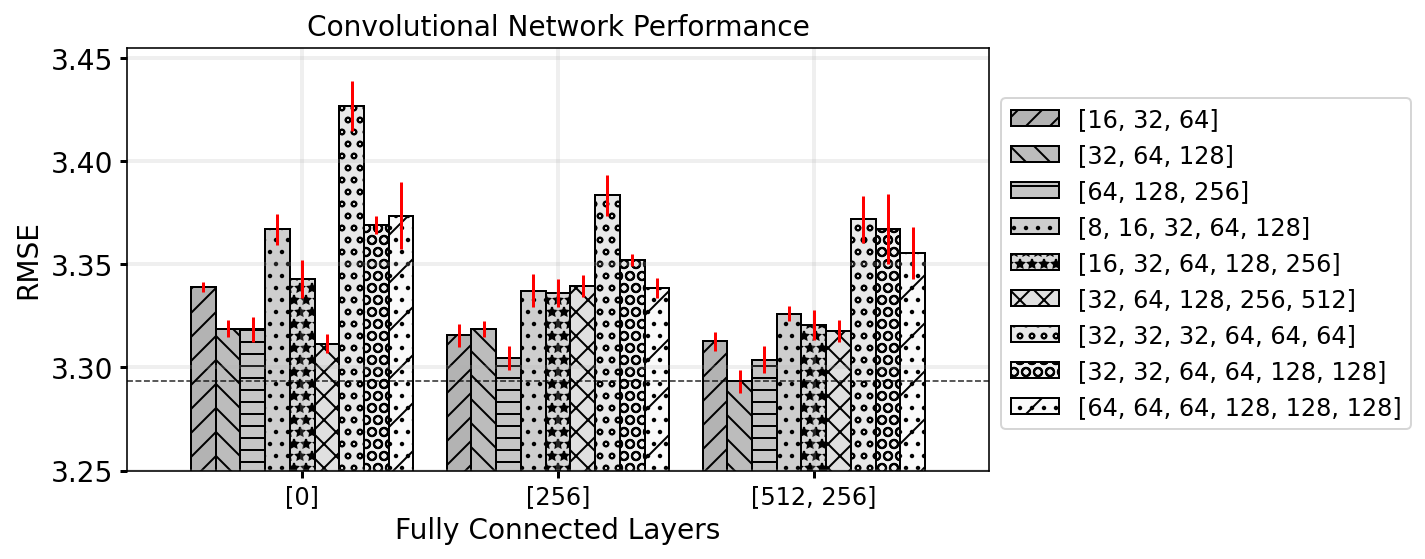

In [35]:
groups = []
group_values = []
for c in df['n_units_in_conv_layers'].unique():
    groups.append(c)
    l = []
    for key in results.keys():
        if c in key:
            l.append(results[key])
    group_values.append(l)
    
group_values = np.array(group_values)

columns = ['A', 'Ae', 'B', 'Be', 'C', 'Ce', 'D', 'De', 'E',
           'Ee', 'F', 'Fe', 'G', 'Ge', 'H', 'He', 'I', 'Ie']
dd = pd.DataFrame(np.array([list(group_values[:,i,:].flatten()) for i in range(3)]), 
                  columns = columns, index=['[0]', '[256]', '[512, 256]'])

colors = plt.cm.gray(np.linspace(0.70,0.98,9)) # tab10

fig, ax = plt.subplots(figsize=(10,4))

dd[[i for i in string.ascii_uppercase[:9]]].plot(kind='bar',yerr=dd[['Ae', 'Be', 'Ce', 'De', 'Ee',
                                                                           'Fe', 'Ge', 'He', 'Ie']].values.T, 
                                                       rot=0, error_kw=dict(ecolor='r'),width=0.87, 
                                                       ax=ax, color=colors, edgecolor='k');
bars = ax.patches
patterns = ['//', '\\\\', '--', '..', '**', 'xx', 'oo', 'OO', '/..']
hatches = [p for p in patterns for i in range(len(dd))]

for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)


ax.set_ylim((3.25, 3.455))

ax.tick_params(axis='x', width=1.5, labelsize=12, rotation=0)
ax.tick_params(axis='y', width=1.5, labelsize=default_font)
ax.set_ylabel('RMSE', fontsize=default_font); ax.set_xlabel('Fully Connected Layers', fontsize=default_font)
ax.set_title('Convolutional Network Performance', fontsize=default_font)
ax.grid(True, alpha=0.2, linewidth=linewidth)
ax.legend(groups, bbox_to_anchor=(1.0, 0.91), ncol=1, fontsize=12)

ax.axhline(y=group_values[:,:,0].min(), color='k', linestyle='--', alpha=0.8, linewidth=0.8, label=None);

fig.tight_layout()
plt.savefig('/home/stock/research/media/cnn_rmse_results_bar.pdf', dpi=300)

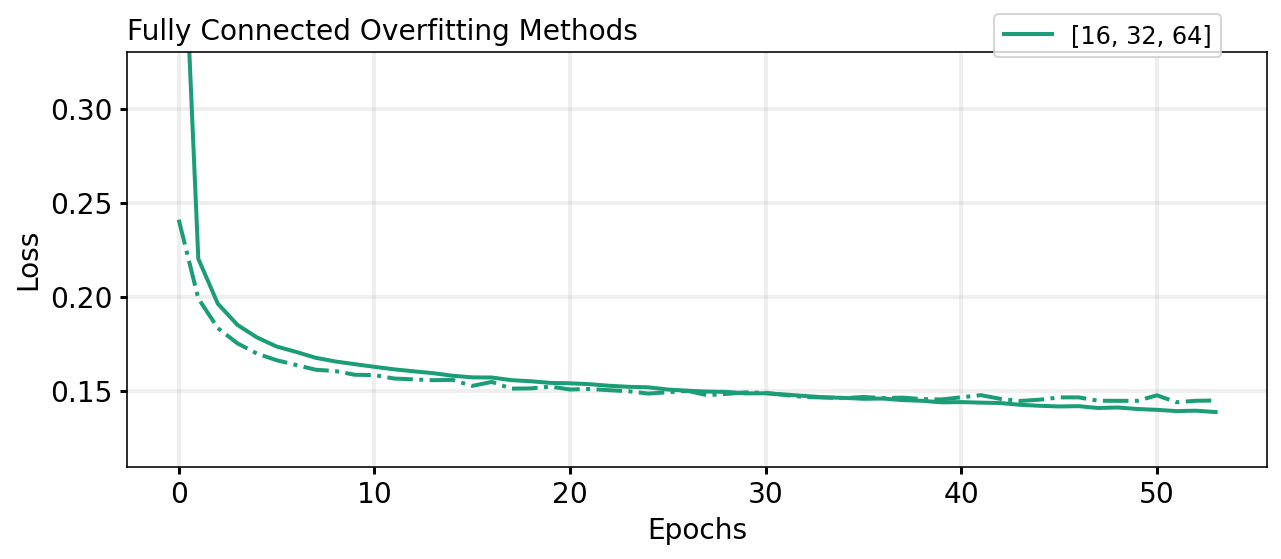

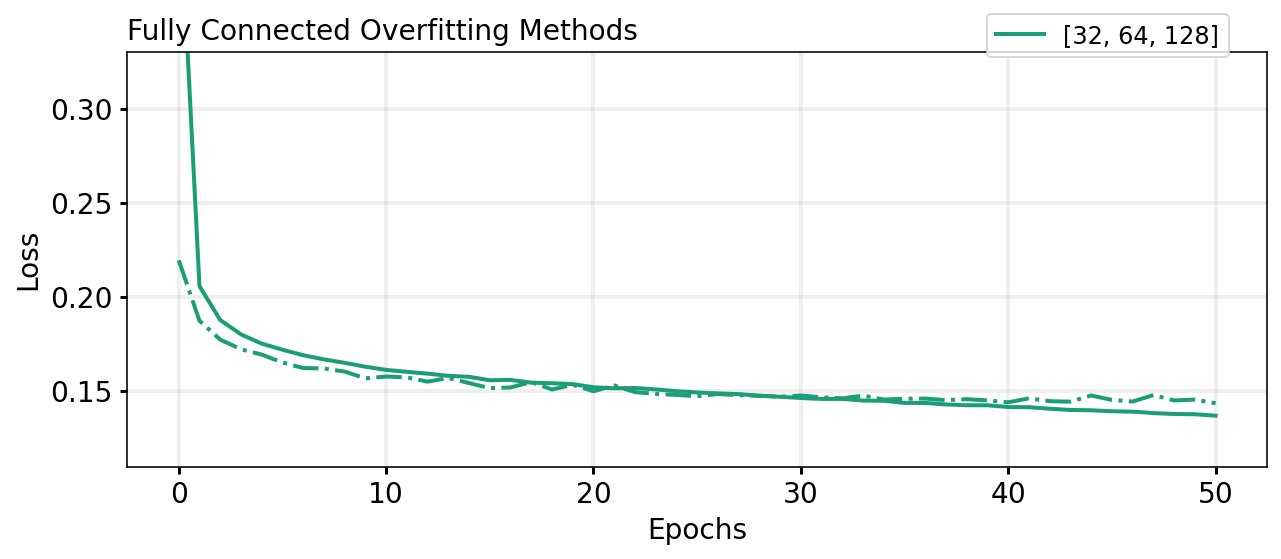

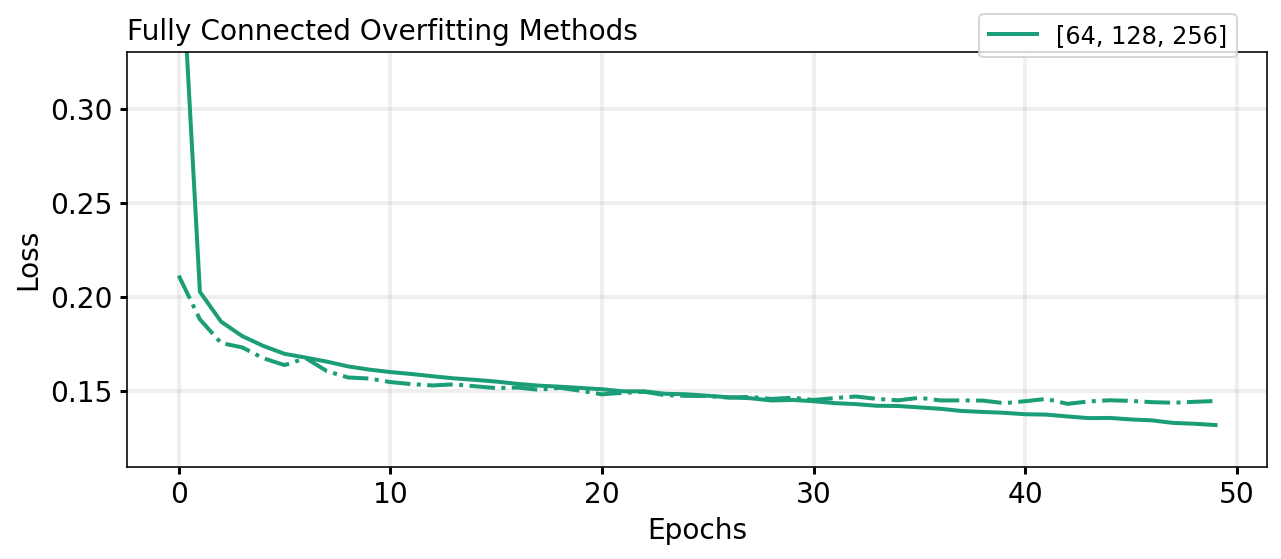

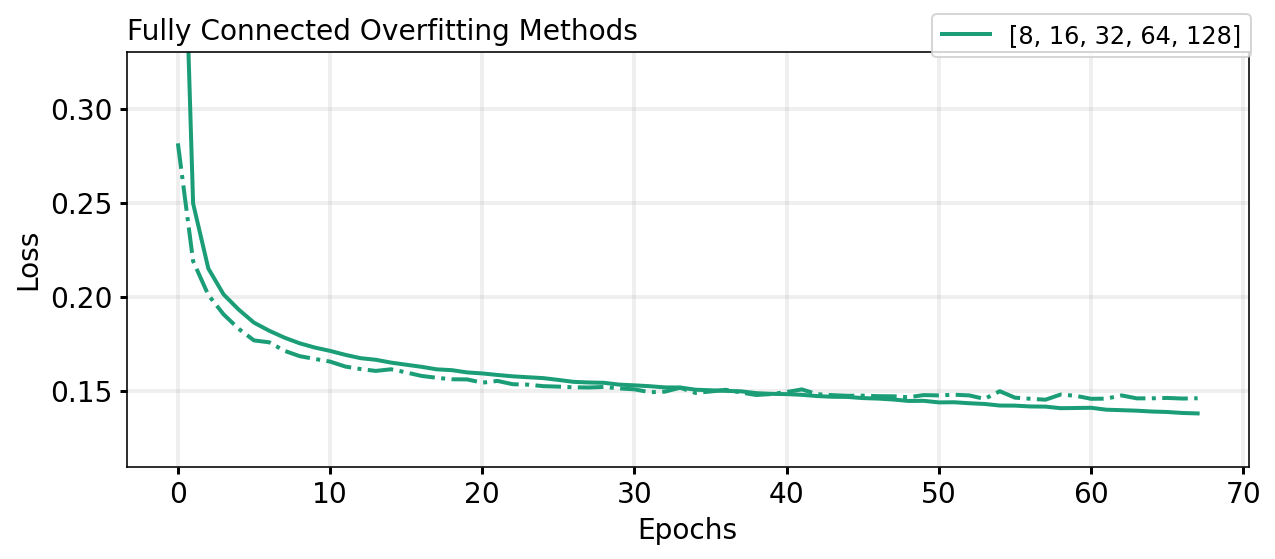

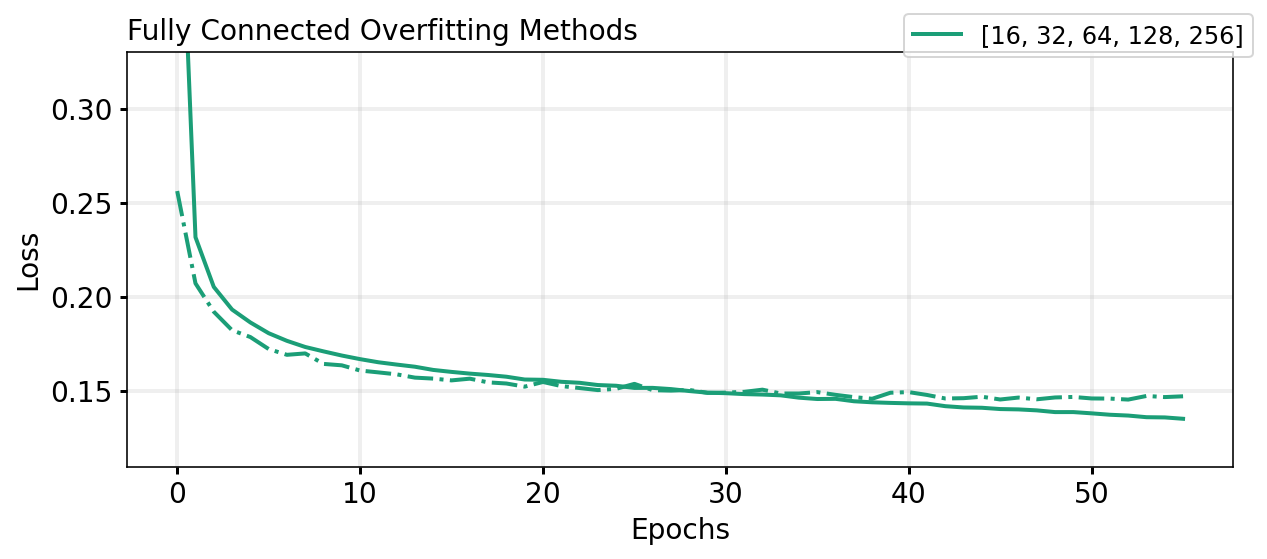

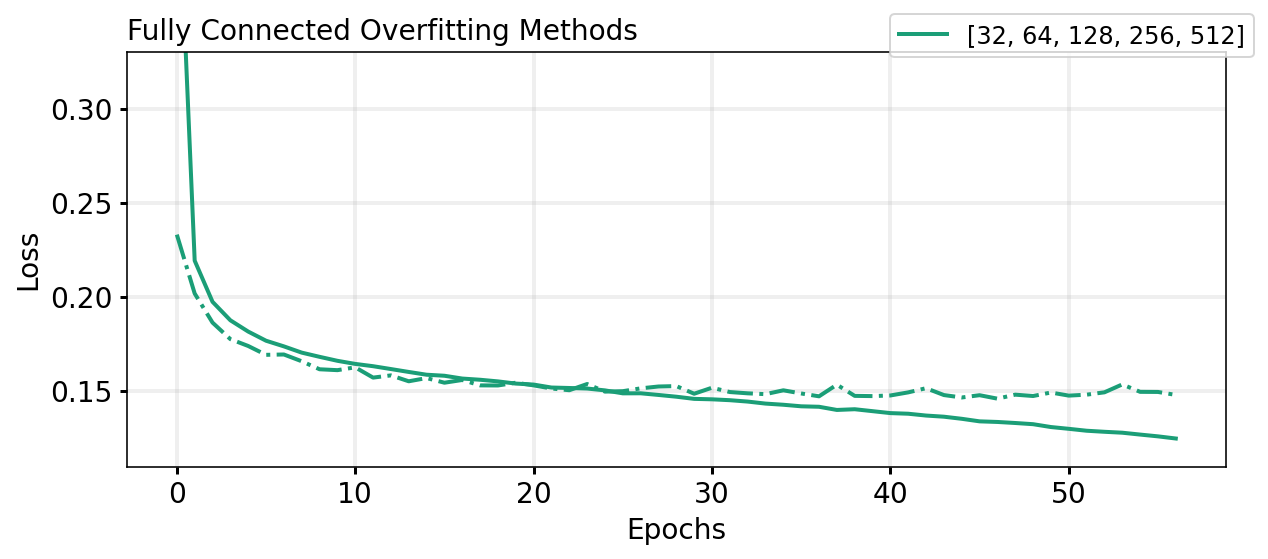

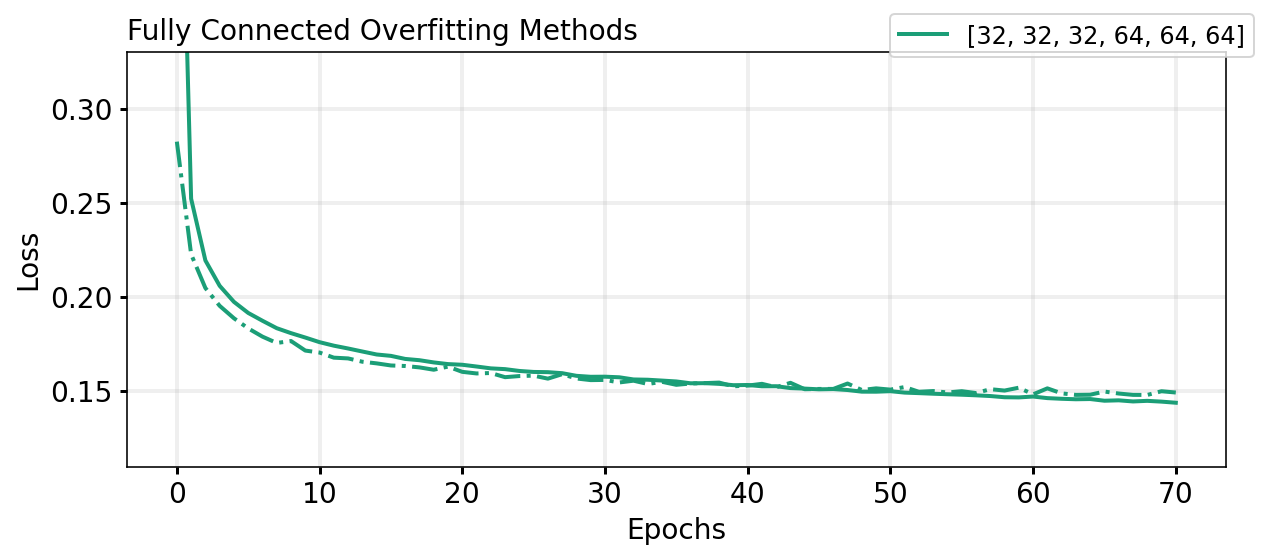

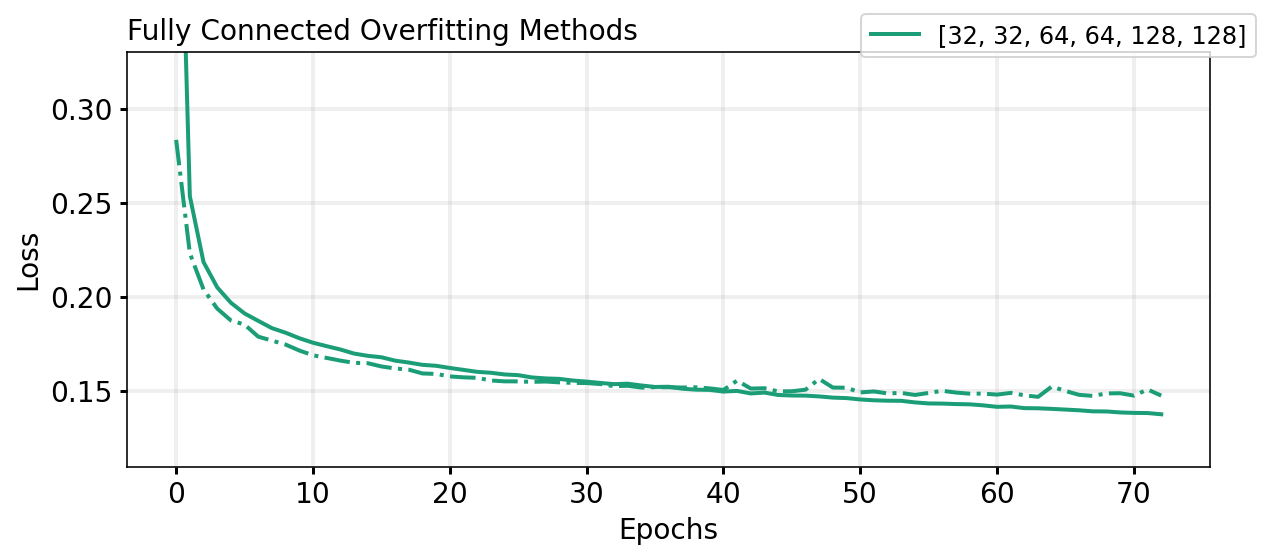

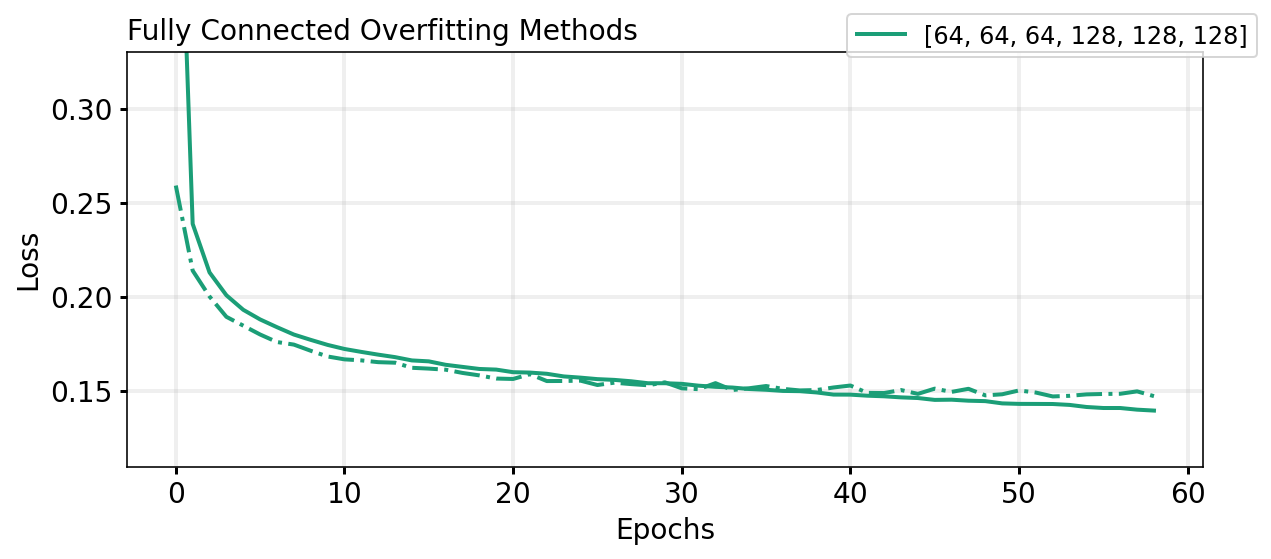

In [24]:
for c in df['n_units_in_conv_layers'].unique():
    fig, ax = plt.subplots(figsize=(9,4))
    colors = plt.cm.Dark2(np.linspace(0,1,8)) # tab10
    linewidth = 2
    default_font = 14
    i = 0
    field = ['ml_total_test_rmse']

    trial = df.loc[(df['rtma_input_channels'] == '[0, 1, 2]') & 
                   (df['goes_input_channels'] == '[0, 1, 2, 3, 4, 5, 6, 7]') &
                   (df['n_units_in_conv_layers'] == c) &
                   (df['hiddens'] == '[512, 256]')].reset_index(drop=True)

    t = trial.sort_values(field).index[0]
    ax.plot(np.asarray(literal_eval(trial.iloc[t][f'loss'])), color=colors[i], label=c, linewidth=linewidth)
    ax.plot(np.asarray(literal_eval(trial.iloc[t][f'val_loss'])), '-.', color=colors[i], linewidth=linewidth)
    i += 1
    ax.set_ylim((0.11, .33))
    ax.grid(True, alpha=0.2, linewidth=linewidth)
    ax.legend(loc='upper center', bbox_to_anchor=(0.86, 1.12), ncol=1, fontsize=12) # (0.5, 1.25)
    ax.set_ylabel('Loss', fontsize=default_font)
    ax.set_xlabel('Epochs', fontsize=default_font)
    ax.tick_params('both', width=1.5, labelsize=default_font)
    ax.set_title('Fully Connected Overfitting Methods', loc='left', fontsize=default_font)
    plt.tight_layout()
# plt.savefig(f'/home/stock/research/media/512_{len(layer)}_overfitting_results.pdf', dpi=300)

In [72]:
df = pd.read_csv(os.path.join(VOL, 'overfit_alley_multi_cnn_model_temperature_dewpoint.csv'))
df[['hiddens', 'n_units_in_conv_layers', 'dropout', 
    'batchnorm', 'regularization', 'ml_total_test_rmse']].sort_values(['ml_total_test_rmse']).head(5)

hiddens   n_units_in_conv_layers  dropout  batchnorm  regularization  \
16         [0]           [64, 128, 256]    False      False           False   
0   [512, 256]           [64, 128, 256]    False      False           False   
24         [0]  [32, 64, 128, 256, 512]    False      False           False   
8   [512, 256]  [32, 64, 128, 256, 512]    False      False           False   
20         [0]           [64, 128, 256]     True      False           False   

    ml_total_test_rmse  
16            3.299723  
0             3.302305  
24            3.308388  
8             3.313555  
20            3.317258

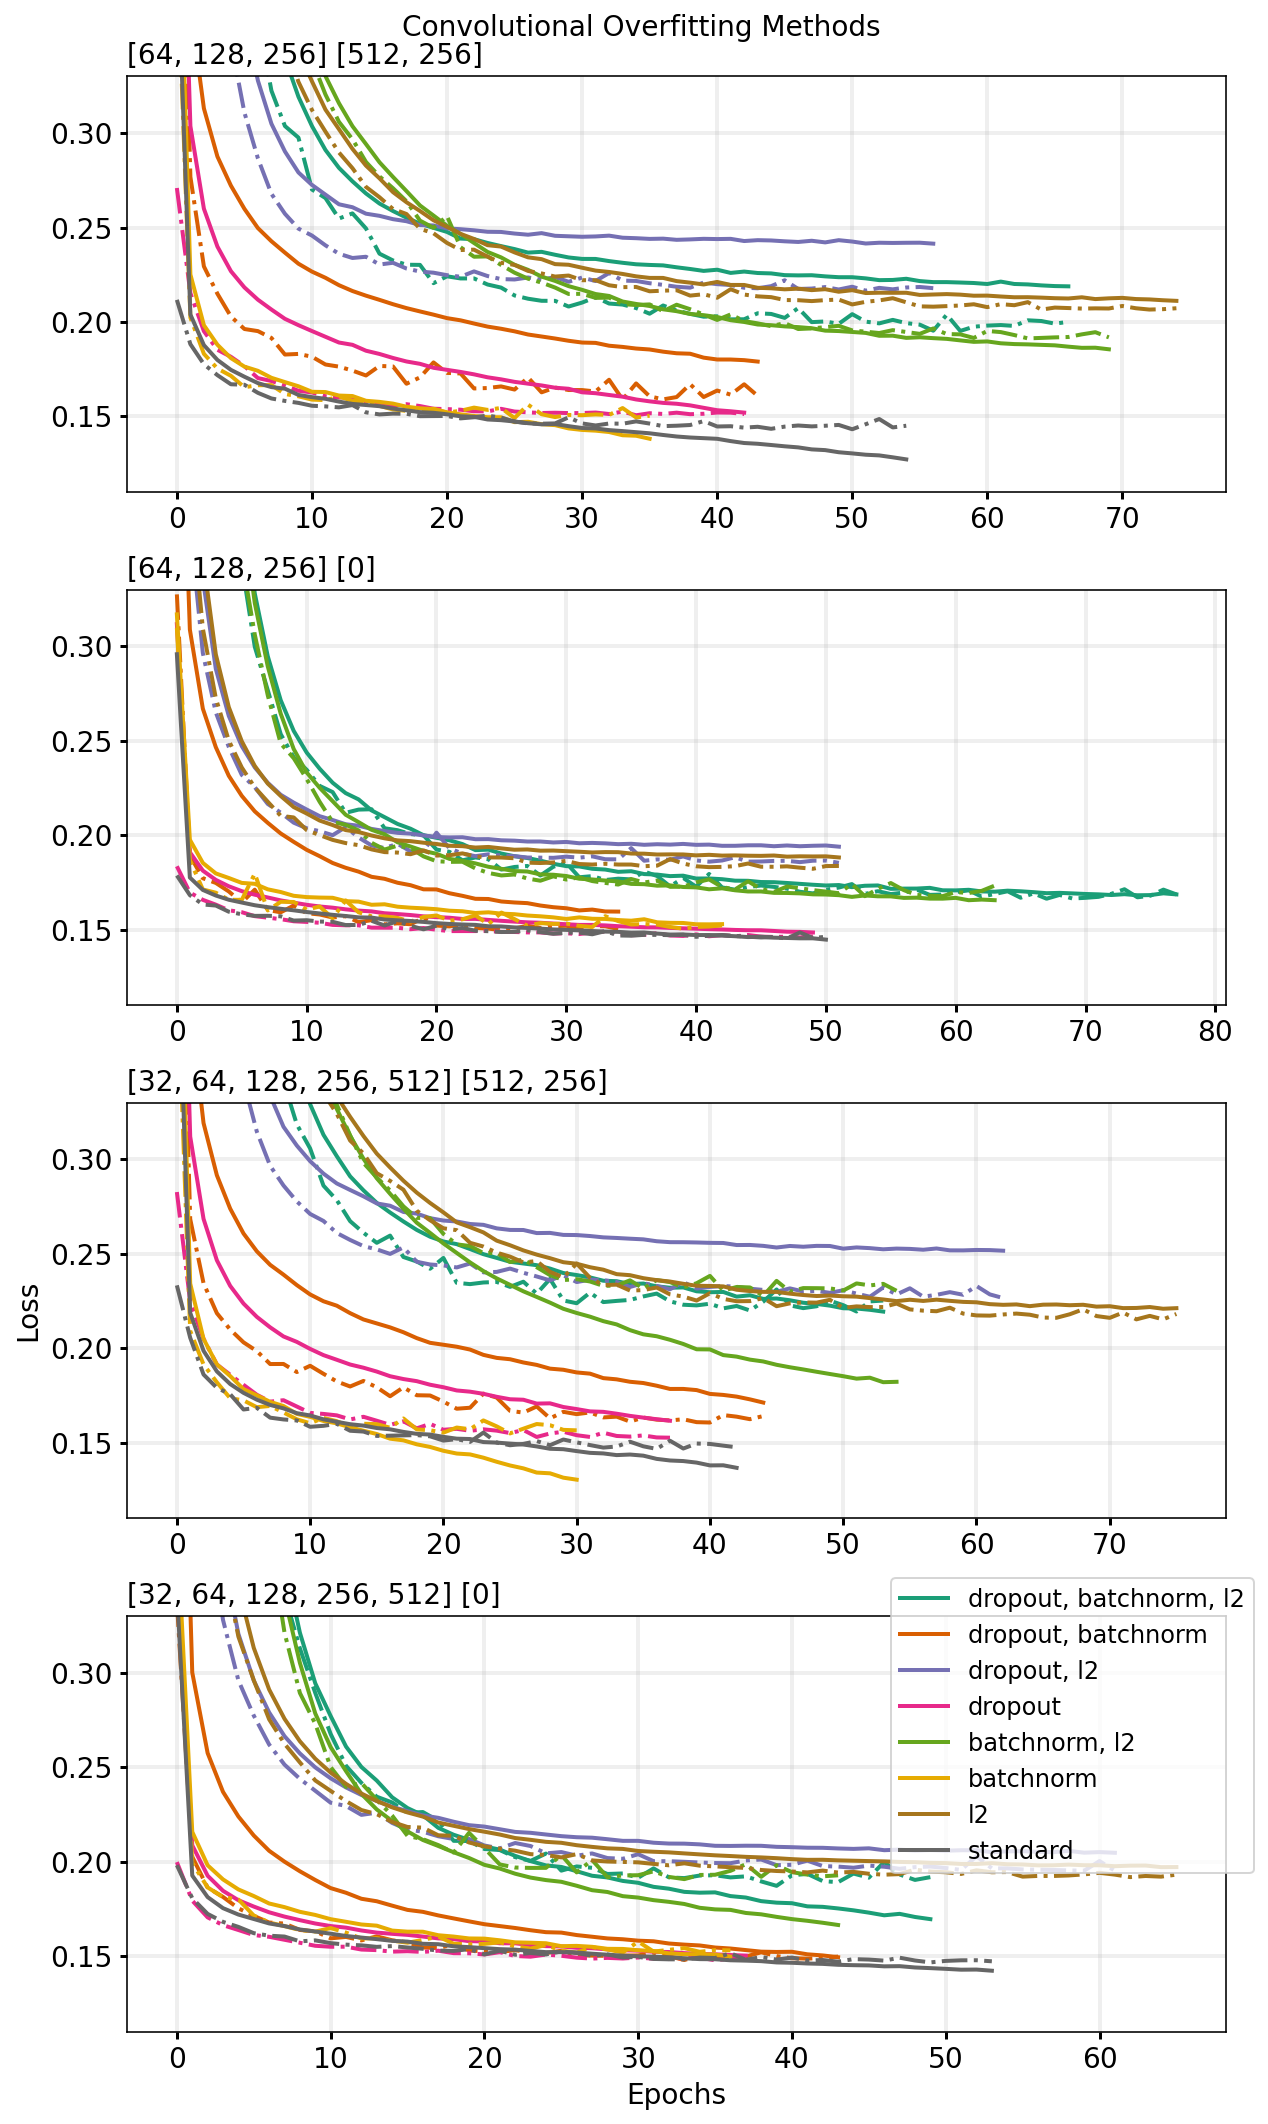

In [74]:
fig, axs = plt.subplots(4, 1, figsize=(9,15))
axs = np.ravel(axs)

units = 512
colors = plt.cm.Dark2(np.linspace(0,1,8)) # tab10
linewidth = 2
default_font = 14
field = ['ml_total_test_rmse']
i = 0
for c, h in list(itertools.product(df['n_units_in_conv_layers'].unique(), df['hiddens'].unique())):
    j = 0
    for dropout, batchnorm, regularization in list(itertools.product([True, False], 
                                                                     [True, False], 
                                                                     [True, False])):
        trial = df.loc[(df['dropout'] == dropout) &
                       (df['batchnorm'] == batchnorm) &
                       (df['regularization'] == regularization) &
                       (df['hiddens'] == h) &
                       (df['n_units_in_conv_layers'] == c)].reset_index(drop=True)
        
        t = trial.sort_values(field).index[0]
        temp = list(itertools.compress(['dropout', 'batchnorm', 'l2'],
                                       [dropout, batchnorm, regularization]))
        if i == 3:
            label = ', '.join(temp) if len(temp) else 'standard'
        else:
            label = None
        axs[i].plot(np.asarray(literal_eval(trial.iloc[t][f'loss'])), color=colors[j], label=label, linewidth=linewidth)
        axs[i].plot(np.asarray(literal_eval(trial.iloc[t][f'val_loss'])), '-.', color=colors[j], linewidth=linewidth)
        j += 1
    
    axs[i].set_ylim((0.11, .33))
    axs[i].grid(True, alpha=0.2, linewidth=linewidth)
    axs[i].tick_params('both', width=1.5, labelsize=default_font)
    axs[i].set_title(c + ' ' + h, loc='left', fontsize=default_font)
    i += 1
    
axs[2].set_ylabel('Loss', fontsize=default_font)   
axs[3].legend(loc='upper center', bbox_to_anchor=(0.86, 1.12), ncol=1, fontsize=12) # (0.5, 1.25)
axs[3].set_xlabel('Epochs', fontsize=default_font)

fig.suptitle('Convolutional Overfitting Methods', fontsize=default_font)
fig.tight_layout()
plt.savefig(f'/home/stock/research/media/cnn_overfitting_results.pdf', dpi=300)

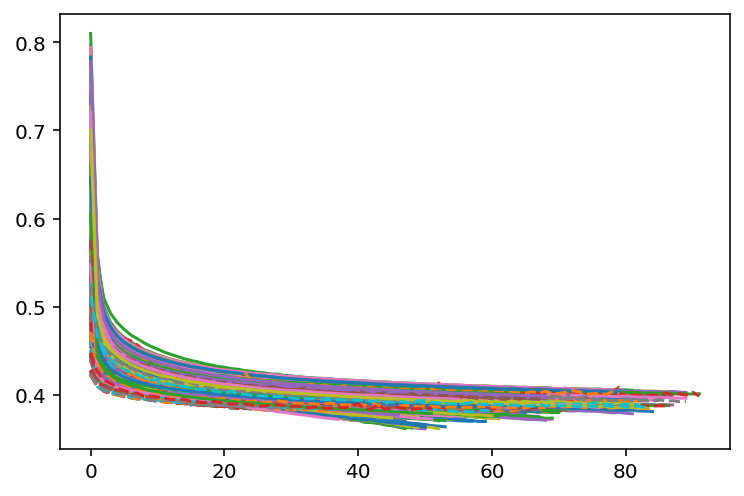

In [11]:
min_i, min_v, max_i, max_v = min_max(df)

# UNet

In [51]:
df = pd.read_csv(os.path.join(VOL, 'test_alley_fully_connected_model_temperature_dewpoint.csv'))
df[['hiddens', 'loss_f', 'ml_total_test_rmse', 'ml_total_test_rmse_sfc', 
    'ml_temperature_test_mean_rmse', 'ml_temperature_test_mean_rmse_sfc',
    'ml_dewpoint_test_mean_rmse', 'ml_dewpoint_test_mean_rmse_sfc']]

hiddens loss_f  ml_total_test_rmse  ml_total_test_rmse_sfc  \
0         [0]  wloss            3.517603                0.992152   
1         [0]    MSE            3.484337                0.996885   
2         [0]    MAE            3.524146                0.996882   
3       [512]  wloss            3.396843                1.021833   
4       [512]    MSE            3.355621                1.097613   
5       [512]    MAE            3.389855                1.040568   
6  [512, 512]  wloss            3.345795                0.997360   
7  [512, 512]    MSE            3.352163                1.147216   
8  [512, 512]    MAE            3.341690                1.074618   

   ml_temperature_test_mean_rmse  ml_temperature_test_mean_rmse_sfc  \
0                       1.003104                           1.019834   
1                       1.010623                           1.038077   
2                       1.006980                           1.022056   
3                       1.024956                           1.049576   
4                       1.060494                           1.189697   
5                       1.027694                           1.099992   
6                       1.024231                           1.034607   
7                       1.090869                           1.289835   
8                       1.032204                           1.139556   

   ml_dewpoint_test_mean_rmse  ml_dewpoint_test_mean_rmse_sfc  
0                    4.872457                        2.985621  
1                    4.822847                        2.962585  
2                    4.881106                        2.977607  
3                    4.693245                        2.942989  
4                    4.625552                        2.988814  
5                    4.682529                        2.965209  
6                    4.619484                        2.930804  
7                    4.613458                        3.045892  
8                    4.611762                        2.956735

In [52]:
df = pd.read_csv(os.path.join(VOL, 'test_alley_multi_cnn_model_temperature_dewpoint.csv'))
df[['hiddens', 'n_units_in_conv_layers', 'loss_f', 'ml_total_test_rmse', 'ml_total_test_rmse_sfc', 
    'ml_temperature_test_mean_rmse', 'ml_temperature_test_mean_rmse_sfc',
    'ml_dewpoint_test_mean_rmse', 'ml_dewpoint_test_mean_rmse_sfc']]

hiddens n_units_in_conv_layers loss_f  ml_total_test_rmse  \
0  [512, 256]          [32, 64, 128]  wloss            3.336962   
1  [512, 256]          [32, 64, 128]    MSE            3.284841   
2  [512, 256]          [32, 64, 128]    MAE            3.292365   
3         [0]          [32, 64, 128]  wloss            3.385186   
4         [0]          [32, 64, 128]    MSE            3.320750   
5         [0]          [32, 64, 128]    MAE            3.377446   

   ml_total_test_rmse_sfc  ml_temperature_test_mean_rmse  \
0                0.996011                       1.014845   
1                1.089410                       1.046953   
2                1.018432                       1.004662   
3                0.985867                       0.987808   
4                1.001234                       0.998592   
5                0.986508                       0.987977   

   ml_temperature_test_mean_rmse_sfc  ml_dewpoint_test_mean_rmse  \
0                           1.027271                    4.608766   
1                           1.194086                    4.525953   
2                           1.076873                    4.546426   
3                           1.005981                    4.684357   
4                           1.055500                    4.588854   
5                           1.022007                    4.673134   

   ml_dewpoint_test_mean_rmse_sfc  
0                        2.864812  
1                        2.943321  
2                        2.929182  
3                        2.894105  
4                        2.909799  
5                        2.919047

In [53]:
df = pd.read_csv(os.path.join(VOL, 'test_alley_skip_model_temperature_dewpoint.csv'))
df[['hiddens', 'n_units_in_conv_layers', 'loss_f', 'ml_total_test_rmse', 'ml_total_test_rmse_sfc', 
    'ml_temperature_test_mean_rmse', 'ml_temperature_test_mean_rmse_sfc',
    'ml_dewpoint_test_mean_rmse', 'ml_dewpoint_test_mean_rmse_sfc']]

hiddens n_units_in_conv_layers loss_f  ml_total_test_rmse  \
0   [512, 256]                  [256]  wloss            3.273357   
1   [512, 256]                  [256]    MSE            3.276054   
2   [512, 256]                  [256]    MAE            3.273305   
3   [512, 256]              [64, 128]  wloss            3.316331   
4   [512, 256]              [64, 128]    MSE            3.299156   
5   [512, 256]              [64, 128]    MAE            3.314918   
6          [0]                  [256]  wloss            3.385636   
7          [0]                  [256]    MSE            3.348688   
8          [0]                  [256]    MAE            3.405303   
9          [0]              [64, 128]  wloss            3.372340   
10         [0]              [64, 128]    MSE            3.375964   
11         [0]              [64, 128]    MAE            3.390226   

    ml_total_test_rmse_sfc  ml_temperature_test_mean_rmse  \
0                 0.975341                       1.007945   
1                 1.106890                       1.069355   
2                 1.030156                       1.007314   
3                 0.990028                       1.005567   
4                 1.159385                       1.099189   
5                 1.037208                       1.027787   
6                 0.973991                       0.997016   
7                 0.986188                       1.005925   
8                 0.980067                       0.998955   
9                 0.971334                       0.996135   
10                0.978491                       0.997733   
11                0.982593                       0.994473   

    ml_temperature_test_mean_rmse_sfc  ml_dewpoint_test_mean_rmse  \
0                            0.983195                    4.518162   
1                            1.231034                    4.507942   
2                            1.080028                    4.518226   
3                            1.002335                    4.580931   
4                            1.338247                    4.534385   
5                            1.086476                    4.573950   
6                            0.967704                    4.683057   
7                            1.007294                    4.627692   
8                            0.989662                    4.711079   
9                            0.971175                    4.664018   
10                           0.999985                    4.668918   
11                           0.988916                    4.690233   

    ml_dewpoint_test_mean_rmse_sfc  
0                         2.846977  
1                         3.010501  
2                         2.981831  
3                         2.888830  
4                         3.040205  
5                         3.009620  
6                         2.841427  
7                         2.957519  
8                         2.961241  
9                         2.841203  
10                        2.950458  
11                        2.923287

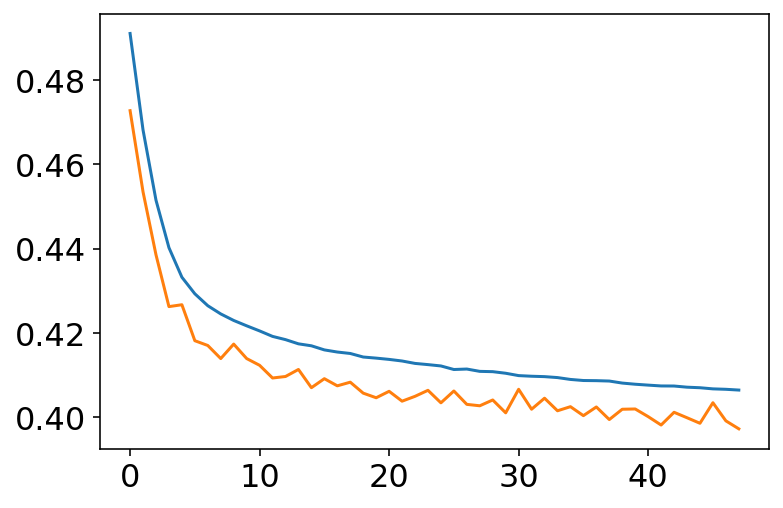

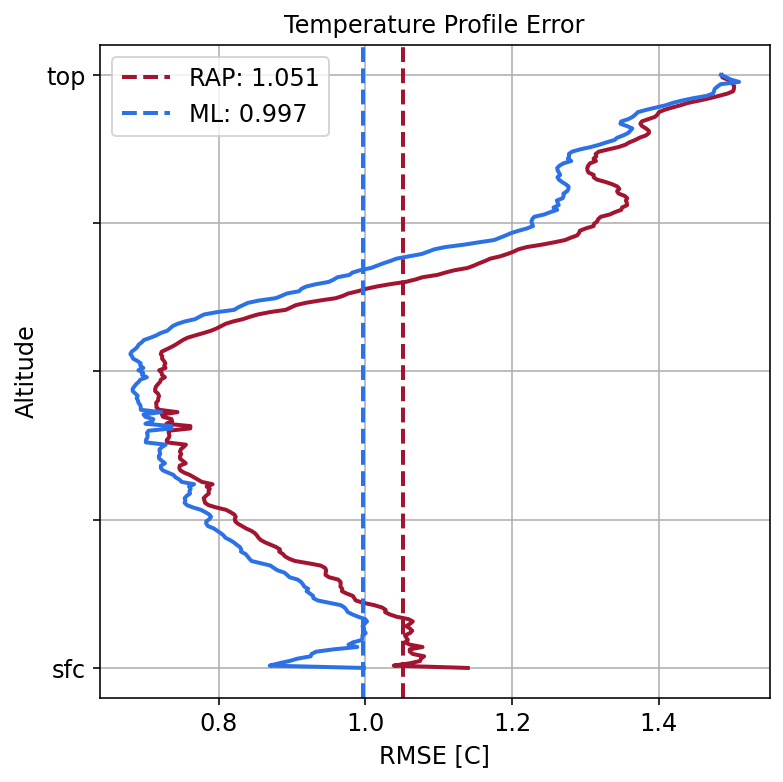

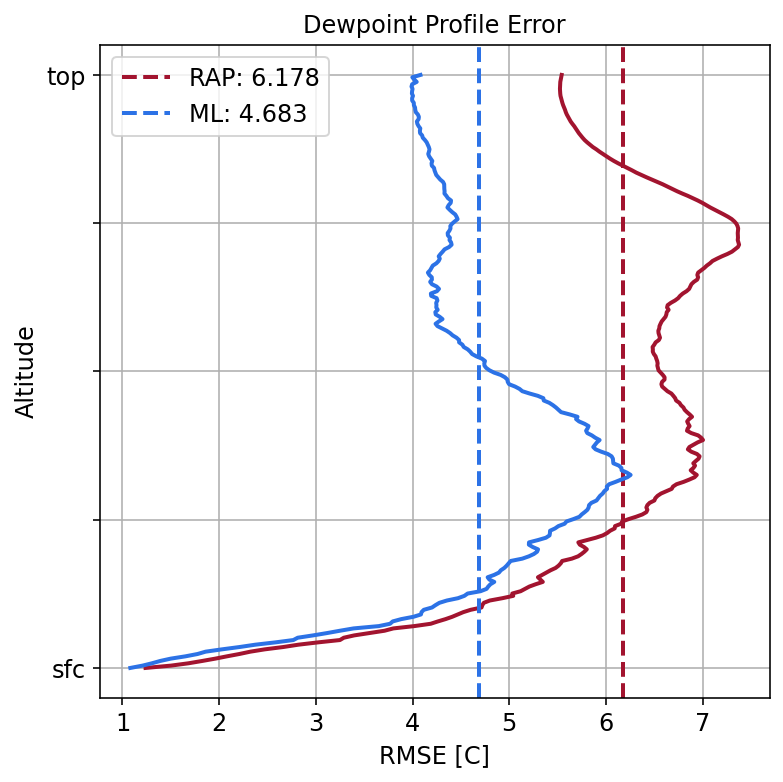

In [82]:
df = pd.read_csv(os.path.join(VOL, 'loss/test_alley_skip_model_temperature_dewpoint.csv'))

# i = df.sort_values(['ml_temperature_test_mean_rmse_sfc']).index[0]
i = 6 # df.sort_values(['ml_total_test_rmse_sfc']).index[0]
fig, ax = plt.subplots()
data_set = 'test' # 'train'
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_{data_set}_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_{data_set}_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_{data_set}_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_{data_set}_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse, title=f'{v.capitalize()} Profile Error')

In [82]:
df = pd.read_csv(os.path.join(VOL, 'alley_skip_model_temperature_dewpoint.csv'))

In [90]:
for r in ['[]', '[0, 1, 2]']:
    for g in ['[]', '[0, 1, 2, 3, 4, 5, 6, 7]']:
        print(r, g)
        trial = df.loc[(df['rtma_input_channels'] == r) & 
                       (df['goes_input_channels'] == g) &
                       (df['hiddens'] == '[0]') &
                       (df['n_units_in_conv_layers'] == '[32, 64, 128, 256]')].sort_values('ml_total_test_rmse').head(1)

        print(f"{trial['ml_temperature_test_mean_rmse'].values[0]:.3f} & \
{trial['ml_dewpoint_test_mean_rmse'].values[0]:.3f} & \
{trial['ml_temperature_test_mean_rmse_sfc'].values[0]:.3f} & \
{trial['ml_dewpoint_test_mean_rmse_sfc'].values[0]:.3f} && ")
        
        print(f"{trial['ml_total_test_rmse'].values[0]:.3f} & \
{trial['ml_total_test_rmse_sfc'].values[0]:.3f} && ")
        

[] []
0.981 & 4.784 & 0.972 & 2.826 && 
3.453 & 0.960 && 
[] [0, 1, 2, 3, 4, 5, 6, 7]
0.978 & 4.519 & 0.969 & 2.795 && 
3.270 & 0.956 && 
[0, 1, 2] []
0.977 & 4.676 & 0.966 & 2.799 && 
3.378 & 0.961 && 
[0, 1, 2] [0, 1, 2, 3, 4, 5, 6, 7]
0.978 & 4.569 & 0.970 & 2.813 && 
3.304 & 0.963 && 


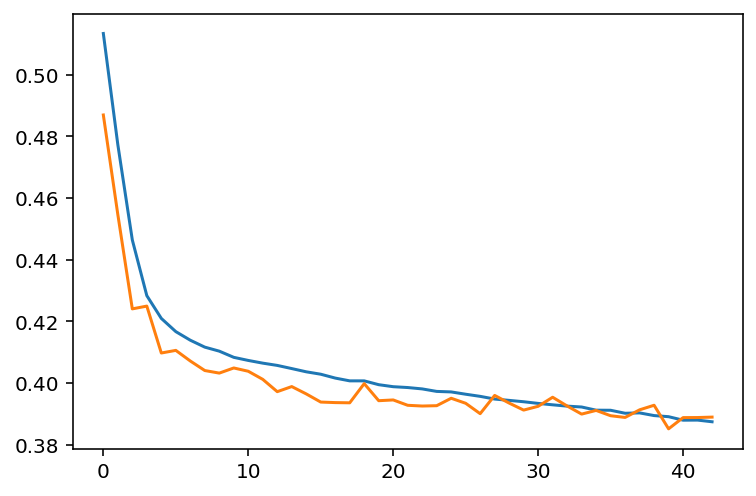

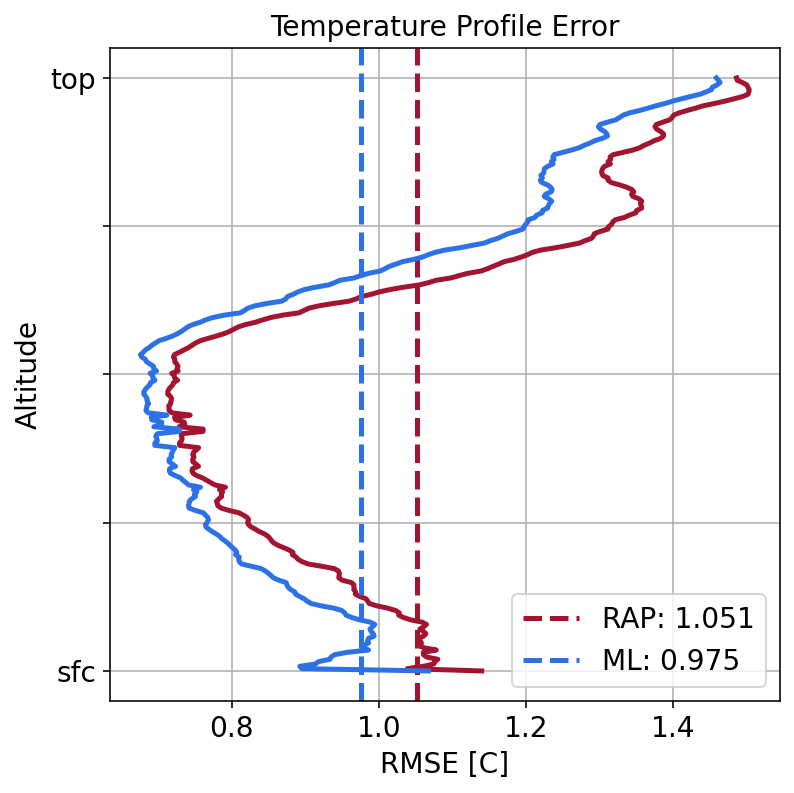

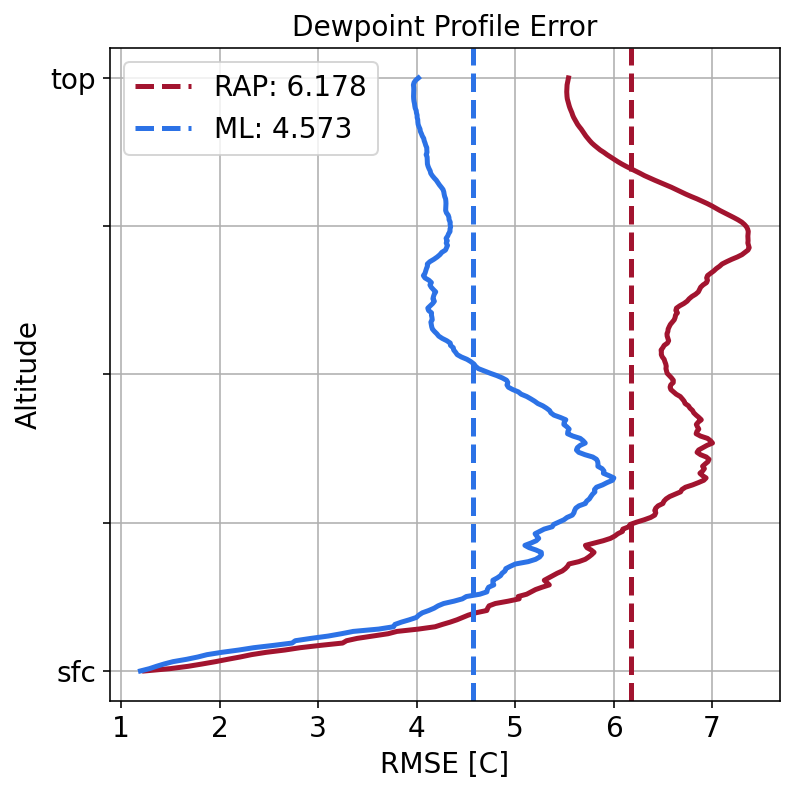

In [36]:
# i = df.sort_values(['ml_temperature_test_mean_rmse_sfc']).index[0]
i = df.sort_values(['ml_total_test_rmse_sfc']).index[0]
fig, ax = plt.subplots()
data_set = 'test' # 'train'
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_{data_set}_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_{data_set}_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_{data_set}_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_{data_set}_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse, title=f'{v.capitalize()} Profile Error',
                                               file_name=f'/home/stock/research/media/unet_{v}_{data_set}.png')

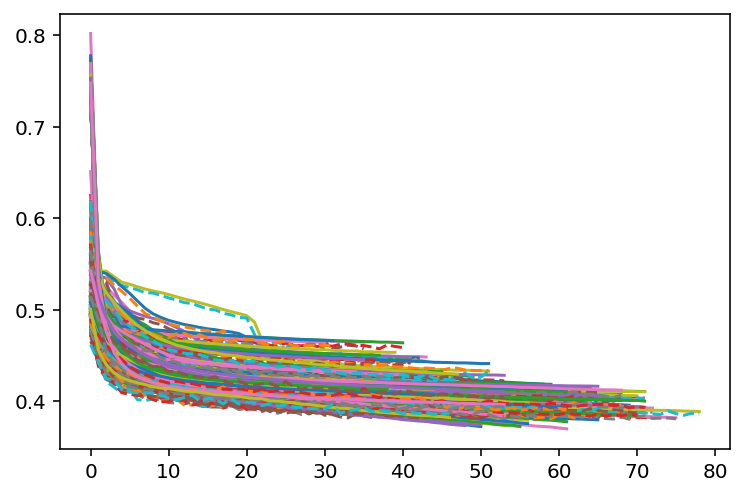

In [10]:
min_i, min_v, max_i, max_v = min_max(df)

In [20]:
results

OrderedDict([('[0]|[256]', (0.9738825276529075, 0.0008410763556340283)),
             ('[0]|[64, 128]', (0.9721030551614263, 0.0021719056714981687)),
             ('[0]|[32, 32, 32]', (0.9849218271177573, 0.001276096215250166)),
             ('[0]|[8, 16, 32, 64]',
              (0.9892642638666673, 0.002852844534783596)),
             ('[0]|[16, 32, 64, 128]',
              (0.9708118904756367, 0.001431097529864376)),
             ('[0]|[32, 64, 128, 256]',
              (0.9603355322663931, 0.0016272399127578848)),
             ('[256]|[256]', (0.9929404664805901, 0.00810963707567654)),
             ('[256]|[64, 128]', (0.9893288841133447, 0.004323539124391195)),
             ('[256]|[32, 32, 32]',
              (0.9926125439556618, 0.0040511137558356955)),
             ('[256]|[8, 16, 32, 64]',
              (1.0032609555687253, 0.004255586807355092)),
             ('[256]|[16, 32, 64, 128]',
              (0.9855497273560643, 0.004493388039021387)),
             ('[256]|[32, 64, 12

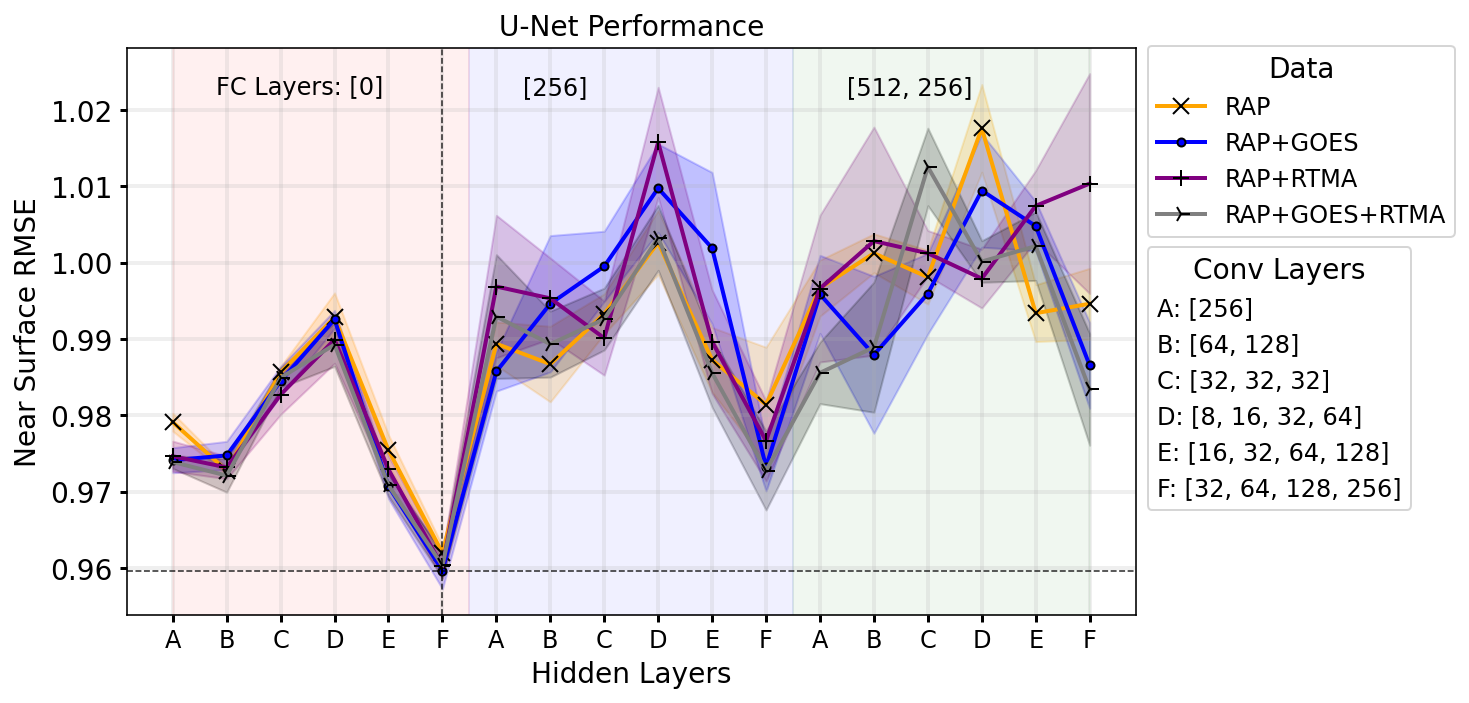

In [63]:
def trial_results(rtma_input_channels, goes_input_channels, dropout):
    results = dict()
    field = ['ml_total_test_rmse_sfc'] # ['ml_total_test_rmse']
    for h in df['hiddens'].unique():
        for c in df['n_units_in_conv_layers'].unique():
            trial = df.loc[(df['rtma_input_channels'] == rtma_input_channels) & 
                           (df['goes_input_channels'] == goes_input_channels) &
                           (df['dropout'] == dropout) &
                           (df['hiddens'] == h) &
                           (df['n_units_in_conv_layers'] == c)]

            trial_t_mean = trial[field].mean().values[0]
            trial_t_sem = trial[field].sem().values[0]
            results[h+'|'+c] = (trial_t_mean, trial_t_sem)
            
    return OrderedDict(sorted(results.items(), key=lambda t: len(t[0].split('|')[0])))

fig, ax = plt.subplots(figsize=(10,5))

linewidth = 2

span_alpha = 0.06
y = 1.022 # 3.65 # 1.022
ax.axvspan(0, 5.5, alpha=span_alpha, color='red')
ax.text(0.8, y, 'FC Layers: [0]', fontsize=12)
ax.axvspan(5.5, 11.5, alpha=span_alpha, color='blue')
ax.text(6.5, y, '[256]', fontsize=12)
ax.axvspan(11.5, 17, alpha=span_alpha, color='green')
ax.text(12.5, y, '[512, 256]', fontsize=12)

results = trial_results('[]', '[]', False)
mean_sem = np.array(list(results.values()))
min_err = min(mean_sem[:,0])
min_err_i = np.argmin(mean_sem[:,0])

ax.plot(range(len(results)), mean_sem[:,0], '-x', markersize=8, color='orange', 
        markeredgecolor='k', linewidth=linewidth, label='RAP')
ax.fill_between(range(len(results)), mean_sem[:,0] - mean_sem[:,1], 
                mean_sem[:,0] + mean_sem[:,1],
                color='orange', alpha=0.2)

results = trial_results('[]', '[0, 1, 2, 3, 4, 5, 6, 7]', False)
mean_sem = np.array(list(results.values()))
if min(mean_sem[:,0]) < min_err:
    min_err = min(mean_sem[:,0])
    min_err_i = np.argmin(mean_sem[:,0])

ax.plot(range(len(results)), mean_sem[:,0], '-', marker='.', markersize=8, color='blue', 
        markeredgecolor='k', linewidth=linewidth, label='RAP+GOES')
ax.fill_between(range(len(results)), mean_sem[:,0] - mean_sem[:,1], 
                mean_sem[:,0] + mean_sem[:,1],
                color='blue', alpha=0.2)

results = trial_results('[0, 1, 2]', '[]', False)
mean_sem = np.array(list(results.values()))
if min(mean_sem[:,0]) < min_err:
    min_err = min(mean_sem[:,0])
    min_err_i = np.argmin(mean_sem[:,0])
    
ax.plot(range(len(results)), mean_sem[:,0], '-+', markersize=8, color='purple',
        markeredgecolor='k', linewidth=linewidth, label='RAP+RTMA')
ax.fill_between(range(len(results)), mean_sem[:,0] - mean_sem[:,1], 
                mean_sem[:,0] + mean_sem[:,1],
                color='purple', alpha=0.2)

results = trial_results('[0, 1, 2]', '[0, 1, 2, 3, 4, 5, 6, 7]', False)
mean_sem = np.array(list(results.values()))
if min(mean_sem[:,0]) < min_err:
    min_err = min(mean_sem[:,0])
    min_err_i = np.argmin(mean_sem[:,0])

ax.plot(range(len(results)), mean_sem[:,0], '-4', markersize=9, color='gray', 
        markeredgecolor='k', linewidth=linewidth, label='RAP+GOES+RTMA')
ax.fill_between(range(len(results)), mean_sem[:,0] - mean_sem[:,1], 
                mean_sem[:,0] + mean_sem[:,1],
                color='black', alpha=0.2)

# minimum 
ax.axhline(y=min_err, color='k', linestyle='--', alpha=0.8, linewidth=0.8)
ax.axvline(x=min_err_i, ymin=0, color='k', linestyle='--', alpha=0.8, linewidth=0.8)

labels = np.tile([i for i in string.ascii_uppercase[:6]], 3) # list(results.keys())
default_font = 14

ax.set_xticks(range(len(results)))
ax.set_xticklabels(labels);
ax.tick_params(axis='x', width=1.5, labelsize=12, rotation=0)
ax.tick_params(axis='y', width=1.5, labelsize=default_font)
ax.set_ylabel('Near Surface RMSE', fontsize=default_font); ax.set_xlabel('Hidden Layers', fontsize=default_font)
ax.set_title('U-Net Performance', fontsize=default_font)
ax.grid(True, alpha=0.2, linewidth=linewidth)

layers = df['n_units_in_conv_layers'].unique()
letters = [i for i in string.ascii_uppercase[:9]]
labels = [': '.join([s[0], s[1]]) for s in list(zip(letters, layers))]
proxies = [matplotlib.lines.Line2D([],[], markerfacecolor='w', markeredgecolor='w') for _ in range(len(labels))]

legend1 = ax.legend(bbox_to_anchor=(1.0, 1.025),
                    ncol=1, fontsize=12, title='Data')
ax.add_artist(legend1)
plt.setp(legend1.get_title(),fontsize=default_font)

legend2 = ax.legend(proxies, labels, handletextpad=0, handlelength=0, bbox_to_anchor=(1.0, 0.67), 
                    ncol=1, fontsize=12, title='Conv Layers');
plt.setp(legend2.get_title(),fontsize=default_font)
fig.tight_layout()
plt.savefig('/home/stock/research/media/unet_rmse_results_sfc_wmae_line.pdf', bbox_inches='tight', dpi=300)

In [32]:
df = pd.read_csv(os.path.join(VOL, 'loss_overfit_alley_skip_model_temperature_dewpoint.csv'))
df[['hiddens', 'n_units_in_conv_layers', 'loss_f', 'dropout', 'batchnorm', 'regularization', 
    'ml_total_test_rmse', 'ml_total_test_rmse_sfc', 
    'ml_temperature_test_mean_rmse', 'ml_temperature_test_mean_rmse_sfc',
    'ml_dewpoint_test_mean_rmse', 'ml_dewpoint_test_mean_rmse_sfc']].sort_values('ml_total_test_rmse_sfc')

hiddens n_units_in_conv_layers loss_f  dropout  batchnorm  regularization  \
2      [0]     [32, 64, 128, 256]  wloss    False       True           False   
0      [0]     [32, 64, 128, 256]  wloss    False      False           False   
4      [0]     [32, 64, 128, 256]  wloss     True      False           False   
1      [0]     [32, 64, 128, 256]  wloss    False      False            True   
3      [0]     [32, 64, 128, 256]  wloss    False       True            True   
18     [0]     [32, 64, 128, 256]    MAE    False       True           False   
16     [0]     [32, 64, 128, 256]    MAE    False      False           False   
6      [0]     [32, 64, 128, 256]  wloss     True       True           False   
11     [0]     [32, 64, 128, 256]    MSE    False       True            True   
17     [0]     [32, 64, 128, 256]    MAE    False      False            True   
9      [0]     [32, 64, 128, 256]    MSE    False      False            True   
19     [0]     [32, 64, 128, 256]    MAE    False       True            True   
10     [0]     [32, 64, 128, 256]    MSE    False       True           False   
8      [0]     [32, 64, 128, 256]    MSE    False      False           False   
5      [0]     [32, 64, 128, 256]  wloss     True      False            True   
22     [0]     [32, 64, 128, 256]    MAE     True       True           False   
20     [0]     [32, 64, 128, 256]    MAE     True      False           False   
7      [0]     [32, 64, 128, 256]  wloss     True       True            True   
15     [0]     [32, 64, 128, 256]    MSE     True       True            True   
14     [0]     [32, 64, 128, 256]    MSE     True       True           False   
21     [0]     [32, 64, 128, 256]    MAE     True      False            True   
23     [0]     [32, 64, 128, 256]    MAE     True       True            True   
13     [0]     [32, 64, 128, 256]    MSE     True      False            True   
12     [0]     [32, 64, 128, 256]    MSE     True      False           False   

    ml_total_test_rmse  ml_total_test_rmse_sfc  ml_temperature_test_mean_rmse  \
2             3.304210                0.959858                       0.979309   
0             3.359932                0.961231                       0.982333   
4             3.360363                0.963880                       0.987771   
1             3.317585                0.966371                       0.987326   
3             3.302275                0.968536                       0.989565   
18            3.290684                0.969609                       0.978796   
16            3.312763                0.971194                       0.977686   
6             3.424653                0.972141                       0.992540   
11            3.246303                0.976009                       0.986134   
17            3.359978                0.976047                       0.979740   
9             3.230381                0.976678                       0.986858   
19            3.293892                0.978755                       0.979073   
10            3.314175                0.978799                       0.993029   
8             3.287971                0.979669                       0.992418   
5             3.490132                0.985203                       1.009025   
22            3.353884                0.985583                       0.989112   
20            3.323823                0.985987                       0.989230   
7             3.484631                0.987301                       1.013241   
15            3.478210                0.988817                       1.010707   
14            3.325024                0.990177                       0.999108   
21            3.462526                0.990614                       0.999178   
23            3.413197                0.991216                       0.998661   
13            3.344002                0.991216                       1.003734   
12            3.344902                0.992205            

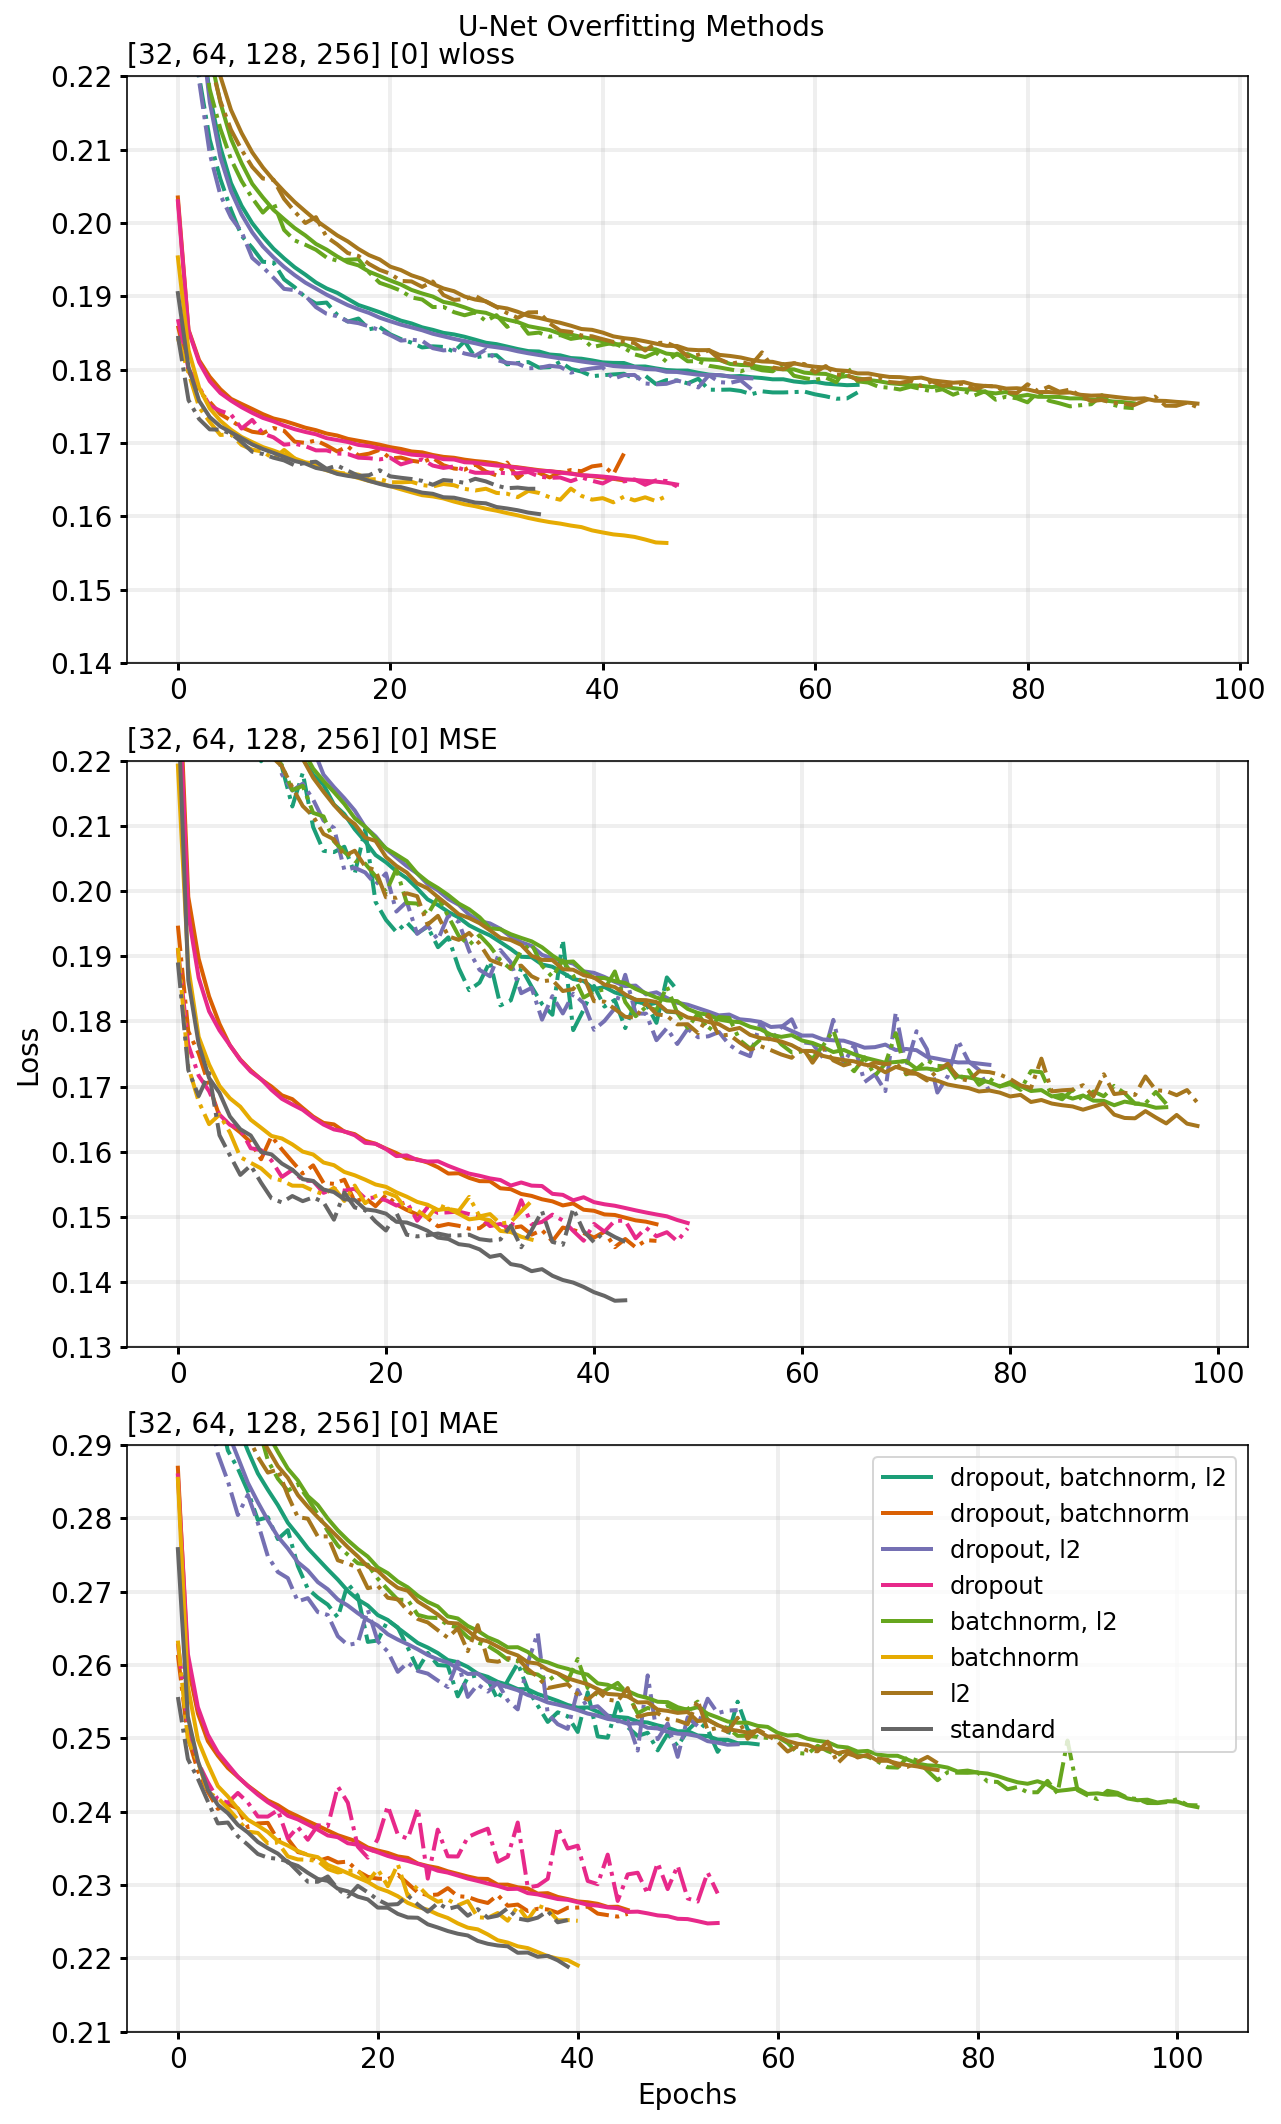

In [28]:
fig, axs = plt.subplots(3, 1, figsize=(9,15))
axs = np.ravel(axs)

units = 512
colors = plt.cm.Dark2(np.linspace(0,1,8)) # tab10
linewidth = 2
default_font = 14
field = ['ml_total_test_rmse']
i = 0
for c, h, l in list(itertools.product(df['n_units_in_conv_layers'].unique(), 
                                      df['hiddens'].unique(), df['loss_f'].unique())):
    j = 0
    for dropout, batchnorm, regularization in list(itertools.product([True, False], 
                                                                     [True, False], 
                                                                     [True, False])):
        trial = df.loc[(df['dropout'] == dropout) &
                       (df['batchnorm'] == batchnorm) &
                       (df['regularization'] == regularization) &
                       (df['hiddens'] == h) &
                       (df['n_units_in_conv_layers'] == c) &
                       (df['loss_f'] == l)].reset_index(drop=True)
        
        t = trial.sort_values(field).index[0]
        temp = list(itertools.compress(['dropout', 'batchnorm', 'l2'],
                                       [dropout, batchnorm, regularization]))
        if i == 2:
            label = ', '.join(temp) if len(temp) else 'standard'
        else:
            label = None
        axs[i].plot(np.asarray(literal_eval(trial.iloc[t][f'loss'])), color=colors[j], label=label, linewidth=linewidth)
        axs[i].plot(np.asarray(literal_eval(trial.iloc[t][f'val_loss'])), '-.', color=colors[j], linewidth=linewidth)
        j += 1

    axs[i].grid(True, alpha=0.2, linewidth=linewidth)
    axs[i].tick_params('both', width=1.5, labelsize=default_font)
    axs[i].set_title(c + ' ' + h + ' ' + l, loc='left', fontsize=default_font)
    i += 1
        
axs[0].set_ylim((0.14, .22))
axs[1].set_ylim((0.13, .22))
axs[2].set_ylim((0.21, .29))
axs[1].set_ylabel('Loss', fontsize=default_font)   
axs[2].legend(loc='upper right', ncol=1, fontsize=12) # (0.5, 1.25)
axs[2].set_xlabel('Epochs', fontsize=default_font)

fig.suptitle('U-Net Overfitting Methods', fontsize=default_font)
fig.tight_layout()
# plt.savefig(f'/home/stock/research/media/unet_overfitting_results.pdf', dpi=300)


## Loss Functions

In [12]:
df[['hiddens', 'n_units_in_conv_layers', 'loss_f', 'ml_total_test_rmse', 'ml_total_test_rmse_sfc', 
    'ml_temperature_test_mean_rmse', 'ml_temperature_test_mean_rmse_sfc',
    'ml_dewpoint_test_mean_rmse', 'ml_dewpoint_test_mean_rmse_sfc']]

hiddens n_units_in_conv_layers loss_f  ml_total_test_rmse  \
0     [0]     [32, 64, 128, 256]  wloss            3.265023   
1     [0]     [32, 64, 128, 256]    MSE            3.283325   
2     [0]     [32, 64, 128, 256]    MAE            3.325764   

   ml_total_test_rmse_sfc  ml_temperature_test_mean_rmse  \
0                0.959903                       0.976514   
1                0.985698                       0.992771   
2                0.976223                       0.981757   

   ml_temperature_test_mean_rmse_sfc  ml_dewpoint_test_mean_rmse  \
0                           0.968596                    4.513001   
1                           1.001301                    4.535951   
2                           0.984473                    4.599735   

   ml_dewpoint_test_mean_rmse_sfc  
0                        2.810725  
1                        2.889239  
2                        2.887314

In [ ]:
df = pd.read_csv(os.path.join(VOL, 'loss_alley_skip_model_temperature_dewpoint.csv'))

i = 2 # df.sort_values(['ml_temperature_test_mean_rmse_sfc']).index[0]
fig, ax = plt.subplots()
data_set = 'test' # 'train'
ax.plot(np.asarray(literal_eval(df.iloc[i][f'root_mean_squared_error'])))
ax.plot(np.asarray(literal_eval(df.iloc[i][f'val_root_mean_squared_error'])))
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(literal_eval(df.iloc[i][f'ml_{v}_{data_set}_rmse']))
    ml_mean_rmse = df.iloc[i][f'ml_{v}_{data_set}_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_{data_set}_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_{data_set}_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse, title=f'{v.capitalize()} Profile Error'
    , file_name=f'/home/stock/research/media/unet_mae_{v}_{data_set}.pdf')
    

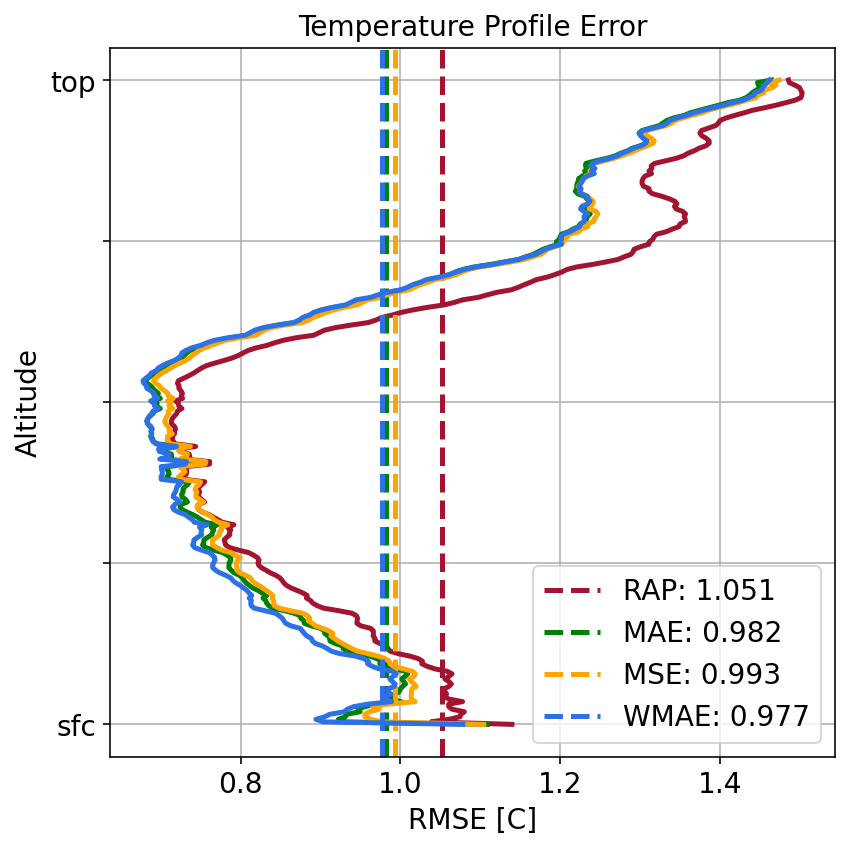

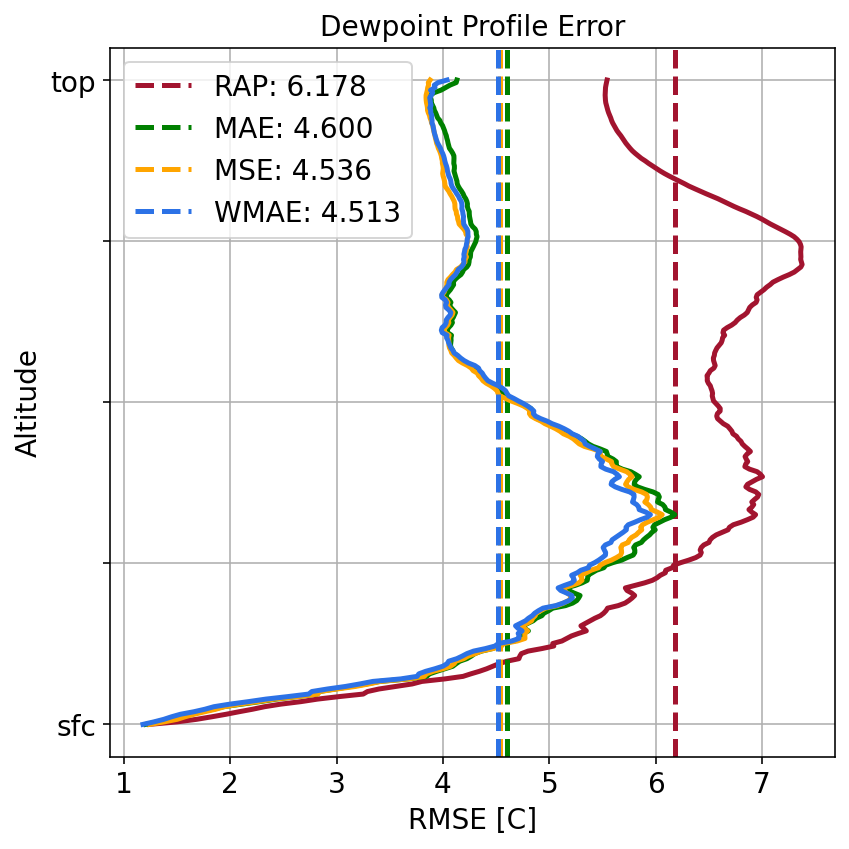

In [78]:
data_set = 'test'
for v in ['temperature', 'dewpoint']:
    title = f'{v.capitalize()} Profile Error'
    file_name = f'/home/stock/research/media/unet_loss_{v}_{data_set}.pdf'
    
    default_font = 14
    figure_width = 6
    figure_height = 6
    line_width = 2.5

     # @OVERRIDE alt
    alt = np.arange(ml_rmse.shape[0])
    rap_color = radiosonde_plotting.DEFAULT_OPTION_DICT[radiosonde_plotting.NWP_LINE_COLOUR_KEY]
    
    ml_colors = ['green', 'orange', radiosonde_plotting.DEFAULT_OPTION_DICT[radiosonde_plotting.PREDICTED_LINE_COLOUR_KEY]]

    fig, axs = plt.subplots(1, 1, figsize=(figure_width, figure_height))
    
    rap_rmse = baseline[f'rap_{v}_{data_set}_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_{data_set}_mean_rmse']

    axs.plot(rap_rmse, alt, color=rap_color, linewidth=line_width)
    axs.axvline(rap_mean_rmse, label=f'RAP: {rap_mean_rmse:.3f}',
                   color=rap_color, linestyle='--', linewidth=line_width)
    
    for i, loss in enumerate(df.loss_f.unique()[::-1]):
        trail = df.loc[(df['loss_f'] == loss)]
        ml_rmse = np.asarray(literal_eval(trail[f'ml_{v}_{data_set}_rmse'].values[0]))
        ml_mean_rmse = trail[f'ml_{v}_{data_set}_mean_rmse'].values[0]

        if loss == 'wloss':
            loss = 'wmae'
        
        axs.plot(ml_rmse, alt, color=ml_colors[i], linewidth=line_width)
        axs.axvline(ml_mean_rmse, label=f'{loss.upper()}: {ml_mean_rmse:.3f}',
                    color=ml_colors[i], linestyle='--', linewidth=line_width)

    axs.set_ylabel('Altitude', fontsize=default_font)
    axs.set_xlabel('RMSE [C]', fontsize=default_font)
    axs.legend(fontsize=default_font)

    n_ticks = 5
    if len(alt) > 50:
        axs.set_yticks(np.linspace(alt.min(), alt.max(), n_ticks))
        axs.set_yticklabels(['sfc'] + ['']*(n_ticks-2) + ['top'])
        for i, label in enumerate(axs.get_yticklabels()):
            if i > 0 and i < len(axs.get_yticklabels()) - 1:
                label.set_visible(False) 
    else:
        axs.set_yticks(np.linspace(alt.min(), alt.max(), n_ticks))
        axs.set_yticklabels(['sfc'] + ['']*(n_ticks-2) + ['${1}/{n}^{th}$'])
        for i, label in enumerate(axs.get_yticklabels()):
            if i > 0 and i < len(axs.get_yticklabels()) - 1:
                label.set_visible(False) 

    axs.tick_params(axis='x', labelsize=default_font)
    axs.tick_params(axis='y', labelsize=default_font)
    axs.set_title(title, fontsize=default_font)
    axs.grid(True)

    fig.tight_layout()
    plt.savefig(file_name, dpi=300)

# Best Model

In [72]:
from soundings.experiments import cnn_skip_neuralnetwork_driver as cnndriver

from soundings.deep_learning import tf_neuralnetwork as nn

In [73]:
data = (RAPtrain , RAPval,  RAPtest, 
        RTMAtrain, RTMAval, RTMAtest,
        GOEStrain, GOESval, GOEStest,
        RAOBtrain, RAOBval, RAOBtest)
rap_input_dims = [0, 1, 2, 3]
rap_output_dims = [1, 2]
rtma_input_channels = [0, 1, 2]
goes_input_channels = [0, 1, 2, 3, 4, 5, 6, 7]

driver = cnndriver.CNNSkipNetworkDriver()

Xtr, Xti, Tt, Xvr, Xvi, Tv, Xer, Xei, Te = driver.organize_data(data, rap_input_dims, rap_output_dims,
                                                                rtma_input_channels, goes_input_channels)

INFO: data organization - [0, 1, 2, 3] [1, 2] [0, 1, 2] [0, 1, 2, 3, 4, 5, 6, 7]
INFO: data dimensions - (28782, 256, 4) (28782, 1, 1, 11) (28782, 512) (3840, 256, 4) (3840, 1, 1, 11) (3840, 512) (5733, 256, 4) (5733, 1, 1, 11) (5733, 512)


In [25]:
# i = 8
# Xtr, Xti, Tt, Xvr, Xvi, Tv, Xer, Xei, Te = Xtr[:,::i], Xti, Tt[:,::i], Xvr[:,::i], Xvi, Tv[:,::i], Xer[:,::i], Xei, Te[:,::i]

In [83]:
n_hiddens_list = [0]
n_units_in_conv_layers = [256]
kernels_size_and_stride = '(3, 1)'
rap_activation = 'relu'
dense_activation = 'relu'
optim = 'adam'
lr = 0.0001
loss = 'wloss'
n_epochs = 125
batch_size = 128
dropout = False
batchnorm = False
regularization = False

n_rap_inputs = Xtr.shape[1:] # (256, 4)
n_im_inputs  = Xti.shape[1:] if Xti is not None else None # (3, 3, 3)
n_network_outputs = Tt.shape[1]

nnet = nn.SkipNeuralNetwork(n_rap_inputs, n_im_inputs, n_hiddens_list, n_units_in_conv_layers,
                            [literal_eval(kernels_size_and_stride)]* \
                                len(n_units_in_conv_layers), # all same size
                            n_network_outputs, rap_activation=rap_activation,
                            dense_activation=dense_activation, 
                            batchnorm=batchnorm, dropout=dropout, regularization=regularization)
nnet.model.summary()
nnet.train(Xtr, Xti, Tt, n_epochs, batch_size, method=optim, verbose=True,
           learning_rate=lr, validation=(Xvr, Xvi, Tv), loss_f=loss)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rap (InputLayer)                [(None, 256, 4)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 256, 256)     3328        rap[0][0]                        
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256)     0           conv1d[0][0]                     
__________________________________________________________________________________________________
skip_conv1d_0 (Conv1D)          (None, 256, 256)     196864      activation[0][0]                 
_______________________________________________________________________________________

SkipNeuralNetwork(512)
  Final objective value is 0.16481 in 264.8979 seconds.

## Standard Metrics

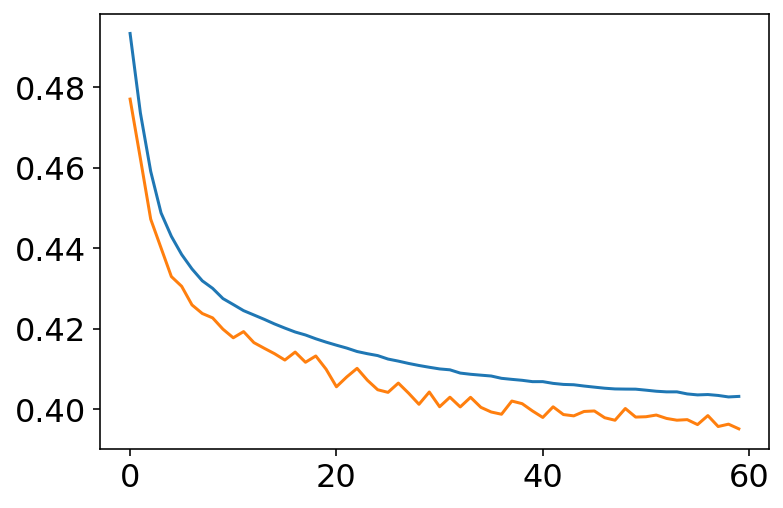

In [84]:
fig, ax = plt.subplots()
ax.plot(nnet.history[f'root_mean_squared_error'])
ax.plot(nnet.history[f'val_root_mean_squared_error'])

In [85]:
r = dict()

TEMP, DEWPT = 0, 1
sets = ['train', 'val', 'test']

for j, (Xr, Xi, T, RAP, RAOB) in enumerate([(Xtr, Xti, Tt, RAPtrain, RAOBtrain),
                                            (Xvr, Xvi, Tv, RAPval  , RAOBval),
                                            (Xer, Xei, Te, RAPtest , RAOBtest)]):

    X = {'rap': Xr, 'im': Xi} if Xi is not None else {'rap': Xr}
    Y = nnet.use(X)

    surface_error=25
    r[f'ml_total_{sets[j]}_rmse'] = ml.rmse(Y, T)
    r[f'ml_total_{sets[j]}_rmse_sfc'] = ml.rmse(Y[:,surface_error*2], T[:,surface_error*2])

    Y = Y.reshape(RAP[:,:,rap_output_dims].shape) # (None, 256, N)

    (rmse, mean_rmse,
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(Y[:,:,TEMP], 
                                                                   RAOB[:, :, 1], 
                                                                   surface_error)
    r[f'ml_temperature_{sets[j]}_rmse'] = rmse.tolist()
    r[f'ml_temperature_{sets[j]}_mean_rmse'] = mean_rmse
    r[f'ml_temperature_{sets[j]}_rmse_sfc'] = rmse_sfc.tolist()
    r[f'ml_temperature_{sets[j]}_mean_rmse_sfc'] = mean_rmse_sfc

    (rmse, mean_rmse,
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(Y[:,:,DEWPT], 
                                                                   RAOB[:, :, 2], 
                                                                   surface_error)
    r[f'ml_dewpoint_{sets[j]}_rmse'] = rmse.tolist()
    r[f'ml_dewpoint_{sets[j]}_mean_rmse'] = mean_rmse
    r[f'ml_dewpoint_{sets[j]}_rmse_sfc'] = rmse_sfc.tolist()
    r[f'ml_dewpoint_{sets[j]}_mean_rmse_sfc'] = mean_rmse_sfc

In [86]:
df = pd.DataFrame([r])

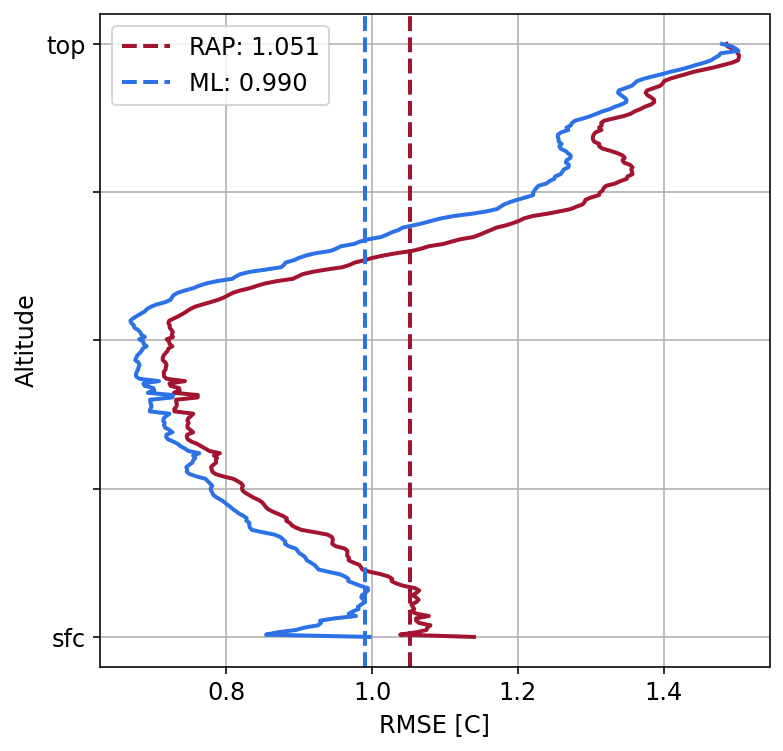

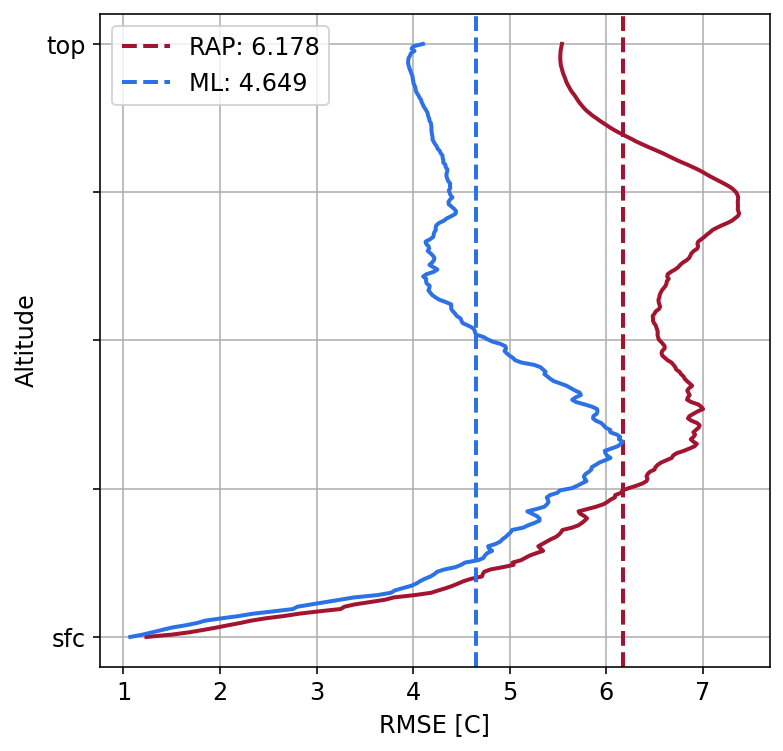

In [87]:
i = 0
data_set = 'test' # 'train'
for v in ['temperature', 'dewpoint']:
    ml_rmse = np.asarray(df.iloc[i][f'ml_{v}_{data_set}_rmse'])
    ml_mean_rmse = df.iloc[i][f'ml_{v}_{data_set}_mean_rmse']
    rap_rmse = baseline[f'rap_{v}_{data_set}_rmse']
    rap_mean_rmse = baseline[f'rap_{v}_{data_set}_mean_rmse']

    results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)

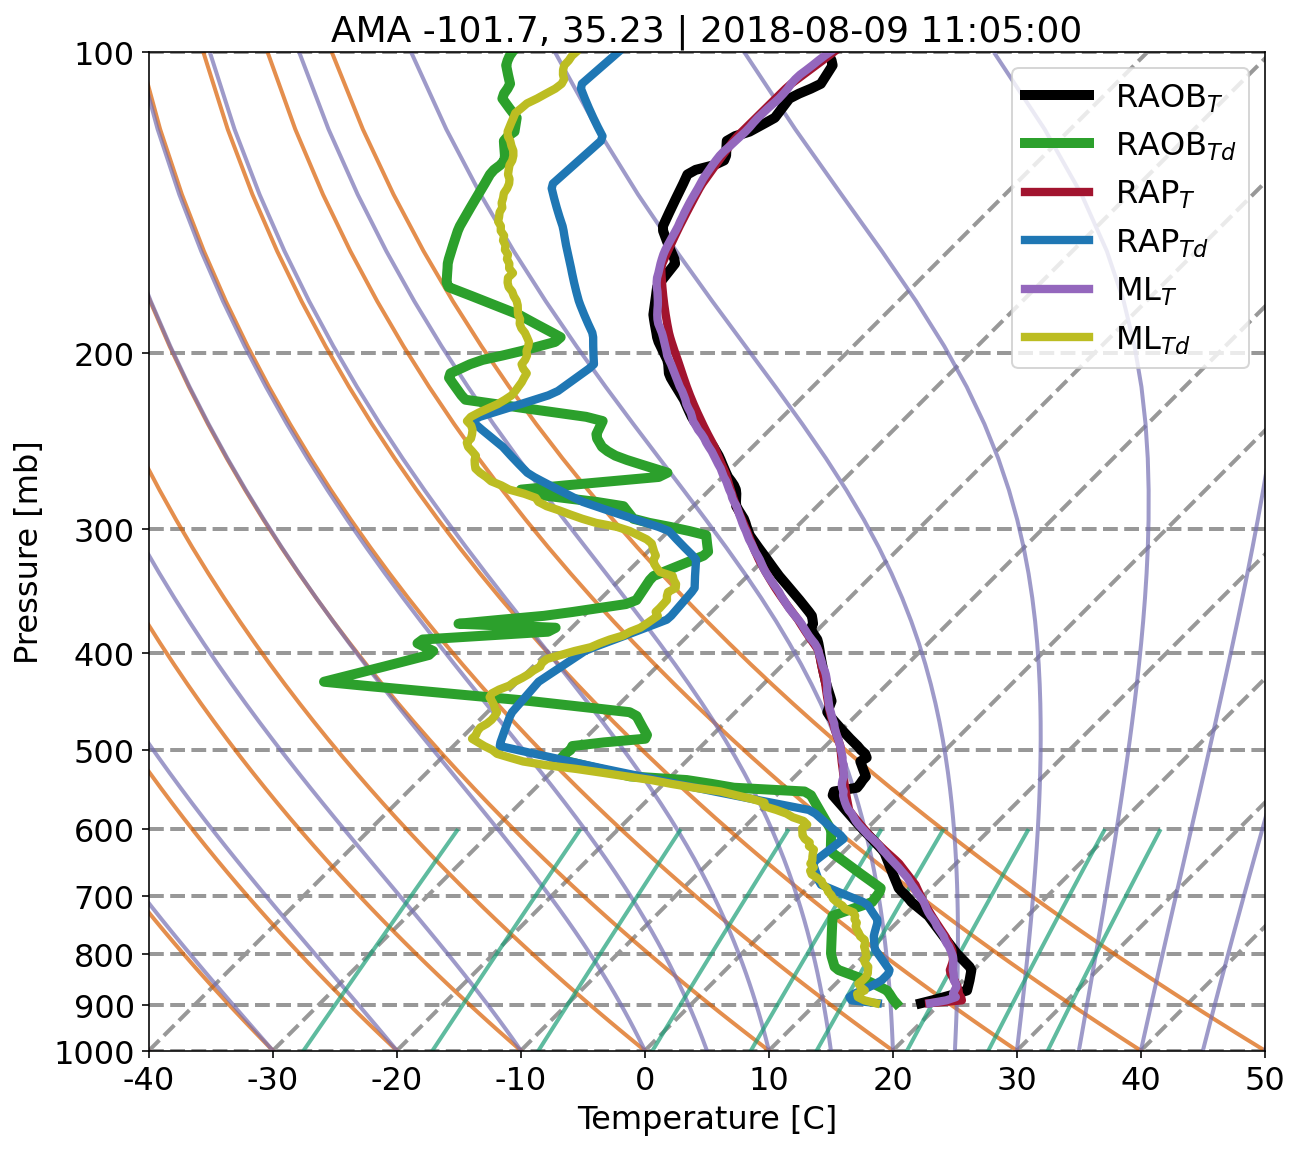

In [98]:
index = 10 # 1126
X = {'rap': Xer[index:index+1], 'im': Xei[index:index+1]} if Xei is not None else {'rap': Xer[index:index+1]}
Y = nnet.use(X).reshape(RAP[0:1,:,rap_output_dims].shape)

sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = RAPtest[index,:,dl.PRESSURE]

sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = RAOBtest[index,:,dl.TEMPERATURE]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = RAPtest[index,:,dl.TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = Y[0,:,0]

sounding[radiosonde_utils.DEWPOINT_COLUMN_KEY] = RAOBtest[index,:,dl.DEWPOINT]
sounding[radiosonde_utils.NWP_DEWPOINT_COLUMN_KEY] = RAPtest[index,:,dl.DEWPOINT]
sounding[radiosonde_utils.PREDICTED_DEWPOINT_COLUMN_KEY] = Y[0,:,1]

content = FILEtest[index].split('_')
date = pd.to_datetime(content[1], format='%Y-%m-%dT%H:%M:%S.%f')
lon, lat = content[-2], content[-1]
title = f'{content[0].upper()} {lon}, {lat} | {date}'
radiosonde_plotting.plot_nwp_ml_sounding(sounding, title_string=title,
                                         file_name=f"/home/stock/research/media/{content[0]}-{content[1]}_unet_upperair.pdf");

## Cloud Mask

In [17]:
bcm = np.load('/mnt/data1/stock/mlsoundings/goes_bcm_alley.npy')
bcm[np.isnan(bcm)] = -1 # nans to zero

In [18]:
bcm.shape

(38373, 1, 128, 128)

In [19]:
center = bcm.shape[-2]//2
new_size = 16
bcm = bcm[:,:,center-new_size//2:center+new_size//2, center-new_size//2:center+new_size//2]
bcm.shape

(38373, 1, 16, 16)

In [20]:
cloudy = np.zeros(len(bcm))
np.seterr(all='raise')
# 0 = clear or probably clear and 1 = cloudy or probably cloudy.
total = bcm.shape[-2] * bcm.shape[-1]
for i in range(len(bcm)):
    try:
        if (bcm[i] == -1).any(): # invalid
            cloudy[i] = -1
        elif ((bcm[i] == 1).sum() / total) >= .85: # 75% are cloudy
            cloudy[i] = 1
    except Exception as e:
        print(i,e)
np.unique(cloudy, return_counts=True)

(array([-1.,  0.,  1.]), array([ 2638, 20982, 14753]))

In [21]:
CLOUDtrain, CLOUDval, CLOUDtest = cloudy[train_i], cloudy[val_i], cloudy[test_i]

In [22]:
np.unique(CLOUDtest, return_counts=True)

(array([-1.,  0.,  1.]), array([ 392, 3096, 2245]))

In [16]:
np.unique(CLOUDtest, return_counts=True)

(array([-1.,  0.,  1.]), array([ 392, 3247, 2094]))

In [72]:
r = dict()

TEMP, DEWPT = 0, 1
sets = ['test']

for j, (Xr, Xi, RAP, T, cloud) in enumerate([(Xer, Xei, RAPtest , RAOBtest, CLOUDtest)]):

    X = {'rap': Xr, 'im': Xi} if Xi is not None else {'rap': Xr}
    Y = nnet.use(X).reshape(RAP[:,:,rap_output_dims].shape) # (None, 256, N)
    print('evaluating!')
    for c in np.unique(cloud):
        Yc = Y[cloud==c]
        Tc = T[cloud==c]
        Rc = RAP[cloud==c]
        (rmse, mean_rmse, # temperature
         rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(Yc[:,:,TEMP], Tc[:, :, 1])
        r[f'ml_{c}_temperature_{sets[j]}_rmse'] = rmse.tolist()
        r[f'ml_{c}_temperature_{sets[j]}_mean_rmse'] = mean_rmse
        r[f'ml_{c}_temperature_{sets[j]}_rmse_sfc'] = rmse_sfc.tolist()
        r[f'ml_{c}_temperature_{sets[j]}_mean_rmse_sfc'] = mean_rmse_sfc

        (rmse, mean_rmse, # dewpoint
         rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(Yc[:,:,DEWPT], Tc[:, :, 2])
        r[f'ml_{c}_dewpoint_{sets[j]}_rmse'] = rmse.tolist()
        r[f'ml_{c}_dewpoint_{sets[j]}_mean_rmse'] = mean_rmse
        r[f'ml_{c}_dewpoint_{sets[j]}_rmse_sfc'] = rmse_sfc.tolist()
        r[f'ml_{c}_dewpoint_{sets[j]}_mean_rmse_sfc'] = mean_rmse_sfc
        
        (rmse, mean_rmse, # temperature
         rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(Rc[:,:,1], Tc[:, :, 1])
        r[f'rap_{c}_temperature_{sets[j]}_rmse'] = rmse.tolist()
        r[f'rap_{c}_temperature_{sets[j]}_mean_rmse'] = mean_rmse
        r[f'rap_{c}_temperature_{sets[j]}_rmse_sfc'] = rmse_sfc.tolist()
        r[f'rap_{c}_temperature_{sets[j]}_mean_rmse_sfc'] = mean_rmse_sfc

        (rmse, mean_rmse, #dewpoint
         rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(Rc[:,:,2], Tc[:, :, 2])
        r[f'rap_{c}_dewpoint_{sets[j]}_rmse'] = rmse.tolist()
        r[f'rap_{c}_dewpoint_{sets[j]}_mean_rmse'] = mean_rmse
        r[f'rap_{c}_dewpoint_{sets[j]}_rmse_sfc'] = rmse_sfc.tolist()
        r[f'rap_{c}_dewpoint_{sets[j]}_mean_rmse_sfc'] = mean_rmse_sfc

evaluating!


In [76]:
df = pd.DataFrame([r])
# df.to_csv('/mnt/data1/stock/mlsoundings/results/unet_cloud_performance.csv', index=False)

In [77]:
df.filter(regex='mean')

ml_-1.0_temperature_test_mean_rmse  ml_-1.0_temperature_test_mean_rmse_sfc  \
0                            1.023428                                1.047438   

   ml_-1.0_dewpoint_test_mean_rmse  ml_-1.0_dewpoint_test_mean_rmse_sfc  \
0                         4.631937                              3.12751   

   rap_-1.0_temperature_test_mean_rmse  \
0                             1.133822   

   rap_-1.0_temperature_test_mean_rmse_sfc  rap_-1.0_dewpoint_test_mean_rmse  \
0                                  1.14309                          6.783251   

   rap_-1.0_dewpoint_test_mean_rmse_sfc  ml_0.0_temperature_test_mean_rmse  \
0                              3.593056                           0.904029   

   ml_0.0_temperature_test_mean_rmse_sfc  ml_0.0_dewpoint_test_mean_rmse  \
0                               0.896075                        4.279388   

   ml_0.0_dewpoint_test_mean_rmse_sfc  rap_0.0_temperature_test_mean_rmse  \
0                            2.919083                            0.976353   

   rap_0.0_temperature_test_mean_rmse_sfc  rap_0.0_dewpoint_test_mean_rmse  \
0                                0.993001                         6.372542   

   rap_0.0_dewpoint_test_mean_rmse_sfc  ml_1.0_temperature_test_mean_rmse  \
0                             3.302178                           1.051701   

   ml_1.0_temperature_test_mean_rmse_sfc  ml_1.0_dewpoint_test_mean_rmse  \
0                               1.072251                        4.595023   

   ml_1.0_dewpoint_test_mean_rmse_sfc  rap_1.0_temperature_test_mean_rmse  \
0                            2.682864                            1.143763   

   rap_1.0_temperature_test_mean_rmse_sfc  rap_1.0_dewpoint_test_mean_rmse  \
0                                1.146168                         5.737781   

   rap_1.0_dewpoint_test_mean_rmse_sfc  
0                             3.078673

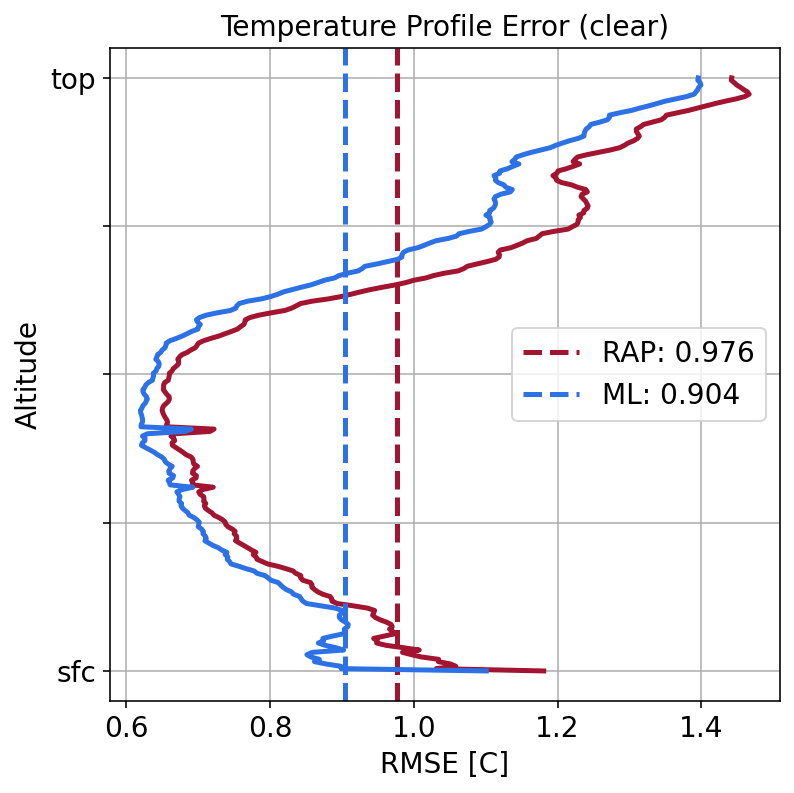

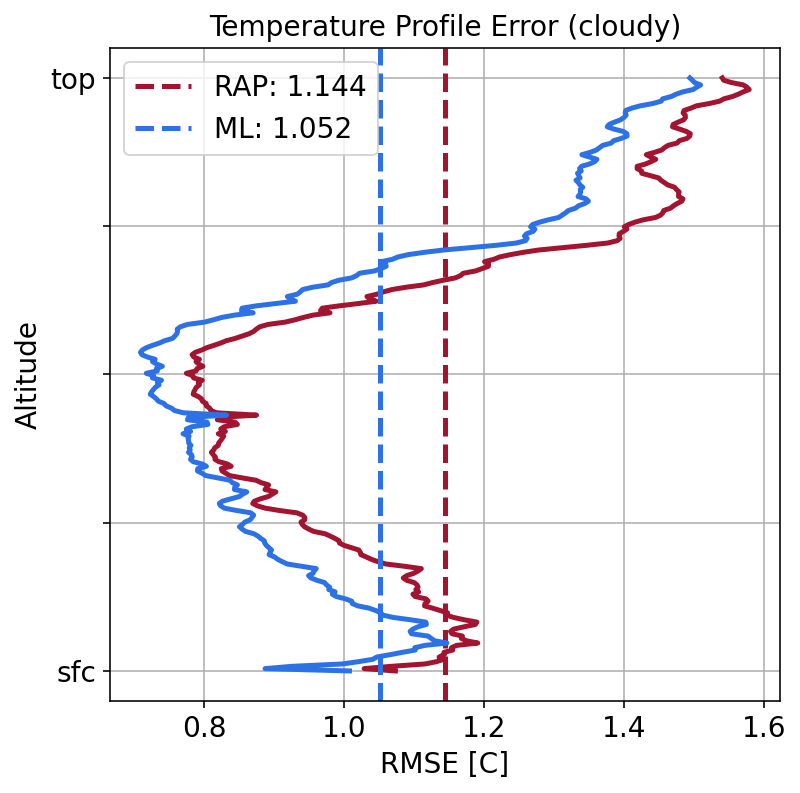

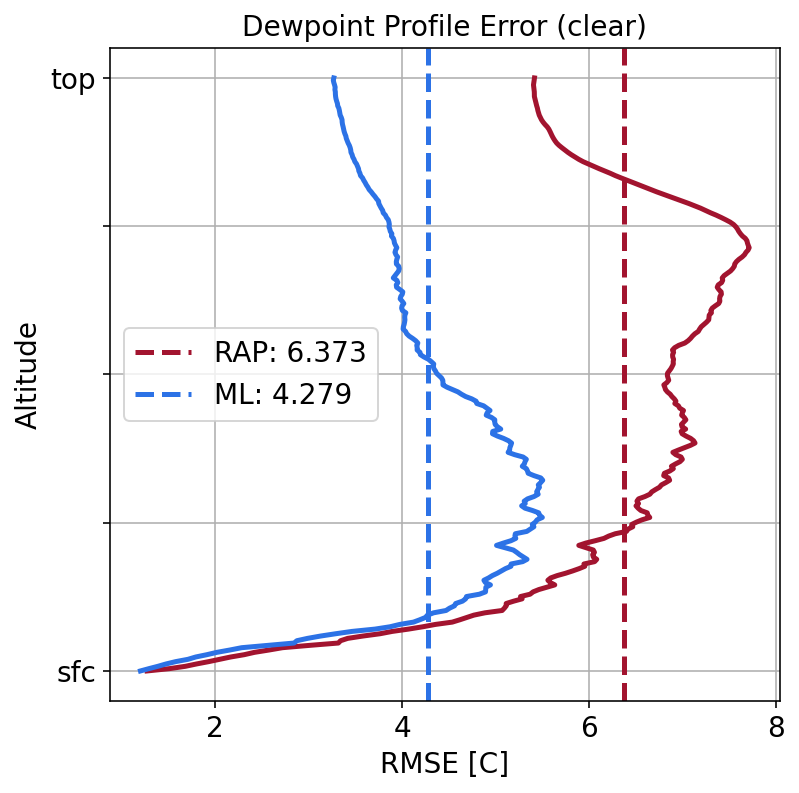

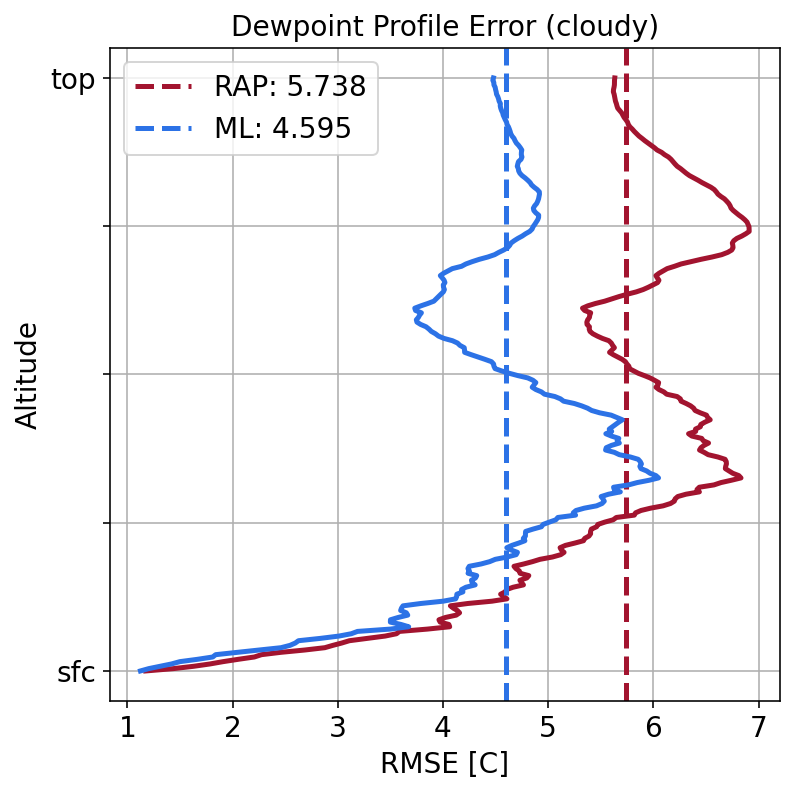

In [75]:
i = 0
data_set = 'test' # 'train'
for v in ['temperature', 'dewpoint']:
    for c in ([0.0, 1.0]):
        label = ('clear', 'cloudy')[int(c)]
        ml_rmse = np.asarray(df.iloc[i][f'ml_{c}_{v}_{data_set}_rmse'])
        ml_mean_rmse = df.iloc[i][f'ml_{c}_{v}_{data_set}_mean_rmse']
        rap_rmse = np.asarray(df.iloc[i][f'rap_{c}_{v}_{data_set}_rmse'])
        rap_mean_rmse = df.iloc[i][f'rap_{c}_{v}_{data_set}_mean_rmse']

        results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse, 
                                                   title=f'{v.capitalize()} Profile Error ({label})',
                                                   file_name=f'/home/stock/research/media/unet_cloud_mask_{label}_{v}_{data_set}.png')

## Regional Errors

In [17]:
names_train = [f.split('_')[0] for f in FILEtrain]
names_val   = [f.split('_')[0] for f in FILEval]
names_test  = [f.split('_')[0] for f in FILEtest]

In [18]:
np.unique(np.hstack([names_train, names_val, names_test]), return_counts=True)

(array(['abr', 'ama', 'bis', 'ddc', 'drt', 'dvn', 'fwd', 'ilx', 'lbf',
        'lzk', 'maf', 'mpx', 'oax', 'oun', 'sgf', 'shv', 'top', 'unr'],
       dtype='<U3'),
 array([2206, 2145, 2129, 2129, 1421, 2186, 2223, 2220, 2122, 2271, 2045,
        2193, 2116, 2142, 2259, 2257, 2139, 2152]))

In [75]:
locations = dict()

for i, f in enumerate(FILEtest):
    content = f.split('_')
    t = pd.to_datetime(content[1], format='%Y-%m-%dT%H:%M:%S.%f').month
    name = content[0]
    lon  = content[-2] 
    lat  = content[-1]
    if name in locations:
        arr = locations[name][2]
        arr.append(i)
        locations[name] = (lon, lat, arr)
    else:
        locations[name] = (lon, lat, [i])
        
df = pd.DataFrame.from_dict(locations).T
df = df.reset_index()
df.columns = ['location', 'lon', 'lat', 'indicies']
df.head(5)

location      lon    lat                                           indicies
0      lbf  -100.68  41.13  [0, 62, 65, 99, 110, 135, 142, 153, 157, 159, ...
1      unr  -103.21  44.07  [1, 15, 25, 33, 77, 101, 104, 169, 293, 295, 3...
2      lzk   -92.27  34.83  [2, 3, 6, 17, 19, 23, 44, 46, 47, 51, 59, 79, ...
3      sgf    -93.4  37.23  [4, 12, 16, 32, 117, 125, 126, 151, 165, 197, ...
4      fwd    -97.3   32.8  [5, 48, 67, 113, 114, 120, 136, 164, 171, 173,...

In [76]:
t_rmse  = []
td_rmse = []
og_t_rmse  = []
og_td_rmse = []
n_samples = []

X = {'rap': Xer, 'im': Xei} if Xei is not None else {'rap': Xer}

T = RAOBtest
Y = nnet.use(X).reshape(RAPtest[:,:,rap_output_dims].shape)

for i in range(len(df)):
    inds = df.iloc[i]['indicies']
    T_loc = T[inds]
    Y_loc = Y[inds]
    t_rmse.append(ml.rmse(T_loc[:,:,1], Y_loc[:,:,0]))
    td_rmse.append(ml.rmse(T_loc[:,:,2], Y_loc[:,:,1]))
    og_t_rmse.append(ml.rmse(T_loc[:,:,1], RAPtest[inds,:,1]))
    og_td_rmse.append(ml.rmse(T_loc[:,:,2], RAPtest[inds,:,2]))
    n_samples.append(len(inds))

df['t_rmse'] = t_rmse
df['td_rmse'] = td_rmse
df['og_t_rmse'] = og_t_rmse
df['og_td_rmse'] = og_td_rmse
df['n_samples'] = n_samples

In [73]:
percent_change(100, 10)

-90.0

In [77]:
def percent_change(start, final):
    return -100 * (start - final)/abs(start)

df['t_change']  = percent_change(df['og_t_rmse'],df['t_rmse'])
df['td_change'] = percent_change(df['og_td_rmse'],df['td_rmse'])

In [78]:
df.head(5)

location      lon    lat                                           indicies  \
0      lbf  -100.68  41.13  [0, 62, 65, 99, 110, 135, 142, 153, 157, 159, ...   
1      unr  -103.21  44.07  [1, 15, 25, 33, 77, 101, 104, 169, 293, 295, 3...   
2      lzk   -92.27  34.83  [2, 3, 6, 17, 19, 23, 44, 46, 47, 51, 59, 79, ...   
3      sgf    -93.4  37.23  [4, 12, 16, 32, 117, 125, 126, 151, 165, 197, ...   
4      fwd    -97.3   32.8  [5, 48, 67, 113, 114, 120, 136, 164, 171, 173,...   

     t_rmse   td_rmse  og_t_rmse  og_td_rmse  n_samples   t_change  td_change  
0  1.072719  4.314196   1.147094    6.039947        317  -6.483724 -28.572286  
1  1.112612  4.619203   1.234327    6.184986        321  -9.860834 -25.315868  
2  0.921241  4.740779   1.090822    6.755720        340 -15.546189 -29.825711  
3  0.903104  3.734250   0.992488    4.903295        336  -9.006001 -23.842012  
4  0.889323  4.506653   0.943972    6.544340        332  -5.789281 -31.136627

In [40]:
def regional_error_map(df, count, title, colorscale='ylorbr_r', fig_title='', colorbar_title=''):
    fig = go.Figure(data=go.Scattergeo(
            locationmode = 'USA-states',
            lon = df['lon'],
            lat = df['lat'],
            text = df['location'],
            mode = 'markers',
            marker = dict(
                size = 6,
                opacity = 0.80,
                reversescale = True,
                autocolorscale = False,
                symbol = 'square',
                line = dict(
                    width=0.80,
                    color='rgba(75, 75, 75)'
                ),
                colorscale = colorscale, # rdgy, viridis
                cmin = df[count].min(), # 0,
                color = df[count],
                cmax = df[count].max(),
                colorbar = dict(
                    title = dict(side= 'right', text=colorbar_title),
                    titlefont = dict(color='black', size=11),
                    nticks = 10,
                    len = 0.90,
                    thickness = 10,
                    ticks = 'outside',
                    tickcolor = 'black',
                    tickfont = dict(family='Arial', size=11, color='black'), # "Courier New", "Times New Roman"
                    x = 0.90
                ),
            )
                   ))
    """
    ['aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
     'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
     'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
     'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
     'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
     'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
     'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
     'orrd', 'oryel', 'peach', 'phase', 'picnic', 'pinkyl', 'piyg',
     'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn', 'puor',
     'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu', 'rdgy',
     'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar', 'spectral',
     'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn', 'tealrose',
     'tempo', 'temps', 'thermal', 'tropic', 'turbid', 'twilight',
     'viridis', 'ylgn', 'ylgnbu', 'ylorbr', 'ylorrd']
    """
    fig.update_layout(
            geo = dict(
                scope = 'usa',
                projection_type = 'albers usa',
                showland = True,
                landcolor = "rgb(250, 250, 250)",
                subunitcolor = "rgb(100, 100, 100)",
                countrycolor = "rgb(100, 100, 100)",
                countrywidth = 0.5,
                subunitwidth = 0.5
            ), 
            title_text = fig_title,
            title_x=0.5,
            title_y=1,
            title_font_color='black',
            title_font_size=11,
            margin=dict(l=0, r=0, t=0, b=5)
        )
    fig.show()

    fig.write_image(title, width=450, height=225, scale=4)

In [41]:
locations = dict()

for i, f in enumerate(np.hstack([FILEtrain,FILEval,FILEtest])):
    content = f.split('_')
    t = pd.to_datetime(content[1], format='%Y-%m-%dT%H:%M:%S.%f').month
    name = content[0]
    lon  = content[-2] 
    lat  = content[-1]
    if name in locations:
        arr = locations[name][2]
        arr.append(i)
        locations[name] = (lon, lat, arr)
    else:
        locations[name] = (lon, lat, [i])
        
df_samples = pd.DataFrame.from_dict(locations).T
df_samples = df_samples.reset_index()
df_samples.columns = ['location', 'lon', 'lat', 'indicies']

n_samples = []

for i in range(len(df_samples)):
    inds = df_samples.iloc[i]['indicies']
    n_samples.append(len(inds))

df_samples['n_samples'] = n_samples

In [37]:
"""
['aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
 'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
 'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
 'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
 'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
 'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
 'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
 'orrd', 'oryel', 'peach', 'phase', 'picnic', 'pinkyl', 'piyg',
 'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn', 'puor',
 'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu', 'rdgy',
 'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar', 'spectral',
 'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn', 'tealrose',
 'tempo', 'temps', 'thermal', 'tropic', 'turbid', 'twilight',
 'viridis', 'ylgn', 'ylgnbu', 'ylorbr', 'ylorrd']
"""

"\n['aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',\n 'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',\n 'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',\n 'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',\n 'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',\n 'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',\n 'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',\n 'orrd', 'oryel', 'peach', 'phase', 'picnic', 'pinkyl', 'piyg',\n 'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn', 'puor',\n 'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu', 'rdgy',\n 'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar', 'spectral',\n 'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn', 'tealrose',\n 'tempo', 'temps', 'thermal', 'tropic', 'turbid', 'twilight',\n 'viridis', 'ylgn', 'ylgnbu', 'ylorbr', 'ylorrd']\n"

In [61]:
regional_error_map(df_samples, 'n_samples', '/home/stock/research/media/n_samples_map.png', colorscale='blues', 
                   fig_title='Samples per Location', colorbar_title='Frequency')

In [79]:
regional_error_map(df, 't_change', '/home/stock/research/media/temperature_change_error_bubble_map.png',
                   fig_title='Temperature', colorbar_title='RMSE Change [%]')

In [80]:
regional_error_map(df, 'td_change', '/home/stock/research/media/dewpoint_change_error_bubble_map.png',
                   fig_title='Dewpoint', colorbar_title='RMSE Change [%]')

In [59]:
regional_error_map(df, 'og_t_rmse', '/home/stock/research/media/temperature_rap_error_bubble_map.png',
                   fig_title='Temperature', colorbar_title='RMSE [C]')

In [60]:
regional_error_map(df, 'og_td_rmse', '/home/stock/research/media/dewpoint_rap_error_bubble_map.png',
                   fig_title='Dewpoint', colorbar_title='RMSE [C]')

## Error Distribution by Month

In [62]:
from soundings.plotting import radiosonde_plotting

In [81]:
samples = dict()

for i, f in enumerate(FILEtest):
    content = f.split('_')
    month = pd.to_datetime(content[1], format='%Y-%m-%dT%H:%M:%S.%f').month
    if month in samples:
        arr = samples[month][0]
        arr.append(i)
        samples[month] = [arr]
    else:
        samples[month] = [[i]]
        
df = pd.DataFrame.from_dict(samples).T
df = df.reset_index()
df.columns = ['month', 'indicies']

df = df.sort_values('month')
df.head(5)

month                                           indicies
2       1  [2, 9, 17, 22, 27, 31, 64, 149, 151, 189, 204,...
9       2  [14, 53, 54, 58, 61, 93, 96, 113, 117, 124, 13...
5       3  [5, 7, 20, 21, 44, 47, 51, 56, 85, 86, 88, 106...
10      4  [16, 52, 55, 59, 66, 67, 83, 90, 107, 109, 135...
6       5  [6, 39, 40, 43, 92, 123, 126, 130, 144, 148, 1...

In [93]:
t_rmse  = []
td_rmse = []
og_t_rmse = []
og_td_rmse = []
X = {'rap': Xer, 'im': Xei} if Xei is not None else {'rap': Xer}

T = RAOBtest
Y = nnet.use(X).reshape(RAPtest[:,:,rap_output_dims].shape)

for i in range(len(df)):
    inds = df.iloc[i]['indicies']
    # rmse for each individual profile
    t_rmse.append(np.sqrt(np.mean((T[inds,:,1] - Y[inds,:,0])**2, axis=1)))
    td_rmse.append(np.sqrt(np.mean((T[inds,:,2] - Y[inds,:,1])**2, axis=1)))
    
    og_t_rmse.append(np.sqrt(np.mean((T[inds,:,1] - RAPtest[inds,:,1])**2, axis=1)))
    og_td_rmse.append(np.sqrt(np.mean((T[inds,:,2] - RAPtest[inds,:,2])**2, axis=1)))
    
df['t_rmse'] = t_rmse
df['td_rmse'] = td_rmse
df['og_t_rmse'] = og_t_rmse
df['og_td_rmse'] = og_td_rmse

In [94]:
def percent_change(start, final):
    return -100 * (start - final)/abs(start)

df['t_change']  = percent_change(df['og_t_rmse'],df['t_rmse'])
df['td_change'] = percent_change(df['og_td_rmse'],df['td_rmse'])

In [95]:
df.head(5)

month                                           indicies  \
2       1  [2, 9, 17, 22, 27, 31, 64, 149, 151, 189, 204,...   
9       2  [14, 53, 54, 58, 61, 93, 96, 113, 117, 124, 13...   
5       3  [5, 7, 20, 21, 44, 47, 51, 56, 85, 86, 88, 106...   
10      4  [16, 52, 55, 59, 66, 67, 83, 90, 107, 109, 135...   
6       5  [6, 39, 40, 43, 92, 123, 126, 130, 144, 148, 1...   

                                               t_rmse  \
2   [0.7378228579589722, 1.0657937460822051, 0.694...   
9   [0.6900641487049306, 0.9029605850098233, 1.223...   
5   [1.4136807510631124, 1.2240000246561147, 1.090...   
10  [0.6628328450545884, 0.8585934432345814, 0.714...   
6   [0.731848087601339, 0.9023229314431397, 0.7756...   

                                              td_rmse  \
2   [2.6685246989678597, 6.695483328997406, 2.2628...   
9   [5.4814638472551, 4.0304599158559595, 4.175271...   
5   [4.015314861215598, 3.2314990084748128, 3.7844...   
10  [5.222870597065037, 4.165545496559098, 3.27964...   
6   [6.066386042237131, 5.184089875182205, 4.80298...   

                                            og_t_rmse  \
2   [0.7271150944995485, 1.2124702538058991, 0.818...   
9   [0.8467123480701685, 0.9727086847049397, 1.276...   
5   [1.6336085955370918, 1.5038893671918132, 1.042...   
10  [0.7822912736988764, 1.2123506337854646, 0.770...   
6   [0.8989333607702636, 1.0492186136464878, 0.908...   

                                           og_td_rmse  \
2   [2.8487758922893884, 11.549033171964872, 3.921...   
9   [7.492355746174585, 8.031586982295309, 6.52207...   
5   [6.261718007861423, 3.0933946108326054, 5.6858...   
10  [5.385203293534525, 4.84935092914481, 5.172583...   
6   [9.142356305127297, 7.064976414998272, 6.36019...   

                                             t_change  \
2   [1.4726366623971043, -12.097328347914672, -15....   
9   [-18.50075763301094, -7.170502411652016, -4.14...   
5   [-13.462701229340208, -18.611032742277516, 4.6...   
10  [-15.270326112607332, -29.179445342995006, -7....   
6   [-18.587058892302682, -14.000483816506286, -14...   

                                            td_change  
2   [-6.327320931400882, -42.02559444325951, -42.2...  
9   [-26.839247454930288, -49.817390700734045, -35...  
5   [-35.87518862755436, 4.464493380785834, -33.44...  
10  [-3.0144209535113573, -14.100968203311751, -36...  
6   [-33.64526780874941, -26.622686748438735, -24....

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [143]:
for month in df['month']:
    print(month)

1
2
3
4
5
6
7
8
9
10
11
12


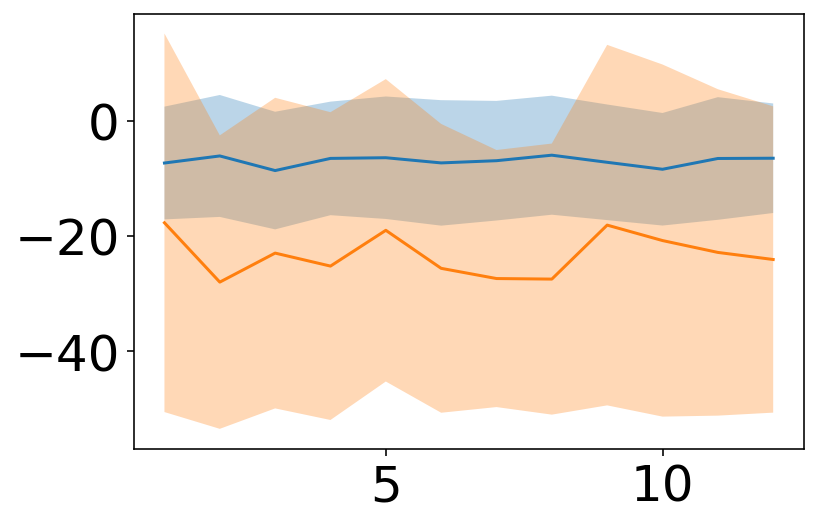

In [175]:
fig, ax = plt.subplots()
mean_std = np.array([[df[col][month - 1].mean(), df[col][month - 1].std()] 
                     for month in df['month'] 
                     for col in ['t_change']])
meanst = mean_std[:,0]
sdt = mean_std[:,1]
ax.plot(df['month'], meanst)
ax.fill_between(df['month'], meanst-sdt, meanst+sdt ,alpha=0.3)

mean_std = np.array([[df[col][month - 1].mean(), df[col][month - 1].std()] 
                     for month in df['month'] 
                     for col in ['td_change']])
meanst = mean_std[:,0]
sdt = mean_std[:,1]
ax.plot(df['month'], meanst)
ax.fill_between(df['month'], meanst-sdt, meanst+sdt ,alpha=0.3)

# mean_std = np.array([[df[col][month - 1].mean(), df[col][month - 1].std()] 
#                      for month in df['month'] 
#                      for col in ['t_rmse']])
# meanst = mean_std[:,0]
# sdt = mean_std[:,1]
# ax.plot(df['month'], meanst)
# ax.fill_between(df['month'], meanst-sdt, meanst+sdt ,alpha=0.3)

# mean_std = np.array([[df[col][month - 1].mean(), df[col][month - 1].std()] 
#                      for month in df['month'] 
#                      for col in ['og_t_rmse']])
# meanst = mean_std[:,0]
# sdt = mean_std[:,1]
# ax.plot(df['month'], meanst)
# ax.fill_between(df['month'], meanst-sdt, meanst+sdt ,alpha=0.3)



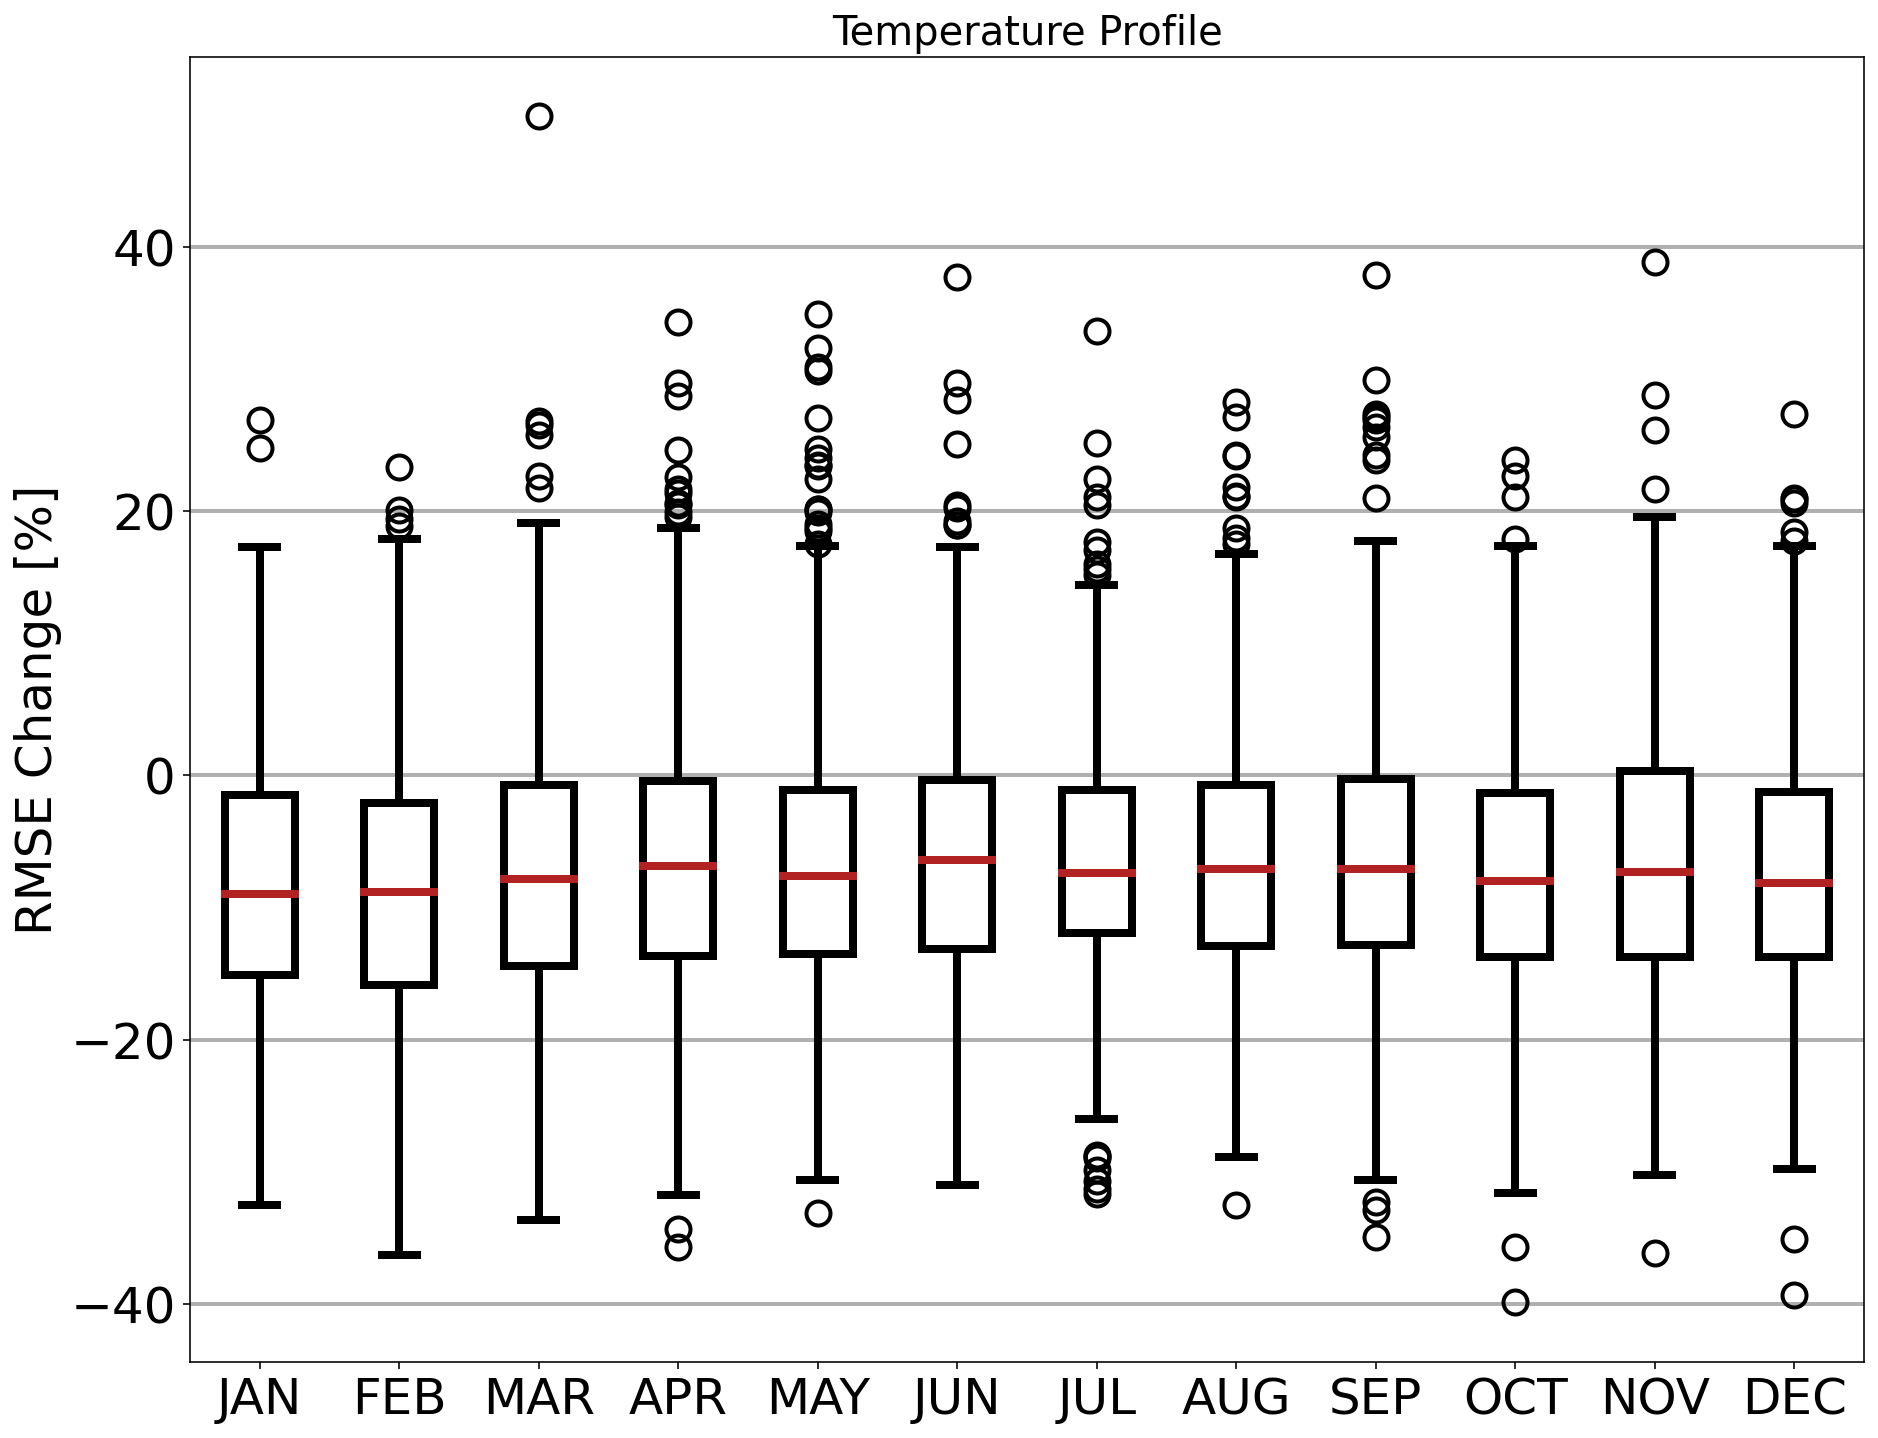

In [97]:
radiosonde_plotting.plot_monthly_error(df['t_change'].values, df['month'].values, 'Temperature Profile', y_label='RMSE Change [%]',
                                       file_name='/home/stock/research/media/temperature_monthly_change_error.png');

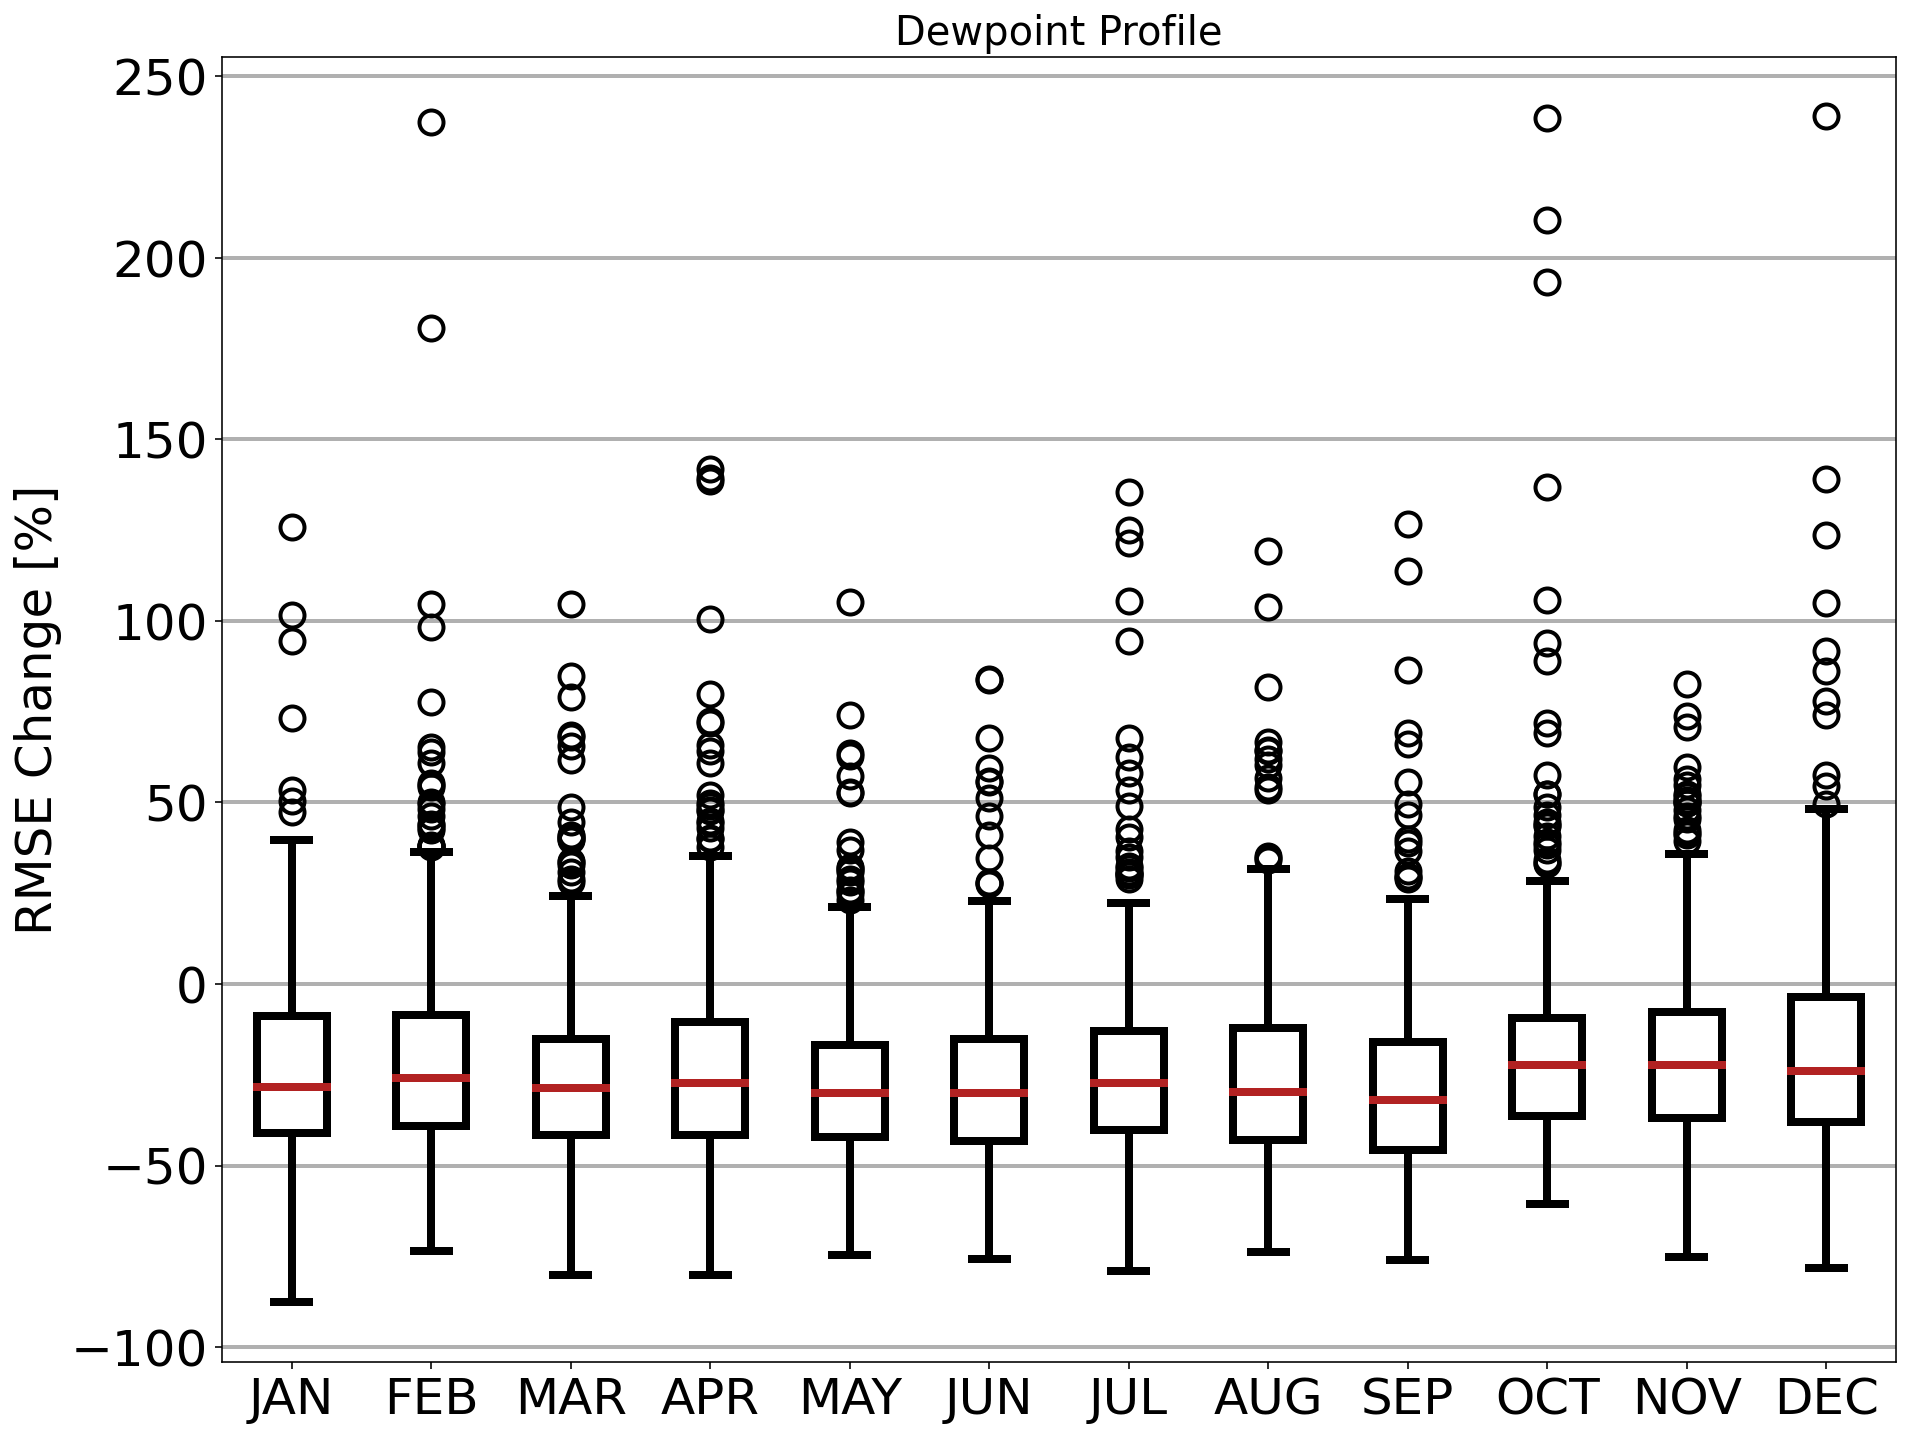

In [98]:
radiosonde_plotting.plot_monthly_error(df['td_change'].values, df['month'].values, 'Dewpoint Profile', y_label='RMSE Change [%]',
                                       file_name='/home/stock/research/media/dewpoint_monthly_change_error.png');

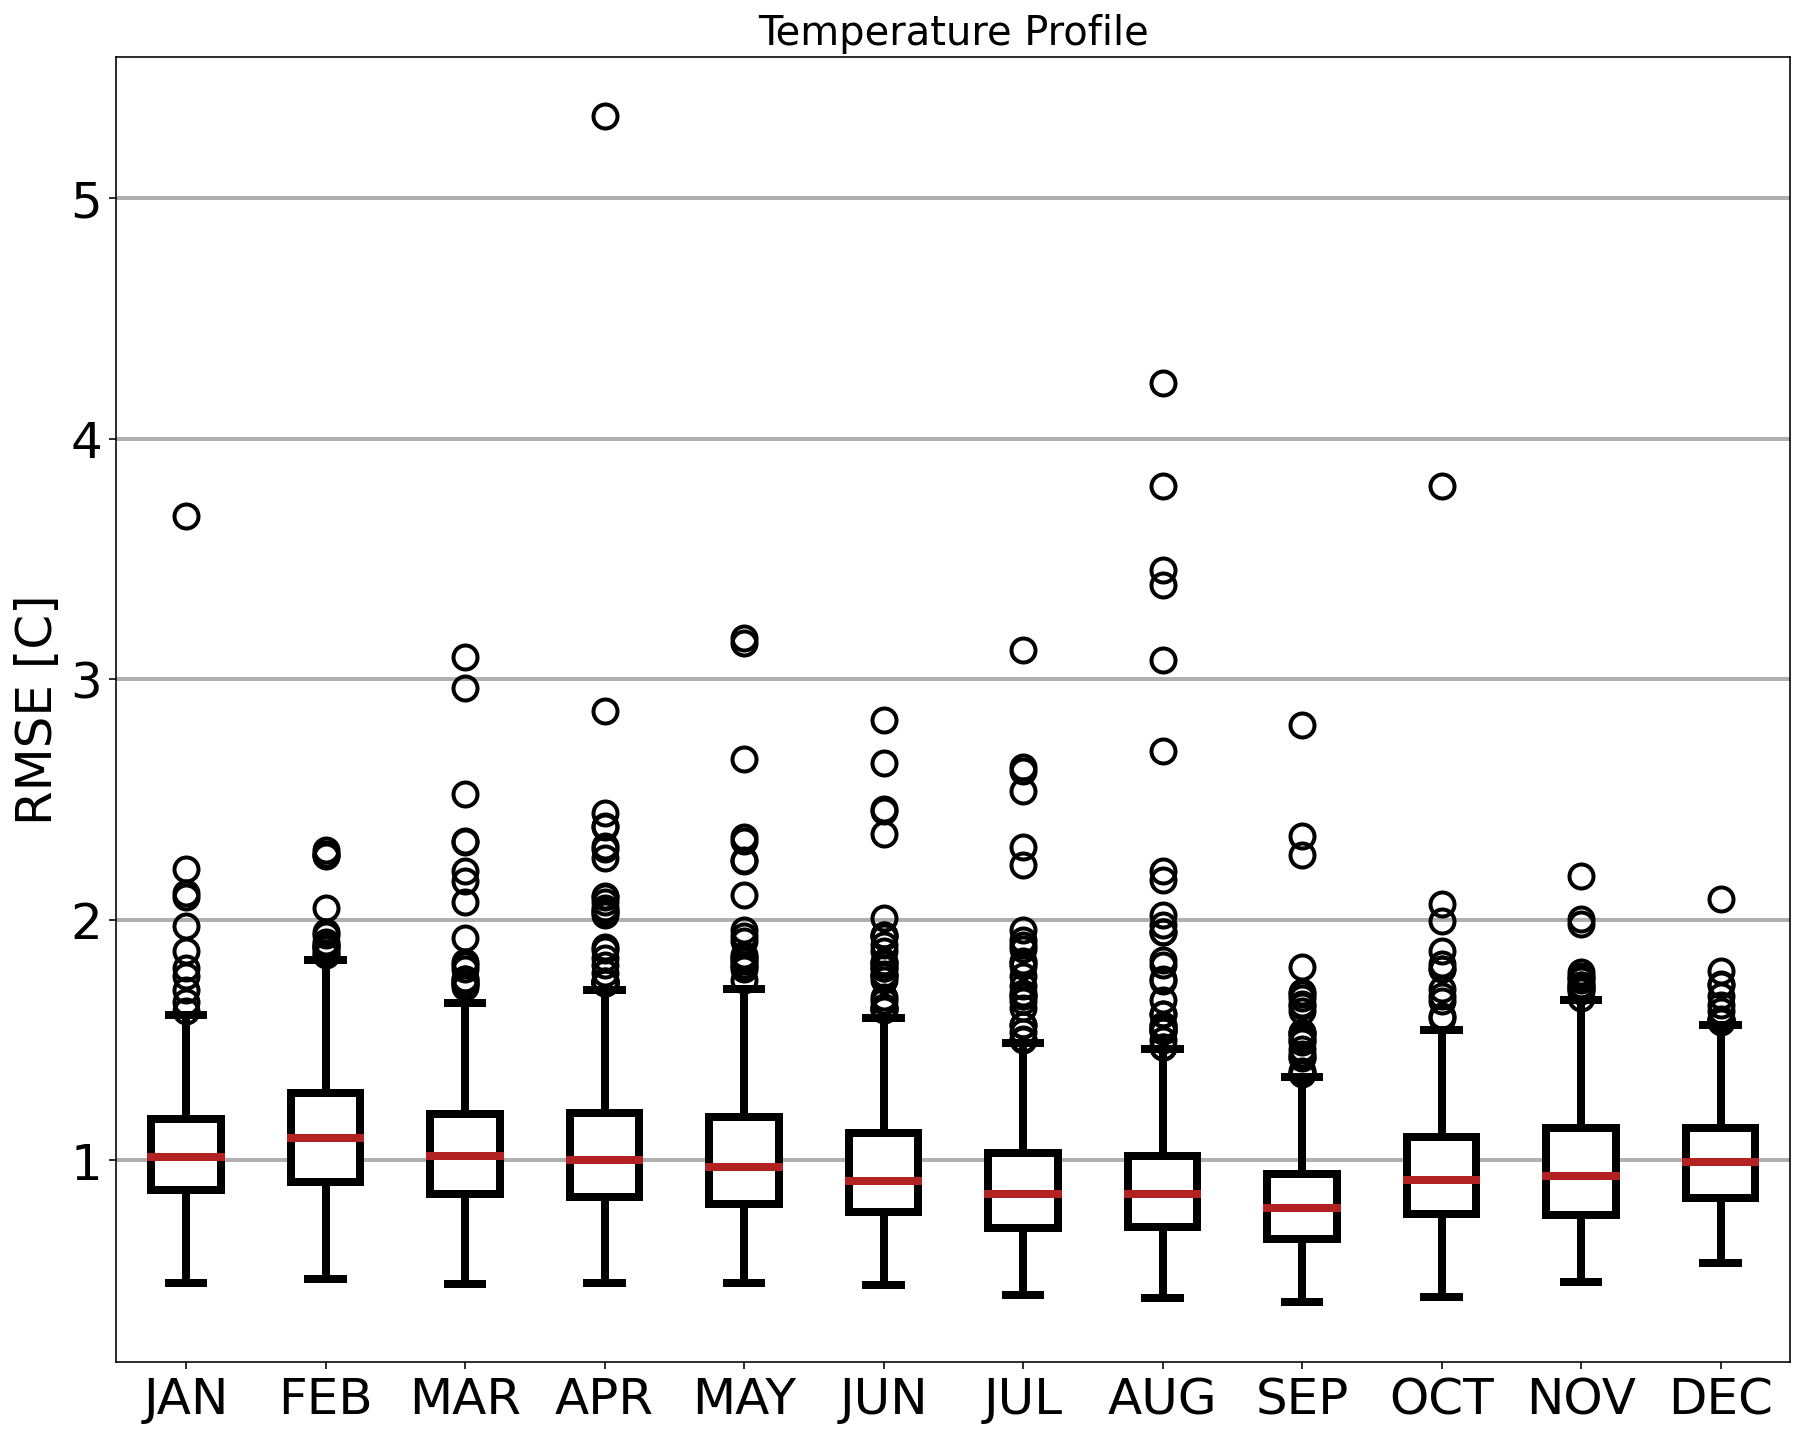

In [177]:
radiosonde_plotting.plot_monthly_error(df['og_t_rmse'].values, df['month'].values, 'Temperature Profile', 
                                       file_name='/home/stock/research/media/temperature_monthly_rap_error.png');

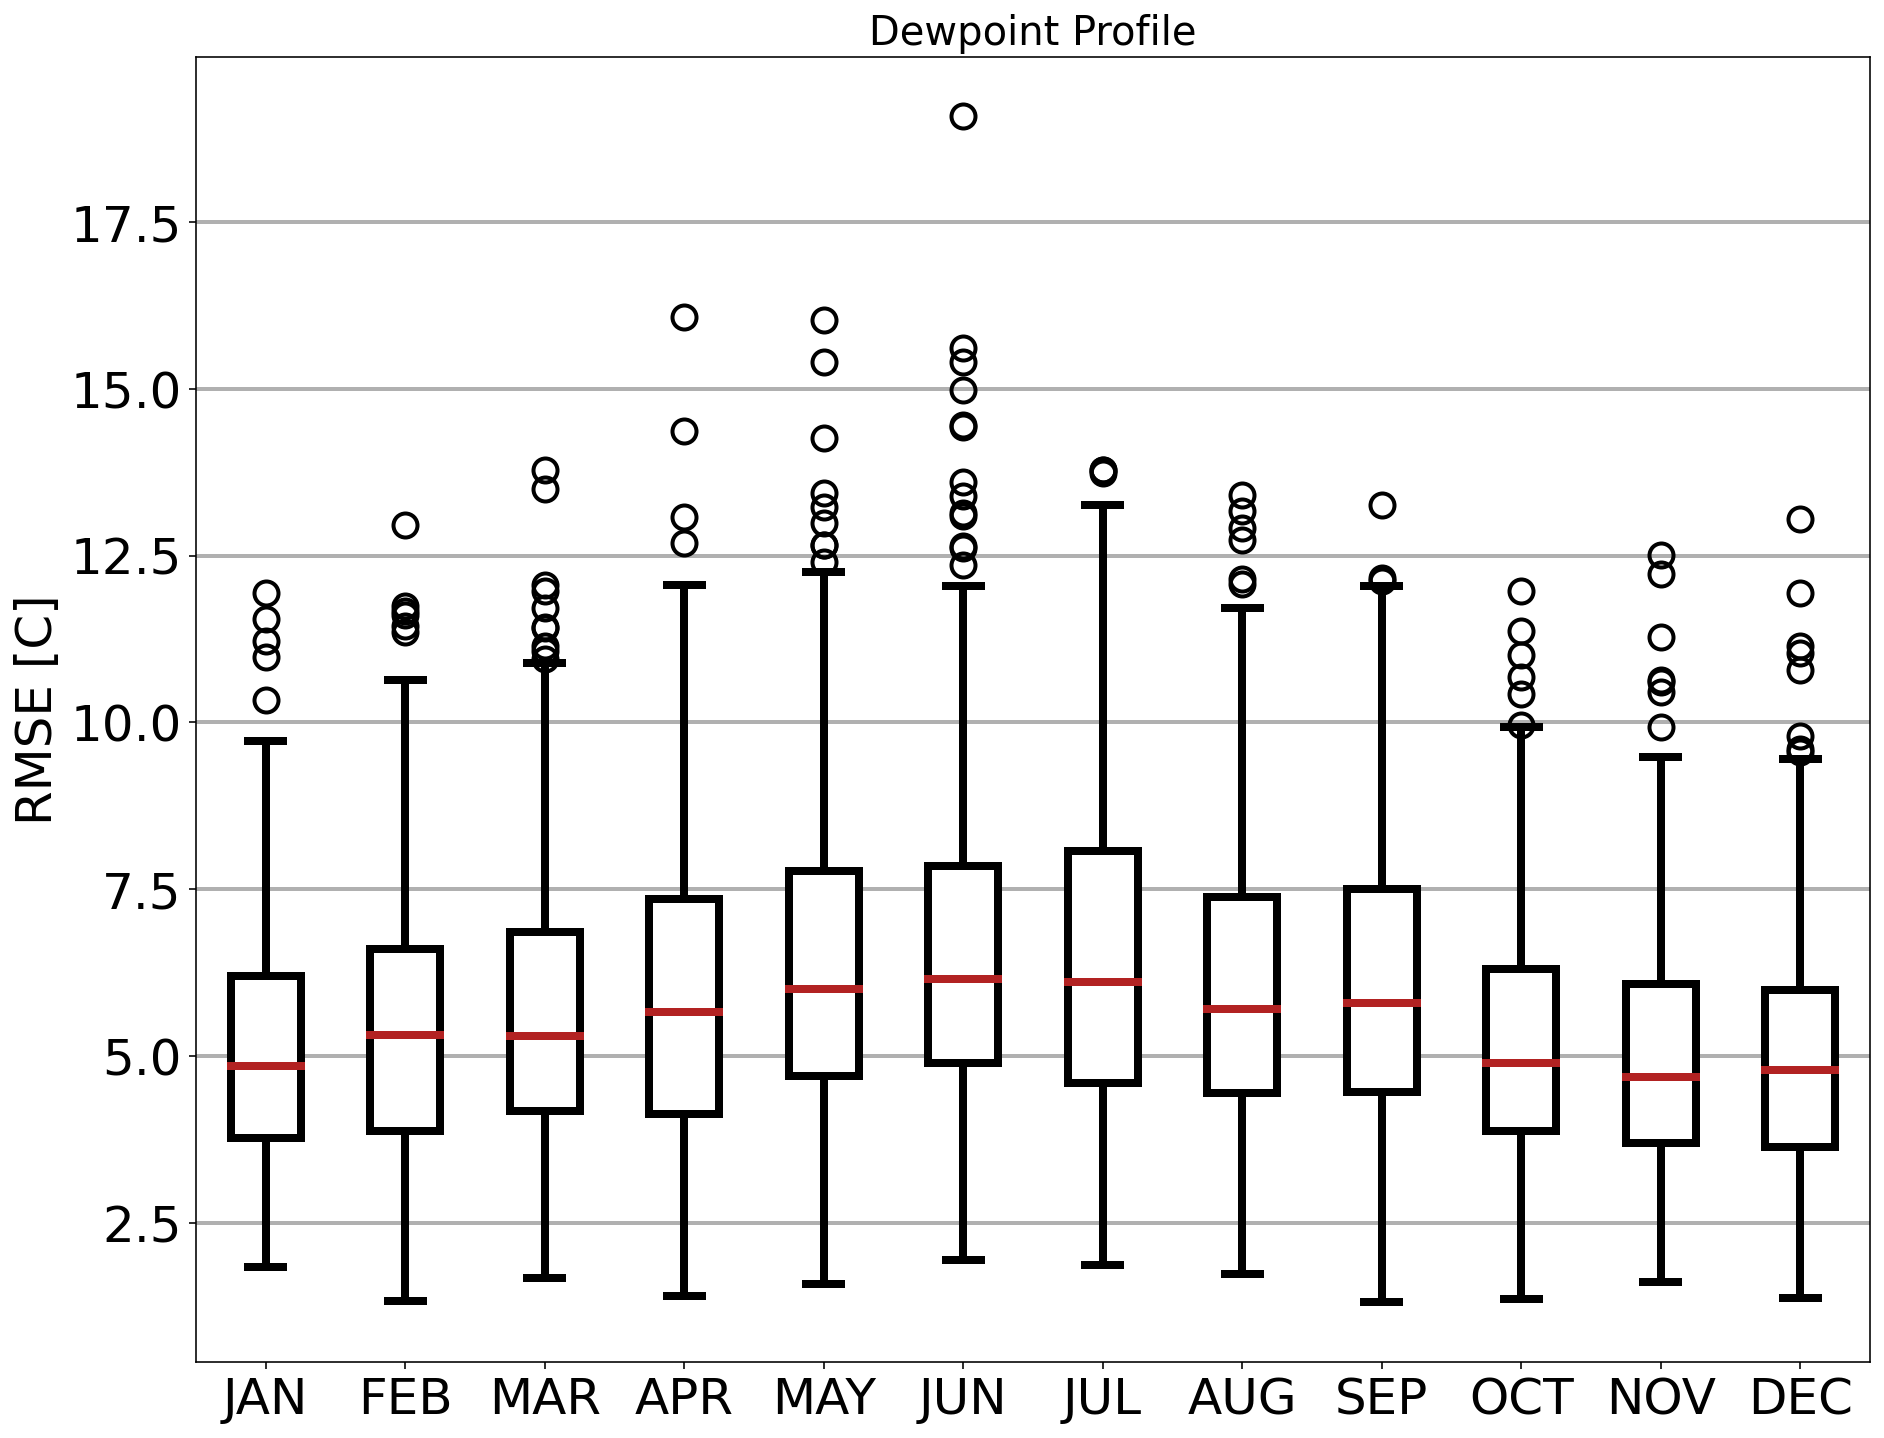

In [176]:
radiosonde_plotting.plot_monthly_error(df['og_td_rmse'].values, df['month'].values, 'Dewpoint Profile',
                                       file_name='/home/stock/research/media/dewpoint_monthly_rap_error.png');